# Random sampling-based compressed sensing (RSCS)

Domingo, Kenneth V.<br />
2015-03116<br />
Video and Image Processing Group<br />
Instrumentation Physics Laboratory<br />

In [1]:
import multiprocessing as multi
import numpy as np
import matplotlib.pyplot as mp
from mpl_toolkits.mplot3d import Axes3D
import scipy.fftpack as fft
import scipy.io.wavfile as wav
import numpy.random as rd
import numpy.linalg as nla
import sklearn.linear_model as skl
import sklearn.metrics as skm
import cvxpy as cvx
import seaborn as sns
import time
from tqdm.notebook import tqdm, trange
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
sns.set()
sns.set_context('talk')
mp.rcParams["figure.figsize"] = (5*16/9,5)
mp.rcParams["figure.dpi"] = 100
rd.seed(314159)

In [3]:
def SL0(A, x, func, sigma_min=0.015, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, true_s=None, ShowProgress=False):
    """
     Returns the sparsest vector s which satisfies underdetermined system of
     linear equations  A*s=x, using  Smoothed L0  (SL0) algorithm. Note that 
     the matrix  A should  be a 'wide' matrix  (more columns than rows). The 
     number of the rows of  matrix A  should  be  equal to the length of the 
     column vector x.
     
     __author__ = M. Babaie-Zadeh, and H. Mohimani
     __site__ = http://ee.sharif.ir/~SLzero
    """
    
    if A_pinv == None:
        A_pinv = nla.pinv(A)
    s = A_pinv.dot(x)
    sigma = 2*max(abs(s))
    while sigma > sigma_min:
        
        if func == "DeltaGauss":
            for i in range(L):
                delta = DeltaGauss(s, sigma)
                s -= mu_0*delta
                s -= s - A_pinv.dot((A.dot(s) - x))
            if ShowProgress:
                if true_s != None:
                    print("sigma = %f, SNR = %f"%(sigma, estimate_SNR(s, true_s)))
                else:
                    print("sigma = %f"%(sigma))
            sigma *= sigma_decrease_factor
        
        elif func == "DeltaHyptan":
            for i in range(L):
                delta = DeltaHyptan(s, sigma)
                s -= mu_0*delta
                s -= s - A_pinv.dot((A.dot(s) - x))
            if ShowProgress:
                if true_s != None:
                    print("sigma = %f, SNR = %f"%(sigma, estimate_SNR(s, true_s)))
                else:
                    print("sigma = %f"%(sigma))
            sigma *= sigma_decrease_factor
            
    return s
        
def DeltaGauss(s, sigma):
    delta = s*np.exp(-abs(s)**2/sigma**2)
    return delta

def DeltaHyptan(s, sigma):
    num = np.exp(s**2/2/sigma**2) - np.exp(s**2/(-2)/sigma**2)
    den = np.exp(s**2/2/sigma**2) + np.exp(s**2/(-2)/sigma**2)
    delta = num/den
    return delta

def estimate_SNR(estim_s, true_s):
    err = true_s - estim_s
    SNR = 10*np.log10(sum(abs(true_s)**2)/(sum(abs(err)**2)))
    return SNR

def normalize(x):
    x = x.astype(float)
    x -= x.min()
    if x.max() != 0:
        x /= x.max()
    return x

In [8]:
signal = np.loadtxt("piano.txt").astype('float32')

In [9]:
samprate = 44.1e3
duration = 1/8
N = int(duration*samprate)
M = 300
t = np.linspace(0,duration,N)

f1 = 440 # Hz
f2 = 550 # Hz

coeffs = fft.fft(signal)
freq = np.argmax(coeffs)/len(coeffs)*samprate
nyqrate = freq*2

print("Compression ratio = %.3f percent"%(M/N*100))
print("Nyquist rate = %.2f Hz"%(nyqrate))

Compression ratio = 5.443 percent
Nyquist rate = 1050.46 Hz


In [10]:
siginit = 40000
x = signal[siginit:siginit+N]

yi = rd.randint(0,N,(M,))
yi = np.sort(yi)
y = x[yi]

In [11]:
print("Original signal = %i points"%len(signal))
print("Selected portion of signal = %i points"%len(x))

Original signal = 100000 points
Selected portion of signal = 5512 points


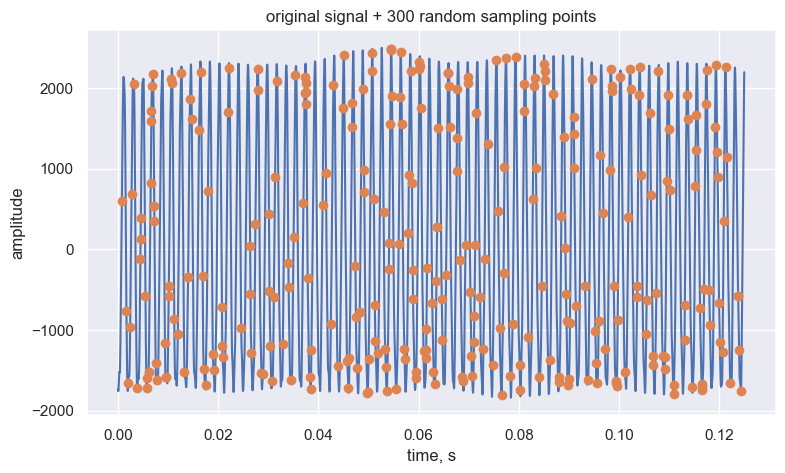

In [13]:
mp.figure()

mp.plot(t, x)
mp.plot(t[yi], y, "o")
mp.xlabel("time, s")
mp.ylabel("amplitude")
mp.title("original signal + %i random sampling points"%M)

# mp.savefig("RSCS-3/random_sampling.png", dpi=300, bbox_inches="tight")
mp.show()

In [14]:
d = np.identity(N)
d = fft.dct(d)
A = d[yi]

In [15]:
# L1 optimizaiton using CVX ECOS
xhat_cvx = cvx.Variable(N)
objective = cvx.Minimize(cvx.norm(xhat_cvx, 1))
constraints = [A*xhat_cvx == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True, solver='ECOS')
x_cvx = np.array(xhat_cvx.value)
x_cvx = np.squeeze(x_cvx)
x_cvx = fft.dct(x_cvx, norm="ortho", axis=0)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.359e-21  +5.976e-17  +3e+05  9e-01  1e-02  1e+00  3e+01    ---    ---    1  1  - |  -  - 
 1  +1.135e+03  +1.137e+03  +2e+05  9e-01  6e-03  2e+00  1e+01  0.5129  1e-01   1  1  1 |  0  0
 2  +9.071e+02  +9.147e+02  +1e+05  5e-01  5e-03  8e+00  1e+01  0.7098  8e-01   1  1  0 |  0  0
 3  +1.696e+03  +1.703e+03  +8e+04  4e-01  3e-03  7e+00  7e+00  0.9229  6e-01   1  0  1 |  0  0
 4  +1.944e+03  +1.948e+03  +4e+04  2e-01  2e-03  4e+00  4e+00  0.4841  5e-02   1  1  1 |  0  0
 5  +2.174e+03  +2.176e+03  +3e+04  2e-01  1e-03  2e+00  3e+00  0.5337  3e-01   1  1  1 |  0  0
 6  +2.365e+03  +2.367e+03  +2e+04  1e-01  7e-04  2e+00  2e+00  0.6671  5e-01   1  1  1 |  0  0
 7  +2.499e+03  +2.500e+03  +1e+04  6e-02  4e-04  9e-01  1e+00  0.7696  5e-01   1  1  1 |  0  0
 8  +2.654e+03  +2.654e+03  +5e+03  3e-02  2e-

In [16]:
# L1 optimization using LASSO
lasso = skl.LassoCV(cv=10, random_state=0, verbose=True, n_jobs=-1)
# lasso = skl.Lasso(alpha=1.0)
lasso.fit(A, y)
x_las = fft.idct(lasso.coef_)
print(lasso.alpha_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

22.74547663469678


......[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished


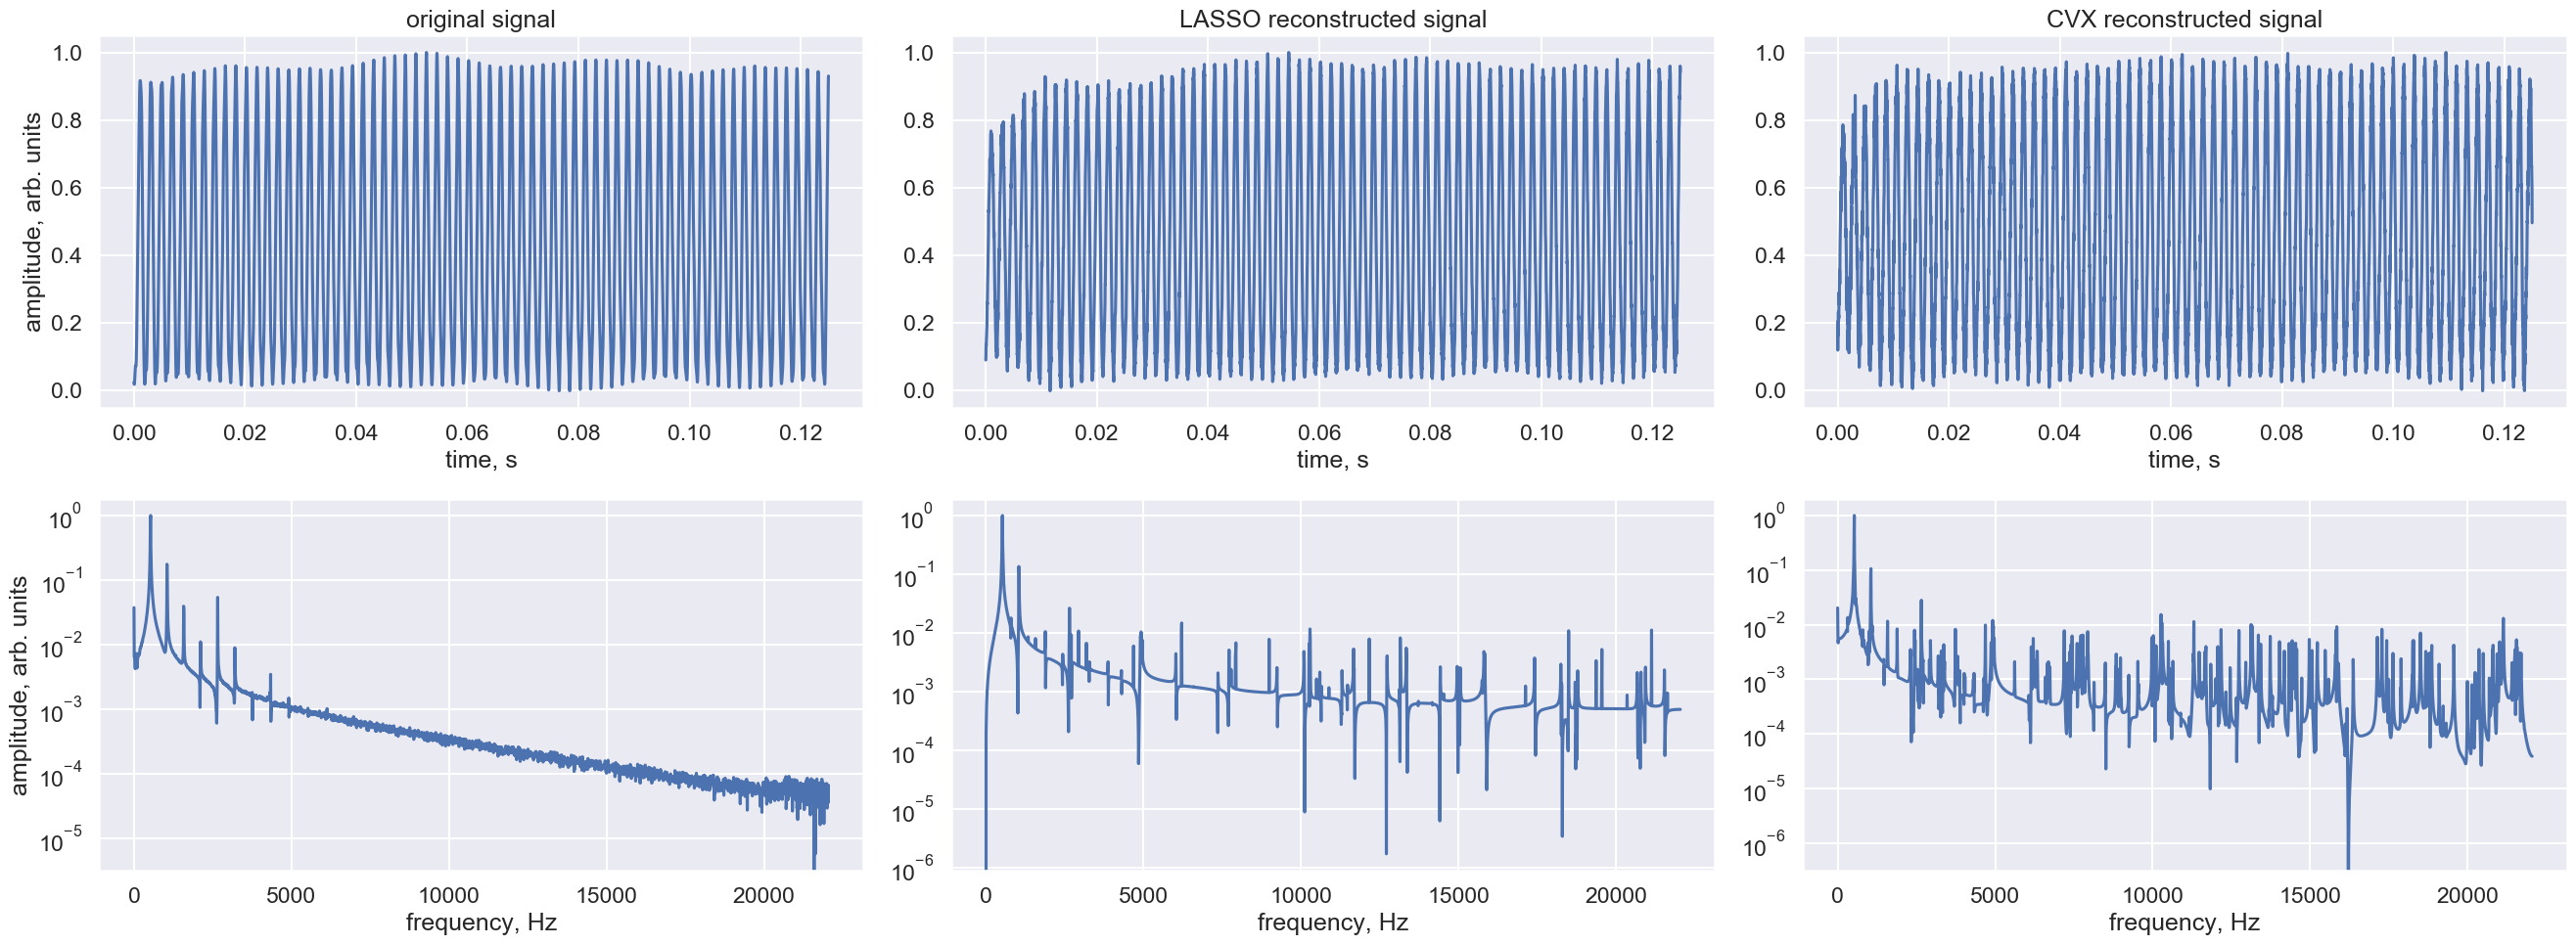

In [33]:
fig,((ax1,ax2,ax3), (ax4,ax5,ax6)) = mp.subplots(nrows=2, ncols=3, figsize=(5*3*16/9, 5*2))

ax1.plot(t, normalize(x))
ax1.set_xlabel("time, s")
ax1.set_ylabel("amplitude, arb. units")
ax1.set_title("original signal")

ax2.plot(t, normalize(x_las))
ax2.set_xlabel("time, s")
# ax2.set_ylabel("amplitude")
ax2.set_title("LASSO reconstructed signal")

ax3.plot(t, normalize(x_cvx))
ax3.set_xlabel("time, s")
# ax3.set_ylabel("amplitude")
ax3.set_title("CVX reconstructed signal")

f = np.linspace(0, samprate, N)

ax4.plot(f[:N//2], normalize(abs(fft.fft(x))[:N//2]))
ax4.set_xlabel("frequency, Hz")
ax4.set_ylabel("amplitude, arb. units")
ax4.set_yscale('log')

ax5.plot(f[:N//2], normalize(abs(fft.fft(x_las))[:N//2]))
ax5.set_xlabel("frequency, Hz")
# ax5.set_ylabel("amplitude")
# ax5.set_ylim(1e3, 6e6)
ax5.set_yscale('log')

ax6.plot(f[:N//2], normalize(abs(fft.fft(x_cvx))[:N//2]))
ax6.set_xlabel("frequency, Hz")
# ax6.set_ylabel("amplitude")
# ax6.set_ylim(5e0, 1e5)
ax6.set_yscale('log')

mp.tight_layout()
# mp.savefig("RSCS-3/reconstruction_methods.png", dpi=300, bbox_inches="tight")
mp.show()

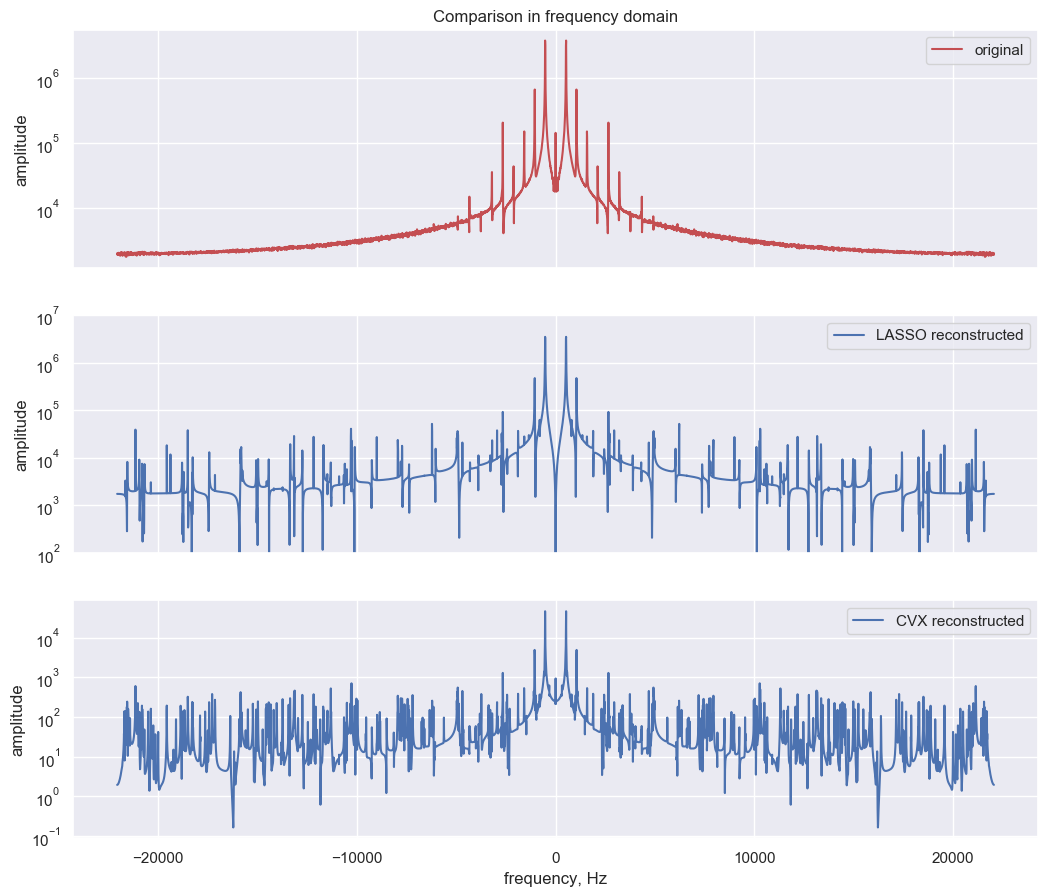

In [13]:
fig,(ax1,ax2,ax3) = mp.subplots(nrows=3, ncols=1, sharex=True, figsize=(7*16/9,7*1.5))

ax1.plot(f, (np.fft.fftshift(abs(fft.fft(x)))),"r", label="original")
ax1.set_ylabel("amplitude")
ax1.set_title("Comparison in frequency domain")
ax1.set_yscale('log')
ax1.legend()

ax2.plot(f, (np.fft.fftshift(abs(fft.fft(x_las)))),"b",label="LASSO reconstructed")
ax2.set_ylim(1e2, 1e7)
ax2.set_yscale('log')
ax2.set_ylabel("amplitude")
ax2.legend()

ax3.plot(f, (np.fft.fftshift(abs(fft.fft(x_cvx)))),"b",label="CVX reconstructed")
ax3.set_xlabel("frequency, Hz")
ax3.set_yscale('log')
ax3.set_ylabel("amplitude")
# ax3.set_ylim(1e0, 1e5)
ax3.legend()

# mp.savefig("RSCS-3/frequency_comparison.png", dpi=300, bbox_inches="tight")
mp.show()

In [14]:
ftorig = fft.fft(x)
ftlas = fft.fft(x_las)
ftcvx = fft.fft(x_cvx)
peakorig = np.argmax(ftorig[:len(ftorig)//2])/len(ftorig)*samprate
peaklas = np.argmax(ftlas[:len(ftlas)//2])/len(ftlas)*samprate
peakcvx = np.argmax(ftcvx[:len(ftcvx)//2])/len(ftcvx)*samprate
print("original frequency = %.5f Hz"%peakorig)
print("LASSO reconstructed frequency = %.5f Hz"%peaklas)
print("CVX reconstructed frequency = %.5f Hz"%peakcvx)

original frequency = 528.04790 Hz
LASSO reconstructed frequency = 528.04790 Hz
CVX reconstructed frequency = 520.04717 Hz


In [16]:
mselas = skm.mean_squared_error(normalize(x), normalize(x_las))
msecvx = skm.mean_squared_error(normalize(x), normalize(x_cvx))
print(f"Mean squared error (LASSO method) = {mselas}")
print(f"Mean squared error (CVX method) = {msecvx}")

Mean squared error (LASSO method) = 0.0028208445645812375
Mean squared error (CVX method) = 0.07356342188353027


## Using window function

In [68]:
N = len(x_las)
n = np.arange(N)

def window_sine(n):
    return np.sin(np.pi*n/(N-1))

def window_blackman(n):
    a0 = 7938/18608
    a1 = 9240/18608
    a2 = 1430/18608
    return a0 - a1*np.cos(2*np.pi*n/(N-1)) + a2*np.cos(4*np.pi*n/(N-1))

def window_bartlett(n):
    a0 = 0.62
    a1 = 0.48
    a2 = 0.38
    return a0 - a1*np.abs(n/(N-1) - 1/2) - a2*np.cos(2*np.pi*n/(N-1))

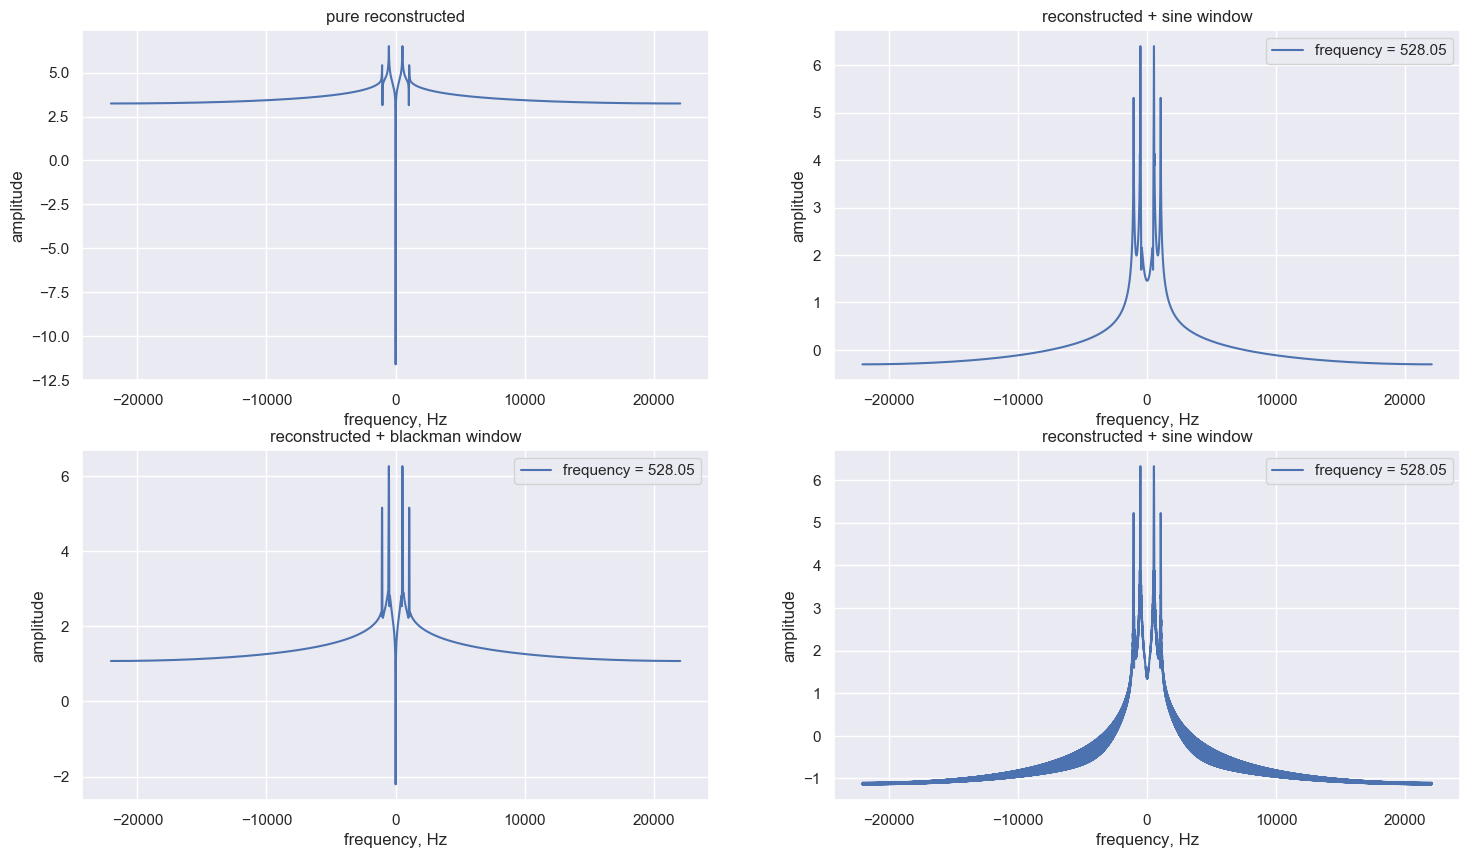

In [72]:
fig,((ax1,ax2),(ax3,ax4)) = mp.subplots(nrows=2, ncols=2, figsize=(5*16/9*2,5*2))

ax1.plot(f, np.log10(np.fft.fftshift(abs(fft.fft(x_las)))))
ax1.set_xlabel("frequency, Hz")
ax1.set_ylabel("amplitude")
ax1.set_title("pure reconstructed")

xwind = x_las*window_sine(n)
xcoef = fft.fft(xwind)
ax2.plot(f, np.log10(np.fft.fftshift(abs(fft.fft(xwind)))), label="frequency = %.2f"%(np.argmax(xcoef[:len(xcoef)//2])/len(xcoef)*samprate))
ax2.set_xlabel("frequency, Hz")
ax2.set_ylabel("amplitude")
ax2.set_title("reconstructed + sine window")
ax2.legend()

xwind = x_las*window_blackman(n)
xcoef = fft.fft(xwind)
ax3.plot(f, np.log10(np.fft.fftshift(abs(fft.fft(xwind)))), label="frequency = %.2f"%(np.argmax(xcoef[:len(xcoef)//2])/len(xcoef)*samprate))
ax3.set_xlabel("frequency, Hz")
ax3.set_ylabel("amplitude")
ax3.set_title("reconstructed + blackman window")
ax3.legend()

xwind = x_las*window_bartlett(n)
xcoef = fft.fft(xwind)
ax4.plot(f, np.log10(np.fft.fftshift(abs(fft.fft(xwind)))), label="frequency = %.2f"%(np.argmax(xcoef[:len(xcoef)//2])/len(xcoef)*samprate))
ax4.set_xlabel("frequency, Hz")
ax4.set_ylabel("amplitude")
ax4.set_title("reconstructed + sine window")
ax4.legend()

mp.show()

## Effect of random distribution on reconstruction error

In [4]:
duration = 1/32
N = int(duration*samprate)
M = np.arange(50, N+1, 50)
t = np.linspace(0,duration,N)
f1 = 440
signal = np.sin(2*np.pi*f1*t)
print("Total number of samples: %i"%N)

Total number of samples: 1378


### Uniform distribution

Each element from the sample has an equal probability of being chosen. The probability distribution based on the indices of the data sample appears as follows:

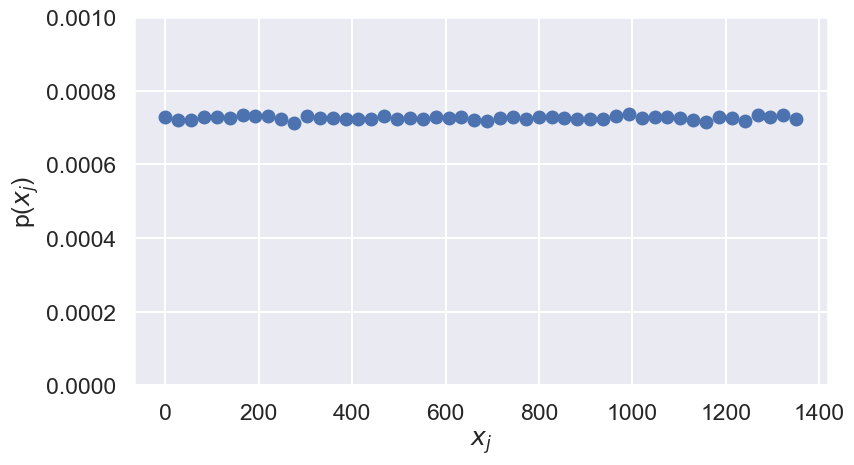

In [56]:
mp.figure(figsize=(5*16/9, 5))

y = rd.uniform(0, N, int(1e6))
hist, bin_edges = np.histogram(y, density=True, bins=50)

mp.plot(bin_edges[:-1], hist, 'o')
mp.xlabel("$x_j$")
mp.ylabel("p($x_j$)")
# mp.title("Uniform random distribution")
mp.ylim(0,0.001)

mp.tight_layout()
# mp.savefig('RSCS-4/uniform_random.png', dpi=300, bbox_inches='tight')
mp.show()

In [5]:
y_uniform_errs = []

for m in tqdm(M):
    trial_err = []
    for i in trange(10, leave=False):
        yi = rd.randint(0,N,m)
        yi = np.sort(yi)
        y_uniform = signal[yi]

        d = np.identity(N)
        d = fft.dct(d)
        A = d[yi]

        lasso = skl.Lasso(alpha=0.1)
        lasso.fit(A,y_uniform)
        xhat_uniform = fft.idct(lasso.coef_)

        mse = skm.mean_squared_error(normalize(signal), normalize(xhat_uniform))
        trial_err.append(mse)
    y_uniform_errs.append(trial_err)
    
y_uniform_errbar = []
y_uniform_errs_mean = []
for i in range(len(y_uniform_errs)):
    y_uniform_errbar.append(np.std(y_uniform_errs[i][:]))
    y_uniform_errs_mean.append(np.mean(y_uniform_errs[i][:]))

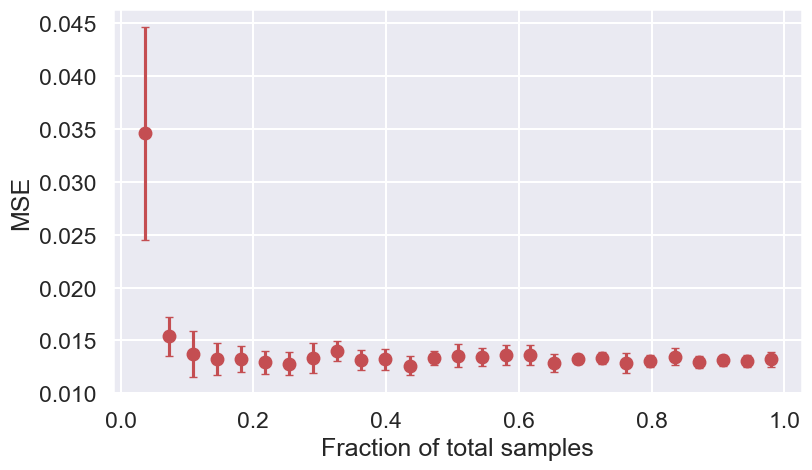

In [6]:
mp.figure(figsize=(5*16/9, 5))
mp.errorbar(M/N, y_uniform_errs_mean, yerr=y_uniform_errbar, xerr=None, fmt="ro", label="uniform", capsize=3)
# mp.title("Uniform")
mp.xlabel("Fraction of total samples")
mp.ylabel("MSE")

# mp.savefig('RSCS-4/uniform_mse.png', dpi=300, bbox_inches='tight')
mp.show()

### Gaussian distribution

Can be generated from the equation

\begin{equation}
    G(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp{\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]}
\end{equation}

where $\sigma$ is the standard deviation, and $\mu$ is the mean.

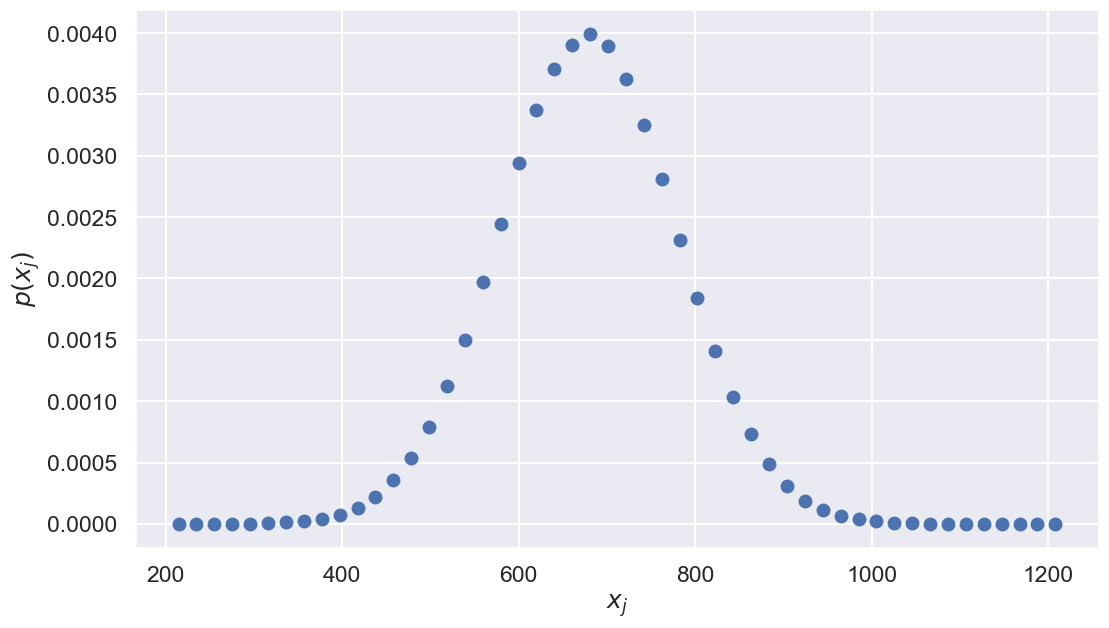

In [62]:
mp.figure(figsize=(7*16/9,7))

sigma = 100
y = rd.normal(np.mean(np.arange(N)), sigma, int(1e6))
hist, bin_edges = np.histogram(y, density=True, bins=50)

mp.plot(bin_edges[:-1], hist, 'o')

mp.xlabel("$x_j$")
mp.ylabel("$p(x_j)$")
# mp.ylim(-0.001, 0.05)
# mp.title("Gaussian random distribution")

# mp.savefig("RSCS-4/gaussian_random.png", dpi=300, bbox_inches="tight")
mp.show()

In [7]:
y_normal_errs = []

for m in tqdm(M):
    trial_err = []
    for i in trange(10, leave=False):
        yi = np.round(rd.normal(np.mean(np.arange(N)), 100, m)).astype(int)
        yi = np.sort(yi)
        y_normal = signal[yi]

        d = np.identity(N)
        d = fft.dct(d)
        A = d[yi]

        lasso = skl.Lasso(alpha=0.1)
        lasso.fit(A,y_normal)
        xhat_normal = fft.idct(lasso.coef_)

        mse = skm.mean_squared_error(xhat_normal, signal)
        trial_err.append(mse)
    y_normal_errs.append(trial_err)
    
y_normal_errbar = []
y_normal_errs_mean = []
for i in range(len(y_normal_errs)):
    y_normal_errbar.append(np.std(y_normal_errs[i][:]))
    y_normal_errs_mean.append(np.mean(y_normal_errs[i][:]))

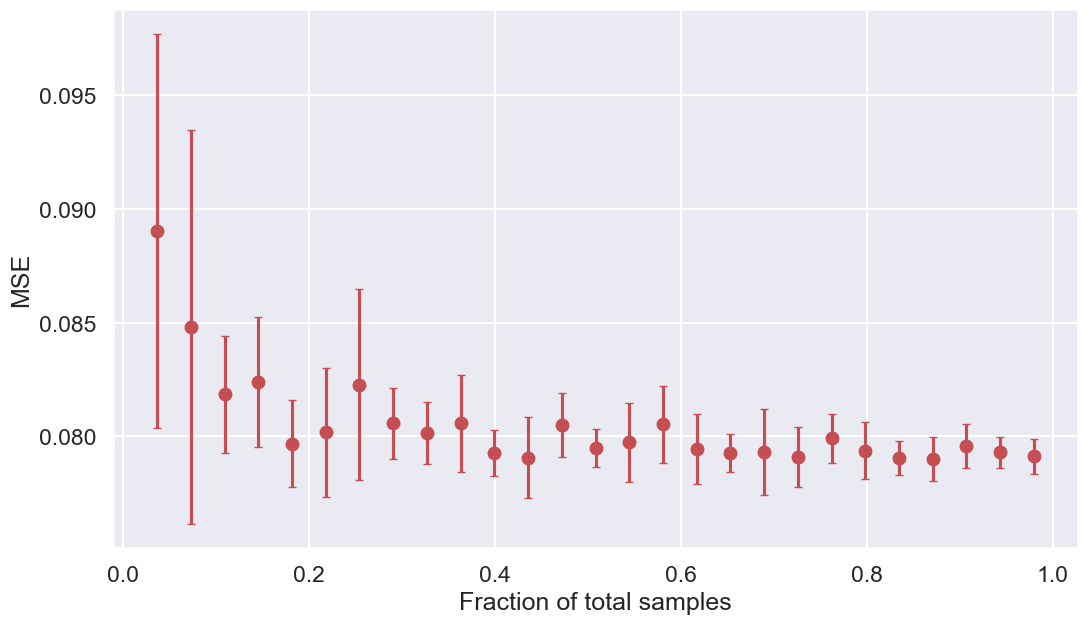

In [8]:
mp.figure(figsize=(7*16/9,7))
mp.errorbar(M/N, y_normal_errs_mean, yerr=y_normal_errbar, xerr=None, fmt="ro", label="Gaussian", capsize=3)
# mp.title("Gaussian")
mp.xlabel("Fraction of total samples")
mp.ylabel("MSE")

# mp.savefig('RSCS-4/gaussian_mse.png', dpi=300, bbox_inches='tight')
mp.show()

### Poisson distribution

given by the equation

\begin{equation}
    P(k) = e^{-\lambda} \frac{\lambda^k}{k!}
\end{equation}

where $k$ is an integer, and

\begin{equation}
    \lambda = \langle x \rangle = \sigma_x^2
\end{equation}


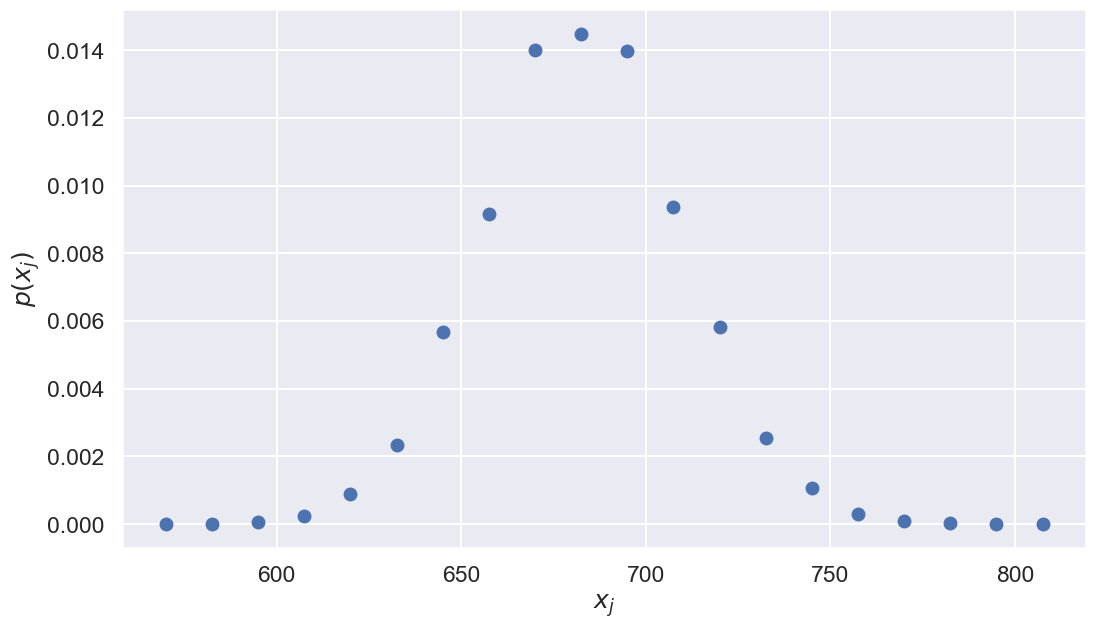

In [66]:
mp.figure(figsize=(7*16/9,7))
lam = 1378//2
y = rd.poisson(lam, int(1e6))
hist, bin_edges = np.histogram(y, density=True, bins=20)

mp.plot(bin_edges[:-1], hist, 'o')

mp.xlabel(r"$x_j$")
mp.ylabel(r"$p(x_j)$")
# mp.title("Poisson random distribution")

# mp.savefig("RSCS-4/poisson_random.png", dpi=300, bbox_inches="tight")
mp.show()

In [9]:
y_poisson_errs = []

for m in tqdm(M):
    trial_err = []
    for i in trange(10, leave=False):
        yi = np.round(rd.poisson(np.mean(np.arange(0,N)), m)).astype(int)
        yi = np.sort(yi)
        y_poisson = signal[yi]

        d = np.identity(N)
        d = fft.dct(d)
        A = d[yi]

        lasso = skl.Lasso(alpha=0.1)
        lasso.fit(A,y_poisson)
        xhat_poisson = fft.idct(lasso.coef_)

        mse = skm.mean_squared_error(normalize(signal), normalize(xhat_poisson))
        trial_err.append(mse)
    y_poisson_errs.append(trial_err)
    
y_poisson_errbar = []
y_poisson_errs_mean = []
for i in range(len(y_normal_errs)):
    y_poisson_errbar.append(np.std(y_poisson_errs[i][:]))
    y_poisson_errs_mean.append(np.mean(y_poisson_errs[i][:]))

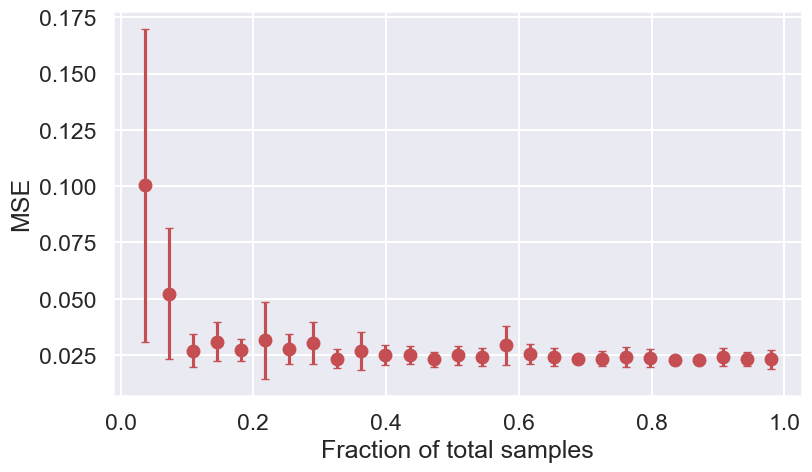

In [10]:
mp.figure(figsize=(5*16/9, 5))
mp.errorbar(M/N, y_poisson_errs_mean, yerr=y_poisson_errbar, xerr=None, fmt="ro", label="Poisson", capsize=3)
# mp.title("Poisson")
mp.xlabel("Fraction of total samples")
mp.ylabel("MSE")
# mp.savefig('RSCS-4/poisson_mse.png', dpi=300, bbox_inches='tight')
mp.show()

### Triangular distribution

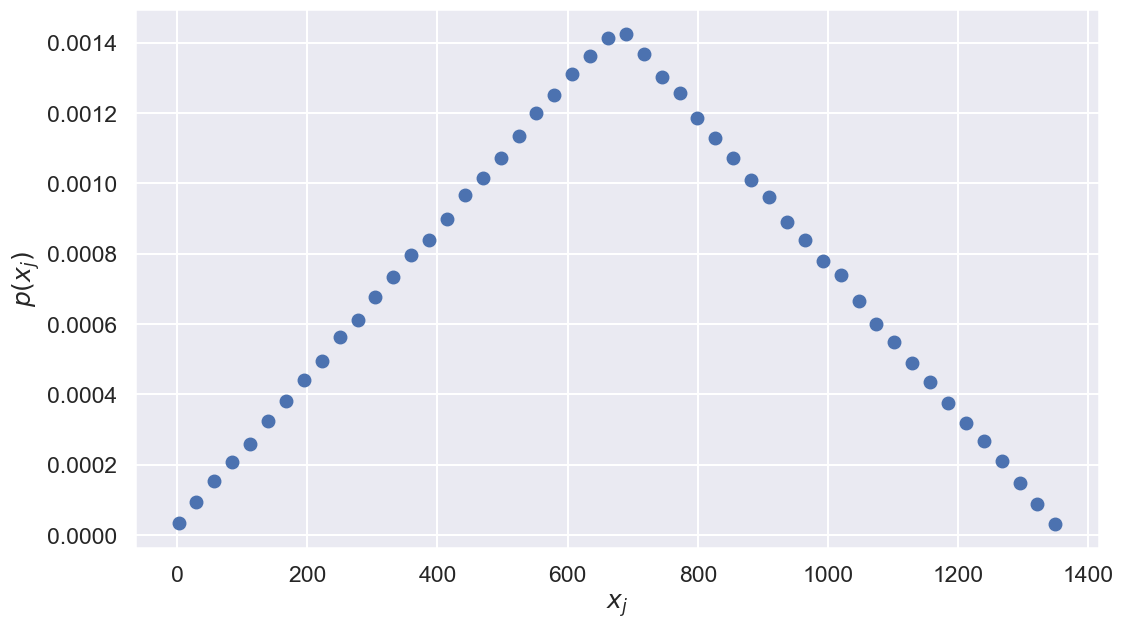

In [71]:
mp.figure(figsize=(7*16/9,7))

y = rd.triangular(0, np.mean(np.arange(0, N)), N, int(1e6))
hist, bin_edges = np.histogram(y, density=True, bins=50)

mp.plot(bin_edges[:-1], hist, 'bo')
mp.xlabel("$x_j$")
mp.ylabel("$p(x_j)$")
# mp.title("Triangular random distribution")

# mp.savefig('RSCS-4/triangular_random.png', dpi=300, bbox_inches='tight')
mp.show()

In [11]:
y_tri_errs = []

for m in tqdm(M):
    trial_err = []
    for i in trange(10, leave=False):
        yi = np.round(rd.triangular(0, np.mean(np.arange(0, N)), N, m)).astype(int)
        yi = np.sort(yi)
        y_tri = signal[yi]

        d = np.identity(N)
        d = fft.dct(d)
        A = d[yi]

        lasso = skl.Lasso(alpha=0.1)
        lasso.fit(A,y_tri)
        xhat_tri = fft.idct(lasso.coef_)

        mse = skm.mean_squared_error(normalize(signal), normalize(xhat_tri))
        trial_err.append(mse)
    y_tri_errs.append(trial_err)
    
y_tri_errbar = []
y_tri_errs_mean = []
for i in range(len(y_tri_errs)):
    y_tri_errbar.append(np.std(y_tri_errs[i][:]))
    y_tri_errs_mean.append(np.mean(y_tri_errs[i][:]))

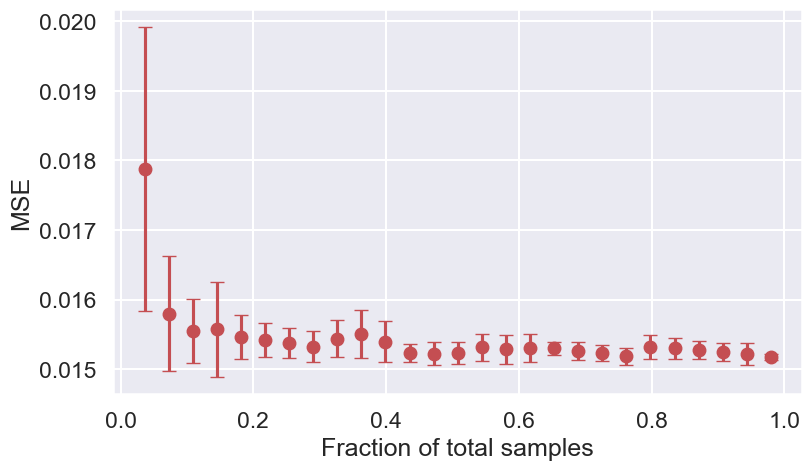

In [12]:
mp.figure(figsize=(5*16/9, 5))
mp.errorbar(M/N, y_tri_errs_mean, yerr=y_tri_errbar, xerr=None, fmt="ro", label="Triangular", capsize=5)
# mp.title("Triangular")
mp.xlabel("Fraction of total samples")
mp.ylabel("MSE")

# mp.savefig('RSCS-4/triangular_mse.png', dpi=300, bbox_inches='tight')
mp.show()

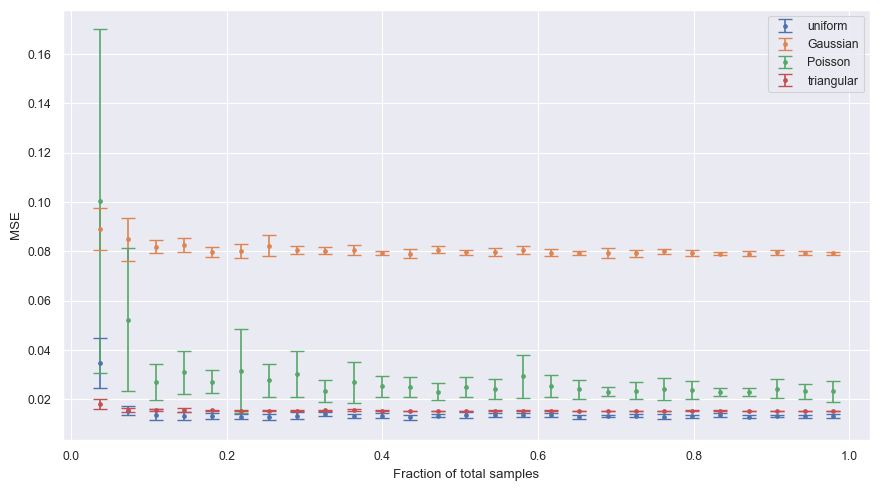

In [17]:
# sns.set_context('paper')
means = [y_uniform_errs_mean, y_normal_errs_mean, y_poisson_errs_mean, y_tri_errs_mean]
errors = [y_uniform_errbar, y_normal_errbar, y_poisson_errbar, y_tri_errbar]
labels = ['uniform', 'Gaussian', 'Poisson', 'triangular']

mp.figure(figsize=(5*16/9, 5))
for mean, error, label in zip(means, errors, labels):
    mp.errorbar(M/N, mean, error, None, '.', label=label, capsize=5)

mp.xlabel("Fraction of total samples")
mp.ylabel("MSE")
mp.legend()
mp.tight_layout()
mp.savefig('RSCS-4/random_mse.png', dpi=300, bbox_inches='tight')
mp.show()

### Gaussian distribution with varying $\sigma$

In [78]:
sigma = np.concatenate(([1], np.arange(10, 101, 10)))

s_avglist = []
s_stdlist = []
for sd in tqdm(sigma):
    m_avglist = []
    for m in tqdm(M, leave=False):
        mselist = [] 
        for i in trange(5, leave=False):
            yi = np.round(rd.normal(np.mean(np.arange(N)), sd, m)).astype(int)
            yi = np.sort(yi)
            y_normal = signal[yi]
            d = np.identity(N)
            d = fft.dct(d)
            A = d[yi]
            lasso = skl.Lasso(alpha=0.01)
            lasso.fit(A, y_normal)
            xhat_normal = fft.idct(lasso.coef_)
            mse = skm.mean_squared_error(normalize(signal), normalize(xhat_normal))
            mselist.append(mse)
        m_avglist.append(np.mean(mselist))
    s_avglist.append(np.mean(m_avglist))
    s_stdlist.append(np.std(m_avglist))

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.768838887445355e-05, tolerance: 7.004851359182799e-06
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4183498692595109e-05, tolerance: 8.154102008797524e-06
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.044125149097513e-05, tolerance: 1.0083403665125218e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6859742072011675e-05, tolerance: 2.1071430601908106e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6394118974498605e-05, tolerance: 2.4004470864184285e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.721627983906822e-05, tolerance: 2.0756690443730268e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. Y

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0991346428837236e-05, tolerance: 2.864971859656033e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.683486174498347e-05, tolerance: 2.5869662512452714e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7746237675584955e-05, tolerance: 3.006832188718715e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.46937203725362e-05, tolerance: 4.4680047369138674e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.101600914779377e-05, tolerance: 4.122318212744636e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.418534702110456e-05, tolerance: 3.4973620256656995e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You m

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.082430543874779e-05, tolerance: 4.675681684695844e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.32758753677651e-05, tolerance: 4.9922978997236e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.03271357093477e-05, tolerance: 4.970718024117021e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010162882831016296, tolerance: 5.743918757332637e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013460315647063903, tolerance: 7.126949065825097e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010897246924056886, tolerance: 6.432588311345082e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012442058136054313, tolerance: 7.106904812780672e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012887380293531703, tolerance: 7.170341011499156e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014058166569107244, tolerance: 7.486460270745971e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001415182603876075, tolerance: 8.236876887261566e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016025923086684934, tolerance: 8.97734303330406e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016378348721725333, tolerance: 8.671059052786978e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You m

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018474484335027908, tolerance: 0.00010233234818555632
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014722852896606464, tolerance: 8.766370559885497e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001584204139362111, tolerance: 8.781021295583785e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001935556189658072, tolerance: 0.00010708051108399439
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017985139310064402, tolerance: 9.993913748833202e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002078723802490523, tolerance: 0.00011122156178099734
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019556212059657074, tolerance: 0.00010762549851111467
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002078143828280199, tolerance: 0.00011963353368294034
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001850401962531223, tolerance: 0.00010291594924503654
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. Yo

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023580516817177377, tolerance: 0.0001244623674685818
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024280701034126717, tolerance: 0.00013339421422236717
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020908900633972993, tolerance: 0.00012074518562110953
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. Y

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002544430910766393, tolerance: 0.0001385456003393293
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002589664722111029, tolerance: 0.00014199130671543037
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022764416078957517, tolerance: 0.0001240160640175281
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025294135864503686, tolerance: 0.00014082056340566194
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028254593056892263, tolerance: 0.00016023917012822778
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030704747981924463, tolerance: 0.00016875804862200464
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000289421691406333, tolerance: 0.00015895354981387158
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002885099857120321, tolerance: 0.00016182776321191665
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028169891874593733, tolerance: 0.0001615856403440273
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030473556696475335, tolerance: 0.00017382824513447641
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000301901519197012, tolerance: 0.00017695340248128982
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029642125326811986, tolerance: 0.00016572982223119967
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. Yo

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031343425266938674, tolerance: 0.0001742849878131728
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003246839462118234, tolerance: 0.00018279865666455617
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003308036574898865, tolerance: 0.00018876981594766876
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030909334855103165, tolerance: 0.00017292679638591368
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037388753445105616, tolerance: 0.00020907576447259257
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039630654854416747, tolerance: 0.00020173366431722504
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003362258525561046, tolerance: 0.00018238124477814148
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003391109215825916, tolerance: 0.0001977926376728364
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003931520805492139, tolerance: 0.000211857268178202
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039818241390768283, tolerance: 0.0002194078675415514
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043776662833500124, tolerance: 0.00024038657391236111
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003608525707514132, tolerance: 0.00019986719520565703
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. Yo

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004123091702386561, tolerance: 0.00023549642750016179
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004446703559888576, tolerance: 0.00024081032664299926
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037944291692931786, tolerance: 0.00021954400656248247
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. Yo

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003889377830105234, tolerance: 0.00021833085644472236
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043887207678305895, tolerance: 0.0002355913256779033
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039367701584336334, tolerance: 0.00021745883719040055
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. Yo

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004385104687049668, tolerance: 0.00024391092851069543
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004255886490455163, tolerance: 0.0002364690944849902
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038944212728198035, tolerance: 0.00022908409431939532
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043046929612095, tolerance: 0.0002494402376327971
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005103317680613673, tolerance: 0.0002686365592806422
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004899599640654784, tolerance: 0.00026626552415265705
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004706551507240586, tolerance: 0.000256832482831415
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004898533562034402, tolerance: 0.00026850260841561503
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004672023606568654, tolerance: 0.00025914209264806475
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You m

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000467762391247184, tolerance: 0.000267646551097815
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047309274777801447, tolerance: 0.00027252292483446235
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047937043361695464, tolerance: 0.00027405543086052867
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004939602014916167, tolerance: 0.00029223064704291793
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004745476207250743, tolerance: 0.0002765825657316
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005188547800604737, tolerance: 0.0002862583740733815
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013933521977324836, tolerance: 0.0005716290284328927
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001240591072023102, tolerance: 0.0008856594031533199
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023390665632774255, tolerance: 0.0012394017790429508
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002934004520558836, tolerance: 0.001871972018898175
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001909957244486088, tolerance: 0.001664373457658298
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003275332609614351, tolerance: 0.0023848476472169114
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005930985823932866, tolerance: 0.0024619132440041173
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002886526129810857, tolerance: 0.002742615618436915
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00424866214267805, tolerance: 0.00371748476450946
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004461189216402456, tolerance: 0.0029215651294442896
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004662019667179107, tolerance: 0.003231765167270774
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004684034305821427, tolerance: 0.004122710575513402
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007749126980297949, tolerance: 0.0035415439006992503
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007233541119559872, tolerance: 0.003765381451325974
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010878833658866771, tolerance: 0.005878228286961947
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009363785389895407, tolerance: 0.004352381708967187
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010570493784682, tolerance: 0.004562700143997448
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01179165250404679, tolerance: 0.005813818831686656
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010227304990338137, tolerance: 0.005360318960283365
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007786968748220491, tolerance: 0.005671657559507308
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013104515508962966, tolerance: 0.006294676322633097
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009810909109054133, tolerance: 0.006421876253774497
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008886760019197804, tolerance: 0.006081598348610752
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012874514430344264, tolerance: 0.00679624039832398
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014580336562091789, tolerance: 0.007345010830037285
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014176484972869052, tolerance: 0.007744955733740874
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00915745560532627, tolerance: 0.008644938551379747
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01352266998553886, tolerance: 0.007677859277325096
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01156784924036125, tolerance: 0.007593903548961626
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010149757657098968, tolerance: 0.009434432139856236
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00937448867186308, tolerance: 0.009070894527480944
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0195111292489204, tolerance: 0.009009813900265366
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019748049242428123, tolerance: 0.009900206741205543
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011476086110410011, tolerance: 0.010943152754468178
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019709740062718195, tolerance: 0.01010801878192517
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019244209988326766, tolerance: 0.01018761893134373
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019796850577462166, tolerance: 0.01043661875724031
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012709295644581897, tolerance: 0.010918176763672615
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016832818896682422, tolerance: 0.010193910582662604
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023702585859412206, tolerance: 0.010983265807481433
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01530252307345148, tolerance: 0.012625817196513699
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021282622959354236, tolerance: 0.012385889003332035
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012122890783490936, tolerance: 0.01202582566891463
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015376836855560905, tolerance: 0.01098853561845719
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026120790517192738, tolerance: 0.013007075319229521
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01931277004633869, tolerance: 0.012309876227888433
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012928060942436925, tolerance: 0.011694860289599585
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019378280930630654, tolerance: 0.014699470144303157
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016615956388374098, tolerance: 0.013096339174076625
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020903892002333002, tolerance: 0.013839932995633587
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021786001261336452, tolerance: 0.014113906080407999
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021018171026064625, tolerance: 0.014896984876177095
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02382943907220003, tolerance: 0.013743294069943306
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02903070541874342, tolerance: 0.015274631278209959
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01828921988761012, tolerance: 0.015188434274076661
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029160309969623044, tolerance: 0.01628487717459745
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01860972252482762, tolerance: 0.016002794746745434
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0331933670040887, tolerance: 0.016010571475690218
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0328249252652264, tolerance: 0.016808942614320675
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019851144269346976, tolerance: 0.018278223284604222
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03596223958316003, tolerance: 0.016953232056959512
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020232106795970095, tolerance: 0.017522458885838598
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035001114114580956, tolerance: 0.01734339659161157
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029444763275455088, tolerance: 0.0188843606135985
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03788557070661813, tolerance: 0.01802588593669627
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02380644647454666, tolerance: 0.01729567199153959
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027015398701133453, tolerance: 0.019456832455886888
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030590611725548222, tolerance: 0.01858423925809496
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021404936417348752, tolerance: 0.019205359054597672
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020937539208123912, tolerance: 0.02073432256420783
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023163494192861567, tolerance: 0.019036835881917024
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04584299384246093, tolerance: 0.02034330623933822
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043508223688626835, tolerance: 0.019946650378875698
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03336613764681706, tolerance: 0.021036705534867115
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025422223560386703, tolerance: 0.02051144036037296
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02708673888665092, tolerance: 0.020398718559227695
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04621505006769633, tolerance: 0.021030924461013453
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02706556310418451, tolerance: 0.023219316254746717
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023138424711994787, tolerance: 0.022535146860750234
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0274248941309736, tolerance: 0.0228638828937354
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003965357309763218, tolerance: 0.0019254308394552233
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027612625248961443, tolerance: 0.0021453948970556773
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026319054336874682, tolerance: 0.0016579241985857558
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006913661128384792, tolerance: 0.0044768698243042365
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005253461206821013, tolerance: 0.003847958399938213
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004643050014539095, tolerance: 0.003674188691269828
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006308325078931171, tolerance: 0.005127666225410665
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00897421236135506, tolerance: 0.005733782586695807
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006153308970157943, tolerance: 0.006096486527571696
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0073503923159129875, tolerance: 0.0071924164690408575
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008250082592445689, tolerance: 0.007214399932891599
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009731819029013739, tolerance: 0.006844197002701994
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011567016355452528, tolerance: 0.009439120034031306
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011540594628918224, tolerance: 0.01019765954383643
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015601153814781915, tolerance: 0.01538776788257564
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016085657303728657, tolerance: 0.013943685271909138
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016674297022992147, tolerance: 0.016220754510309025
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017086673673145897, tolerance: 0.015204116835135688
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020722284787473177, tolerance: 0.016342963612230234
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023232349980375155, tolerance: 0.019497741939673945
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024758260769358262, tolerance: 0.021517362586156847
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027210778394468657, tolerance: 0.022562743562993617
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03201065370231734, tolerance: 0.025446082445657
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031908023196786706, tolerance: 0.02657821545935582
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0355925587232961, tolerance: 0.031463211863251586
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039944910515240295, tolerance: 0.03343016538850444
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03390902391553546, tolerance: 0.03293190906191619
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04004849667409127, tolerance: 0.036783708895495114
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040994860172803904, tolerance: 0.04005565505457112
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052249900932271026, tolerance: 0.03779852379798541
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05096079387159336, tolerance: 0.04306343014941154
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053830310798204245, tolerance: 0.044091522448325836
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05447226817366918, tolerance: 0.04471148599586765
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06591024855076366, tolerance: 0.049229640189965666
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05333141896212823, tolerance: 0.04575316581874937
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0560761319380082, tolerance: 0.04769095136330575
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05106648150261739, tolerance: 0.05102187884315865
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05205187966799707, tolerance: 0.051952620286389986
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005597192785504785, tolerance: 0.005093618128155309
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006450312224253766, tolerance: 0.004926273590795179
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009012491678168255, tolerance: 0.007404124051065318
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007153070860847682, tolerance: 0.0069704754415107146
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009867792242480557, tolerance: 0.00907498975902979
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012257301179395233, tolerance: 0.009892758139013717
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010044574181698851, tolerance: 0.009466307070861511
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01366976003718396, tolerance: 0.011774479674418727
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013957132475699005, tolerance: 0.012995641122091183
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016411026599410836, tolerance: 0.015201079198402832
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019352065797757056, tolerance: 0.013835302426216504
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022245230199976124, tolerance: 0.019813683329519678
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0214695950216685, tolerance: 0.020165430814209725
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022862469931922362, tolerance: 0.02238502259358076
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03463135996499492, tolerance: 0.03276401423285001
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03545275641646954, tolerance: 0.03187258452129573
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04542622831396449, tolerance: 0.04084908597991452
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04906810069232853, tolerance: 0.043145956201504465
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04466015400054653, tolerance: 0.03972524080919078
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0456092508466321, tolerance: 0.04121330523132995
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05286415583479223, tolerance: 0.04769172434149031
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06211456419855847, tolerance: 0.05401761685210944
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0608041538673601, tolerance: 0.059548998821203764
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06042383625051159, tolerance: 0.05879103780461094
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07190839963495665, tolerance: 0.062040897849307636
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06017932726636627, tolerance: 0.05947851690953623
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06691096057802665, tolerance: 0.062027909444075206
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0749506042167864, tolerance: 0.06606179486092598
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037260736180195183, tolerance: 0.0026278823879216325
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003449532873652737, tolerance: 0.002470404960922767
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002308422344471074, tolerance: 0.002293736562032672
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006328760470146319, tolerance: 0.004726891621387877
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005982060300756004, tolerance: 0.005262932459818203
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009914467891294028, tolerance: 0.007705375698145267
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009793100990998706, tolerance: 0.007436145921356061
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013221532053162177, tolerance: 0.010246704364609198
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015248098180622623, tolerance: 0.012043817310634763
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02036316659745009, tolerance: 0.01430177276125653
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025745117437067436, tolerance: 0.01995969970205183
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041942405477554734, tolerance: 0.03179418474328578
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04384069901554723, tolerance: 0.03450474079282681
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06485050484544212, tolerance: 0.04878305009346223
  positive)


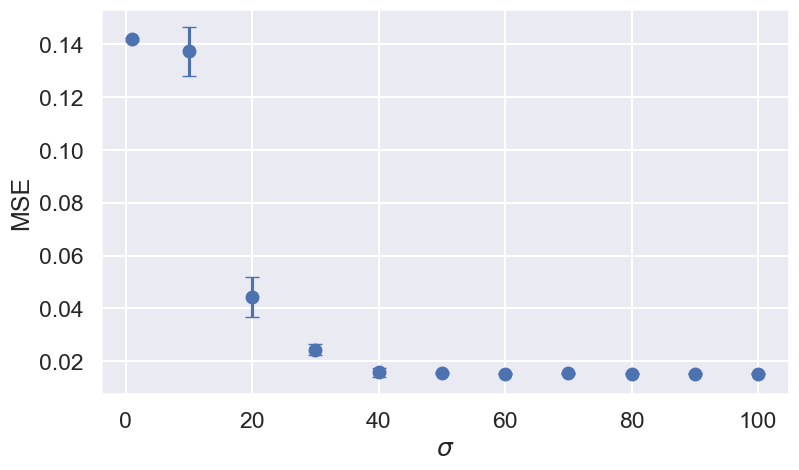

In [83]:
mp.figure(figsize=(5*16/9, 5))
mp.errorbar(sigma, s_avglist, yerr=s_stdlist, xerr=None, fmt="o", capsize=5)
# mp.title("Gaussian")
mp.xlabel("$\sigma$")
mp.ylabel("MSE")

# mp.savefig("RSCS-4/gaussian_sigma.png", dpi=300, bbox_inches="tight")
mp.show()

### Poisson distribution with varying $\lambda$

In [163]:
lamda = np.arange(300, 1101, 50)
s_avglist = []
s_stdlist = []

for lam in tqdm(lamda):
    m_avglist = []
    for m in tqdm(M, leave=False):
        mselist = []
        for i in trange(10, leave=False):
            yi = np.round(rd.poisson(lam,m)).astype(int)
            yi = np.sort(yi)
            y_poisson = signal[yi]
            d = np.identity(N)
            d = fft.dct(d)
            A = d[yi]
            lasso = skl.Lasso(alpha=0.01)
            lasso.fit(A,y_poisson)
            xhat_poisson = fft.idct(lasso.coef_)
            mse = skm.mean_squared_error(normalize(signal), normalize(xhat_poisson))
            mselist.append(mse)
            
        m_avglist.append(np.mean(mselist))
        
    s_avglist.append(np.mean(m_avglist))
    s_stdlist.append(np.std(m_avglist))

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036724353298019513, tolerance: 0.002243329385739546
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028699676128972887, tolerance: 0.0028473570846658377
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028768559979094766, tolerance: 0.0024743920282529696
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009202947003386355, tolerance: 0.0044321625623575936
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006824783852426068, tolerance: 0.0043350467493527035
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008244717948514795, tolerance: 0.004055122146010177
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008931137125062945, tolerance: 0.007297774469014804
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010379831023559067, tolerance: 0.007826059042461267
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01097083354607702, tolerance: 0.0074466315823976306
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013293748062374523, tolerance: 0.008620919194152595
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01413099032237216, tolerance: 0.009506013381846654
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015850689480163358, tolerance: 0.00996582049251644
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017115912698807138, tolerance: 0.01048425830466127
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01820900322820187, tolerance: 0.011994239283978705
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017011101640250527, tolerance: 0.011539948775601865
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024118129775442993, tolerance: 0.014495049875520343
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016544947273739855, tolerance: 0.013035928377093237
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02265509911748353, tolerance: 0.014449408617427674
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028593890397697524, tolerance: 0.016095734659383274
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03041366271675007, tolerance: 0.01615674407867047
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024989339494919938, tolerance: 0.01603922048072543
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027449570853151764, tolerance: 0.017540833107288253
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03147118299695108, tolerance: 0.018281501608037324
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02908084971120907, tolerance: 0.017870227834698597
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03488311982902241, tolerance: 0.020288007382783173
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033672107488181655, tolerance: 0.021423087104782277
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03540064919422087, tolerance: 0.020516125225198894
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03822151025412614, tolerance: 0.02278116213330411
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043592764732372544, tolerance: 0.02218896926785749
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040400123815313285, tolerance: 0.022855647487758195
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04806832693742914, tolerance: 0.027239250146483235
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03785592923928635, tolerance: 0.024440180861566064
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04663480416817879, tolerance: 0.02507924285094995
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05353297938229379, tolerance: 0.02822303855785222
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04801833110519381, tolerance: 0.028362084488301877
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04938740655227876, tolerance: 0.028224143609331117
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05148328173987421, tolerance: 0.02958434084915254
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056195523546321326, tolerance: 0.030191176921656064
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04978168473328823, tolerance: 0.029797979576938402
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06015978091724951, tolerance: 0.03425632827557082
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05339190265139898, tolerance: 0.03271931502490917
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056536050148898676, tolerance: 0.03247514810370002
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05612493173033571, tolerance: 0.03430667347577743
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05825263333286365, tolerance: 0.036173986170366906
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06460702713934124, tolerance: 0.03647754542758005
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06653246876119945, tolerance: 0.03823517911626335
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06544444784552772, tolerance: 0.03599923416505151
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07004083518831972, tolerance: 0.036620265695135476
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07719498113443211, tolerance: 0.04085471242362016
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07477748926245642, tolerance: 0.03835021010059721
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06729215689440132, tolerance: 0.03891354464518015
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0801989162680627, tolerance: 0.04240080441939296
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07878681282679093, tolerance: 0.0440742648088069
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07636076044425327, tolerance: 0.0414138814923829
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07906614466606968, tolerance: 0.0422649598106626
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08061524340191688, tolerance: 0.045983964733936795
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07732153412572373, tolerance: 0.04436836306951869
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08823658657648105, tolerance: 0.04521937533678162
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08455244570314135, tolerance: 0.046310663769763
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0806601052731788, tolerance: 0.046077772799395234
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09193857944604505, tolerance: 0.05001690931852475
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08616281519025752, tolerance: 0.048390394543721515
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0867236832596856, tolerance: 0.048700010334788914
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09202065636085718, tolerance: 0.05531991126160867
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0828075800475879, tolerance: 0.05281400803890297
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09097254981058459, tolerance: 0.05167868014356501
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to i

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10133979758297082, tolerance: 0.05453064655628307
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09685309163371833, tolerance: 0.05225070407358759
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09392087603637438, tolerance: 0.05432749480431934
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09947408174823, tolerance: 0.05392450669875141
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1014039254359486, tolerance: 0.05601933004584257
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10110198982899452, tolerance: 0.05663599555295647
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11082279492973623, tolerance: 0.0598464709256285
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11031118675090393, tolerance: 0.059017347951977585
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10810014559810646, tolerance: 0.05843980621111134
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10256408266507525, tolerance: 0.0604174542204416
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11305128158175387, tolerance: 0.0602448281872359
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11328119940334386, tolerance: 0.059038431887929156
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to i

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1192063933961333, tolerance: 0.06272754681465334
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1166916915403807, tolerance: 0.06376725975360975
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11139122839885542, tolerance: 0.06279565753714494
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003342707412984782, tolerance: 0.00271079933080965
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002357444171974305, tolerance: 0.0018020072012048492
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028699332450777947, tolerance: 0.0023716930284879314
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005584911795500046, tolerance: 0.004584370069401839
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005505649281794441, tolerance: 0.0046762149832558384
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005336240861043973, tolerance: 0.00459880191675095
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007903593560410361, tolerance: 0.006887295061035468
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008784874205563772, tolerance: 0.007475650861551391
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008246761905572808, tolerance: 0.006837685184362901
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011053708571183027, tolerance: 0.009744389478805708
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009871957913942164, tolerance: 0.009602931207637609
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010178144659945675, tolerance: 0.008888907149620222
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015212693341410483, tolerance: 0.012906827016128884
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012894496678598856, tolerance: 0.011706734960009986
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015082313856043639, tolerance: 0.012850988473817911
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01575282080727259, tolerance: 0.014369371527740166
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01692957928182741, tolerance: 0.014493960492815934
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016403936314947673, tolerance: 0.013816493972169684
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019718713278652135, tolerance: 0.01801142874884916
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01938835509351042, tolerance: 0.016147683768042286
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020191656346788864, tolerance: 0.018043989724292296
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02293306795241272, tolerance: 0.020146058669633853
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02045595525910572, tolerance: 0.018293097433923947
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02173426131673411, tolerance: 0.018493846116781863
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025255450748712216, tolerance: 0.02284525686759216
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024898132652275237, tolerance: 0.02093759741396525
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025407639697188955, tolerance: 0.02218232017568535
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0273477161363829, tolerance: 0.02393631999819061
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029541911261077178, tolerance: 0.025482786414798855
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027654742505758667, tolerance: 0.022753631505366075
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03036703759807187, tolerance: 0.026885325245027663
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03131383417686052, tolerance: 0.029122415795787487
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029358471340092965, tolerance: 0.027075518444242712
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032257972879140374, tolerance: 0.028663624044860933
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03611912439967549, tolerance: 0.029495356420719872
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03132056958611891, tolerance: 0.0280689332106272
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036161660636152795, tolerance: 0.032917326324473674
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037856220301686, tolerance: 0.033264303453064775
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03548567876645565, tolerance: 0.030918832306259282
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038219683960505846, tolerance: 0.03363874127721883
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03665869542506712, tolerance: 0.032061131642080694
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04046014381665966, tolerance: 0.03437822935596783
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04289769242237025, tolerance: 0.037201569353911855
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043605499456830406, tolerance: 0.03823509313671437
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04220998601444769, tolerance: 0.03591271387832686
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.047282344543405255, tolerance: 0.04013648022552337
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045413974653505634, tolerance: 0.03838302964496606
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04652649978393128, tolerance: 0.03878243601505297
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04665155864731063, tolerance: 0.0398972206137162
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04858821334152816, tolerance: 0.03996463300876886
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.047386142614041754, tolerance: 0.040908350433830606
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05213238847193638, tolerance: 0.042632189276222573
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053159636735241156, tolerance: 0.04501917725369862
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04980280183980275, tolerance: 0.043991099745200046
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05265479579994285, tolerance: 0.04586497551549092
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05232796096255041, tolerance: 0.04722598909179433
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05192212147162359, tolerance: 0.046014626265995985
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055803177862324374, tolerance: 0.0477525293597998
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05404015299849549, tolerance: 0.04672547221772296
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0584637482892722, tolerance: 0.04862436332924422
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to i

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.061634595481692867, tolerance: 0.05312631702263268
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06157105527405743, tolerance: 0.0508478752424978
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059717403865329116, tolerance: 0.051233027911832
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to i

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06035884251807483, tolerance: 0.053769154051897014
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06293394458300725, tolerance: 0.055461387748242524
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06490103694558352, tolerance: 0.05459475884361114
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0661783190614317, tolerance: 0.05592961164605474
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06678794097913093, tolerance: 0.05655385206173454
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06538018909870236, tolerance: 0.0554948094532616
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06752612868836914, tolerance: 0.05826323621717414
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06769526213874572, tolerance: 0.059503244168376025
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.067858905531129, tolerance: 0.05955648935766245
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to i

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06936914740176539, tolerance: 0.059522737558029046
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06970820821100016, tolerance: 0.060381789116326696
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07199353110438003, tolerance: 0.06149140191818846
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07516578171976915, tolerance: 0.06306157850948906
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07446793732249056, tolerance: 0.06256251609133477
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07057975958115678, tolerance: 0.06354087506081589
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0746722586253819, tolerance: 0.06669400065780205
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07358338056362876, tolerance: 0.06369531336906299
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07417936824083796, tolerance: 0.06553001749239624
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to i

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00468158198799664, tolerance: 0.002539872131452806
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052475092973091105, tolerance: 0.002487807995343242
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033989485461621595, tolerance: 0.0022698290887979023
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007167545018070823, tolerance: 0.0053840964641360435
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01709913562163503, tolerance: 0.010382331431612246
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002341511471696988, tolerance: 0.002299867902472479
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023789629088122807, tolerance: 0.0022089166655266165
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023264907481785335, tolerance: 0.0023156932475610127
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00612838812783581, tolerance: 0.005185441805120748
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005642088498364686, tolerance: 0.005558020586496873
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005985632866734807, tolerance: 0.004502102171239343
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007395417063328899, tolerance: 0.006585016407686833
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009303815428207324, tolerance: 0.008766055148893379
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011721541298935156, tolerance: 0.009753230750303812
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015327316175424932, tolerance: 0.014416177343154528
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002173781725127744, tolerance: 0.0021664039482475208
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002203000316043832, tolerance: 0.002004336442663901
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002370868085034606, tolerance: 0.002209428131160416
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005817864382373587, tolerance: 0.005010282774244382
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004346672427989431, tolerance: 0.0041352354613271415
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009053979108703487, tolerance: 0.00711077087962377
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013380970151850025, tolerance: 0.012436394405746941
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01659838762520814, tolerance: 0.016254631352428134
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017523953681989078, tolerance: 0.01725300257114559
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02215288427828229, tolerance: 0.020466651725988175
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024057622706419785, tolerance: 0.02405054350956727
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029073681193078377, tolerance: 0.026995102431643984
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03119007329887205, tolerance: 0.027477444192700127
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03903067735138921, tolerance: 0.031528707608478874
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036512004537338105, tolerance: 0.03466389780186173
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03869014661617427, tolerance: 0.035497182236680684
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.050316867202011756, tolerance: 0.04331717085863556
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059210478533361754, tolerance: 0.048996726983440084
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05127832753233641, tolerance: 0.05019827520251525
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05421056579537825, tolerance: 0.051054776292286344
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0633581235287966, tolerance: 0.058423536928331646
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06758565982741307, tolerance: 0.06422324467704717
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08221086395418692, tolerance: 0.06310560373273832
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06750587595814059, tolerance: 0.06499341103815073
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07303277453200246, tolerance: 0.06871597406804592
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07065268803955183, tolerance: 0.06815639323583951
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002481410069570228, tolerance: 0.002322671463778552
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003130699058786497, tolerance: 0.0026278696871927998
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002842373800301029, tolerance: 0.0024728199271904614
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049402119323001675, tolerance: 0.004692761970873589
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007704973598432641, tolerance: 0.007224474680061474
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009929780693328519, tolerance: 0.00954342855693214
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015903971013840723, tolerance: 0.012731320621017096
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013295842885683196, tolerance: 0.012748136379540396
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016138486344040415, tolerance: 0.01262740570026939
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015152365937659396, tolerance: 0.013522419455998531
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01790756310020758, tolerance: 0.016457575902863484
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025168366424676014, tolerance: 0.022787255438042834
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024272867246807106, tolerance: 0.022438015271260752
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027581221251015364, tolerance: 0.02484189767779126
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028759335412437803, tolerance: 0.026856235086214663
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031111442627402397, tolerance: 0.02632502826506959
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034512431589851955, tolerance: 0.03000169571314893
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03474975468554975, tolerance: 0.03174923149896999
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03459875228063902, tolerance: 0.03282026007516826
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03320759700216991, tolerance: 0.031463032822209205
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03943297779514032, tolerance: 0.036771199729935894
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03733929150893189, tolerance: 0.034055708612221236
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04081794727091648, tolerance: 0.037709215802112964
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037771772101402035, tolerance: 0.03561316166395736
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042911183723202795, tolerance: 0.03672061548215216
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03996176699015064, tolerance: 0.03937484984340463
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0478149005415196, tolerance: 0.04158166887215693
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04782544396205679, tolerance: 0.040905334197142124
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04411805965710247, tolerance: 0.040948920089580336
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04831578016964233, tolerance: 0.043140475875024197
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04817609082477137, tolerance: 0.04444525379239076
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05472562374819079, tolerance: 0.04516737804185601
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05260787851012361, tolerance: 0.04462572623574935
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04763563136771487, tolerance: 0.04596653320933759
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05250138806338356, tolerance: 0.04808540701605406
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05104500171810067, tolerance: 0.04969145588642388
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05558440789260288, tolerance: 0.0495812839540533
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059063410168700425, tolerance: 0.04979978168896172
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05347262253975771, tolerance: 0.05309718430801312
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06485803393399903, tolerance: 0.05202470983680489
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06268874742684116, tolerance: 0.05804119417382468
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06304861353527702, tolerance: 0.055932357452089417
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06179908921418864, tolerance: 0.05936144281655518
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06360591134258509, tolerance: 0.059143698323238965
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06411261547543678, tolerance: 0.059650217959987005
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07303180317901026, tolerance: 0.0650611053185979
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0746178630139891, tolerance: 0.06652122544714267
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06869316062509934, tolerance: 0.06562760796631985
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06907201560625165, tolerance: 0.06699104983162293
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06881726892968976, tolerance: 0.06818416786973182
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0695942676148289, tolerance: 0.06771874661645673
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036646670977308468, tolerance: 0.0026417648537951257
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004380786930231749, tolerance: 0.002458136950969299
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008063673543135925, tolerance: 0.00753120160012907
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021658754726791296, tolerance: 0.002057768309451251
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003129112420818758, tolerance: 0.0021604814408937856
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025668758725022264, tolerance: 0.0025384907486959095
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006790144132342076, tolerance: 0.004657660446209385
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004801558205317719, tolerance: 0.004417504422450255
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00634073799766814, tolerance: 0.00483682014287577
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00943670878595907, tolerance: 0.00773422511940469
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008016193350500044, tolerance: 0.007321636895115887
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010642603069496229, tolerance: 0.007889339994940169
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010678730452177404, tolerance: 0.009479654608307832
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011342459324623348, tolerance: 0.009391322724795646
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015457881955498957, tolerance: 0.010108731728939616
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017728833207321548, tolerance: 0.012907693555039979
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013783213824099062, tolerance: 0.012597246363933924
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014232756399099253, tolerance: 0.01360596788834982
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017534931564593847, tolerance: 0.016103133680862376
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01669293672066411, tolerance: 0.015026212589636533
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01486990213130994, tolerance: 0.014364992087033407
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024718484362461463, tolerance: 0.017449144730250894
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019503672167167738, tolerance: 0.019381361148381068
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02387633682554508, tolerance: 0.017195925085101687
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wan

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022167550794498406, tolerance: 0.01982626883892294
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02067411750186296, tolerance: 0.020494119919676253
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020118549338537184, tolerance: 0.02002173151250943
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02596649864095492, tolerance: 0.023241647231474812
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02223091368810516, tolerance: 0.021607206982974258
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028207840206351004, tolerance: 0.02401598761968703
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03133728659797322, tolerance: 0.02401965019262427
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026089957400044494, tolerance: 0.025202357835577352
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03000509730342285, tolerance: 0.02489810345305714
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02676694376193786, tolerance: 0.025856892783601343
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028602491713634243, tolerance: 0.027676462344895625
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02912356799060685, tolerance: 0.0279820017066372
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030897459221797263, tolerance: 0.0286601390088131
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03213542256719802, tolerance: 0.031747983473999784
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03640443966252155, tolerance: 0.034323779544242226
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033820671914111575, tolerance: 0.03263380676711667
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037429815371941205, tolerance: 0.034766622769362154
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03580187393411341, tolerance: 0.034793202822824
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0413459598475472, tolerance: 0.03636525656772985
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036639751416017816, tolerance: 0.036473839163714133
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044437050070095546, tolerance: 0.037565005327679056
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043685202477428936, tolerance: 0.04031891267311478
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.046633046468941286, tolerance: 0.042115362927242224
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04023696325930165, tolerance: 0.03950156580042741
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04398723403802779, tolerance: 0.04242704853841557
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04807313617624487, tolerance: 0.04264593292044376
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05735899391132615, tolerance: 0.04645453752047307
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0449480283085385, tolerance: 0.044893446519471344
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04644395685611408, tolerance: 0.04530137873949891
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.051406640747446886, tolerance: 0.05031217549713386
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049113089954442135, tolerance: 0.048801684794167084
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05182839971784023, tolerance: 0.04964029785666671
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05235074808600948, tolerance: 0.04894661885469587
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05586084244864553, tolerance: 0.05112713924047797
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057430861783789255, tolerance: 0.05023018147896454
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05223302860148554, tolerance: 0.05069196863225811
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055513481134460085, tolerance: 0.05344897639467554
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053810264594204626, tolerance: 0.05212975869252491
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want t

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059260858514644466, tolerance: 0.05789056831556043
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05926752029503668, tolerance: 0.05912111951798332
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0657244131762216, tolerance: 0.05701280779636642
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06504174859191258, tolerance: 0.06311081088708666
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07146940677621705, tolerance: 0.06638837182290314
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07446454537271308, tolerance: 0.06819750667882972
  positive)


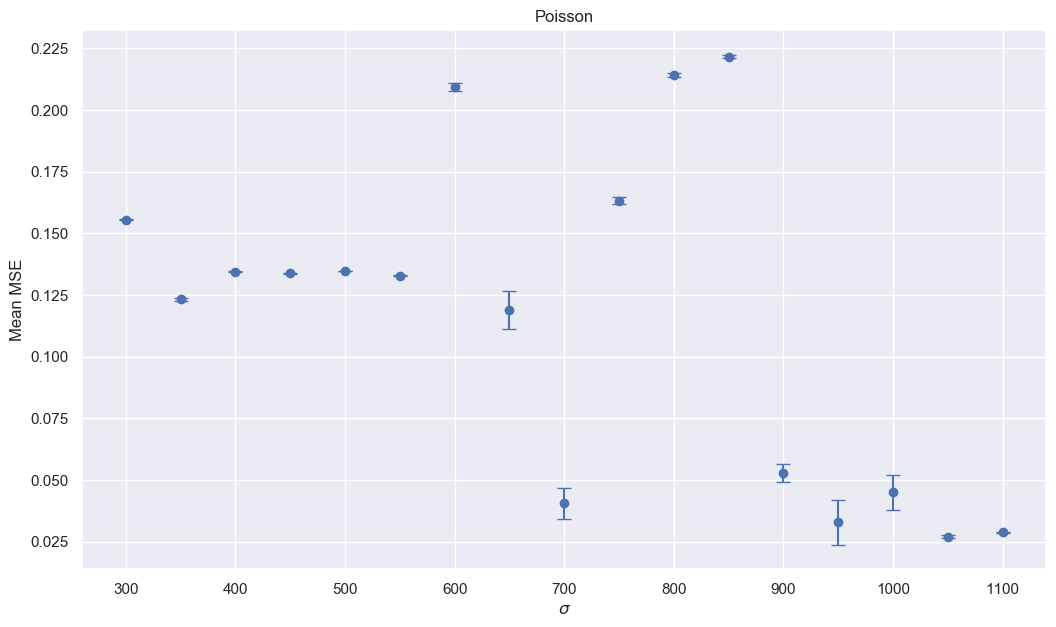

In [165]:
mp.figure(figsize=(7*16/9,7))
mp.errorbar(lamda, s_avglist, yerr=s_stdlist, xerr=None, fmt="o", capsize=5)
mp.title("Poisson")
mp.xlabel("$\sigma$")
mp.ylabel("Mean MSE")
mp.savefig("RSCS-4/poisson_lambda.png", dpi=300, bbox_inches="tight")
mp.show()

## Effect of frequency and percentage samples on reconstruction error

In [19]:
divisions = 128
frequencies = np.linspace(10,100,divisions, dtype=int)
rate = 44100
t = np.linspace(0,1,rate)
dur = 1/32
cutoff = int(dur*rate)
ty = t[:cutoff]
signals = np.array([np.sin(2*np.pi*f*t) for f in frequencies], float)
sigslices = np.array([signals[i,:cutoff] for i in range(len(signals))], float)
N = len(sigslices.T)
fractions = np.linspace(0.01*N, 0.10*N, divisions, dtype=int)
X,Y = np.meshgrid(frequencies,fractions)
Z = np.zeros_like(X, float)
d = fft.dct(np.identity(N))

In [20]:
Z.shape

(128, 128)

Optimization objective for <code>Lasso</code>:

\begin{equation}
    \frac{1}{2 n_{samples}} ||y - Xw||_2^2 + \alpha ||w||_1
\end{equation}

where $y$ is the compressed signal, $X$ is the sensing matrix, $w$ is the convex loss function, and $\alpha$ is a free parameter, whose optimal value is iteratively obtained by <code>LassoCV</code>.

### Runs:

\begin{enumerate}

\item 21 Oct '18 : 3-fold CV, 10-100 Hz, 10-90% samps, 44.1k temporal samprate, 200 spatial samprate, runtime 16:42:02
\item 22 Oct '18 : non-CV ($\alpha$ = 0.1), 10-100 Hz, 10-90% samps, 44.1k temporal samprate, 200 spatial samprate, runtime 00:14:17
\item 22 Oct '18 : non-CV ($\alpha$ = 0.5), 10-100 Hz, 10-90% samps, 44.1k temporal samprate, 200 spatial samprate, runtime 00:13:54
\item 22 Oct '18 : non-CV ($\alpha$ = 1.0), 10-100 Hz, 10-90% samps, 44.1k temporal samprate, 200 spatial samprate, runtime 00:16:33
\item 6 Nov '18 : non-CV ($\alpha$ = 0.1), 10-100 Hz, 1-10% samps, 44.1k temporal samprate, 200 spatial samprate, runtime 00:01:51
\item 6 Nov '18 : non-CV ($\alpha$ = 1.0), 10-100 Hz, 1-10% samps, 44.1k temporal samprate, 200 spatial samprate, runtime 00:01:16
\item 6 Nov '18 : 3-fold CV, 10-100 Hz, 1-10% samps, 44.1k temporal samprate, 200 spatial samprate, runtime 02:45:42

\end{enumerate}

In [179]:
for i in trange(len(frequencies)):
    for j,frac in enumerate(tqdm(fractions, leave=False)):
        yi = np.sort(rd.randint(0,N,frac))
        y = sigslices[i,yi]
        A = d[yi]
        lasso = skl.LassoCV(random_state=0, n_jobs=3)
        #lasso = skl.Lasso(alpha=1.0)
        lasso.fit(A, y)
        xhat = fft.idct(lasso.coef_)
        mse = skm.mean_squared_error(normalize(sigslices[i]), normalize(xhat))
        Z[j,i] = mse
    np.save("RSCS-6/mse3d_3cv_10-100Hz_1-10pc_200Sa.npy", Z)

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020179014605250164, tolerance: 0.00015168626488925503
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010628594535346087, tolerance: 3.8929547211062825e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015961423790261206, tolerance: 6.907862481012727e-05
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010609625168325148, tolerance: 7.933270325125159e-05
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.00102463942338e-05, tolerance: 8.013285490481512e-05
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016138142432035128, tolerance: 0.00011448073670362656
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038426931875744054, tolerance: 0.00015069658948992247
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006873011247177125, tolerance: 0.0004271520938242954
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002991489451469532, tolerance: 0.00027888956782126374
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004743385214421903, tolerance: 0.0001668611804790343
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039918927465963324, tolerance: 0.00029948900310393275
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015352058802413295, tolerance: 0.001032920209249636
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009165677321775799, tolerance: 0.0006777265943108124
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006815438726475142, tolerance: 0.0006696032010657775
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009487358289150359, tolerance: 0.0007152844491152949
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014257591309507793, tolerance: 0.0007408086909690267
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011742621076765696, tolerance: 0.0008666500664369856
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010266736624053275, tolerance: 0.0008031348333493206
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001407624884970285, tolerance: 0.0006851473630173196
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017688971943637592, tolerance: 0.0008879664526543075
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010319476875008504, tolerance: 0.0009040710055729145
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011249254997768797, tolerance: 0.0008897145188127578
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006599579579735023, tolerance: 0.0005260907702715738
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002124566980336512, tolerance: 0.0008219772657707685
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017522277869241848, tolerance: 0.000775029505020769
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002754626031715762, tolerance: 0.0008403706205068223
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022126981300885622, tolerance: 0.0009459842821392617
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017825826084208276, tolerance: 0.0009931663074700507
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002261339892249755, tolerance: 0.0012293189473318168
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001035619927141792, tolerance: 0.0005242606413727378
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017605113024837292, tolerance: 0.0006956598646058401
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015014355325579992, tolerance: 0.0007586470483559144
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001344546802465577, tolerance: 0.0007422819429213751
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012573510283140116, tolerance: 0.0010445823084011495
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012069739096955507, tolerance: 0.000802807156500618
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014260829090776612, tolerance: 0.0006714583832759881
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014954258866997868, tolerance: 0.0007198722712293717
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015895900914283231, tolerance: 0.0007504132960315463
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015035479793829465, tolerance: 0.0006602047120745627
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001617391008978035, tolerance: 0.0009732663224154639
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009283520839905688, tolerance: 0.0008102169668503552
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00112217715467518, tolerance: 0.0006589002835697476
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016769591744222013, tolerance: 0.000731474932985901
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014740140649278075, tolerance: 0.0010412947012226508
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015557982896494283, tolerance: 0.0005787819838540252
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017668628513554524, tolerance: 0.0007415517171954243
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015463912010319043, tolerance: 0.0009676560212326474
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014871264254145869, tolerance: 0.0010758216291522481
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014607605737611592, tolerance: 0.0006775101145117894
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017209719067315078, tolerance: 0.0009469102950371065
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011912169009944764, tolerance: 0.0011476015346396917
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001635707171535628, tolerance: 0.0005792381080410213
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021252762159516677, tolerance: 0.0008178638966140429
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021532548855944305, tolerance: 0.0009135296760580182
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014003857204924097, tolerance: 0.0009159630000920764
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018367795240101827, tolerance: 0.0010517344282973012
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001532063949704062, tolerance: 0.001234107851462704
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014801544342857807, tolerance: 0.0004819333163996509
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016942240402556812, tolerance: 0.0008807369667550985
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016094046695440086, tolerance: 0.0008655148534534983
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001901636586782858, tolerance: 0.0006685378070541564
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011486711377883682, tolerance: 0.001015526926538593
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017637236841112512, tolerance: 0.00092390236881573
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002896867154671073, tolerance: 0.0010377567012407783
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014802290240909864, tolerance: 0.0008736785995717533
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002039459232849319, tolerance: 0.000942975537953701
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014602614611214165, tolerance: 0.0007284483182896632
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019162428489849302, tolerance: 0.0009528621816209334
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022812501293469315, tolerance: 0.0010364431304854163
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010018098989514402, tolerance: 0.0008638503602553696
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002294856143817659, tolerance: 0.0013125486475464992
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002546678749785348, tolerance: 0.0007375049209725632
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001853214317486918, tolerance: 0.0006796283015530504
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002500133752771339, tolerance: 0.0009420989639094421
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017129416273532808, tolerance: 0.0007089456559819935
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001862926561999159, tolerance: 0.0009291059566907954
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016287885451311582, tolerance: 0.0009162069873884438
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002247957390807276, tolerance: 0.0006937074206048987
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001724194329061571, tolerance: 0.00058606987749774
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024667678037475936, tolerance: 0.0011033885373864425
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014056660921231777, tolerance: 0.0010815406545675473
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014836405219429269, tolerance: 0.0011779189802631962
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013920907942205805, tolerance: 0.0013119760083834192
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009755578721099545, tolerance: 0.00035893145203219894
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018153225606694896, tolerance: 0.0007890829137079235
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001156375096579639, tolerance: 0.0010047975721103211
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011632993972275902, tolerance: 0.0007437854532488359
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020217862424942445, tolerance: 0.0009311081501525966
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020866894830186447, tolerance: 0.0009411086587905374
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018546630111107886, tolerance: 0.0006675685074577059
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001643548083348819, tolerance: 0.0012248502129416459
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014184869908943187, tolerance: 0.0005085861160676544
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011701154758678753, tolerance: 0.000873924766533928
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00137844174034162, tolerance: 0.0012006920899260878
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007149361052281558, tolerance: 0.0007134143468230886
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001333342475001711, tolerance: 0.000791897234937873
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018328408582526526, tolerance: 0.0007442280472624689
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016470108815044688, tolerance: 0.0005789784104351746
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010429398407029397, tolerance: 0.0010017175985926837
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012603502548030304, tolerance: 0.0008875337725176723
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009907483830151624, tolerance: 0.0006398472823858988
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012431153802647706, tolerance: 0.0007188362044879251
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001051714998991597, tolerance: 0.0007523829640803671
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008174181682309092, tolerance: 0.0008025339550129511
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022195013651806843, tolerance: 0.0008177057773642068
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013208991579350877, tolerance: 0.0007251515693168255
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015666877482264396, tolerance: 0.0005963922609546134
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013525873699139174, tolerance: 0.0008519092852714426
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013666591941456831, tolerance: 0.001179270800733197
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018270946896824971, tolerance: 0.0006376223472240859
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001582546523538437, tolerance: 0.0007480085811091326
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002287547695883196, tolerance: 0.0009583626263688252
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017405894525723668, tolerance: 0.000562511668453327
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010931576617512343, tolerance: 0.0010781770363568104
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011049556194190257, tolerance: 0.0005754999771265044
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025497706447471435, tolerance: 0.0008264702237937592
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00185103225937947, tolerance: 0.0005063266362392912
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013495340941914779, tolerance: 0.0012636982846400044
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011568697967784894, tolerance: 0.0006967531286010545
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019415033729648175, tolerance: 0.0014505677933264948
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002178366719849514, tolerance: 0.0015117879162735953
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002381220788641118, tolerance: 0.0006904221089463566
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018194921909972094, tolerance: 0.0012589771183118769
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030268251272468297, tolerance: 0.0014552199941010831
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002967422460620545, tolerance: 0.0007625470094477587
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017892755024694514, tolerance: 0.0007871191949773213
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035962655398643164, tolerance: 0.0013902396934548822
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018563281306318126, tolerance: 0.0006378043210376774
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002152695397951392, tolerance: 0.001815999354781856
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026976101647788265, tolerance: 0.001360838624696698
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029774757379087647, tolerance: 0.001102890577258933
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020010190886513494, tolerance: 0.0018855714574552004
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002368826972306359, tolerance: 0.0007832777900358595
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010938852848337234, tolerance: 0.00047622837214614884
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00275696516577038, tolerance: 0.0007104056704643091
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002574375173396508, tolerance: 0.0007789826809392217
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002079845369816019, tolerance: 0.0012110558365871222
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020709496314384726, tolerance: 0.0018691670710339044
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019635974357349105, tolerance: 0.0006501804676862971
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024351667019079162, tolerance: 0.0013986447917351636
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014811437833267677, tolerance: 0.0006735570017200441
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014566065370509498, tolerance: 0.0010899483178728223
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018179411483806726, tolerance: 0.0010127068524184357
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017427021078570148, tolerance: 0.001426095824595299
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002177709171218909, tolerance: 0.0006899015681088366
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001530482553650794, tolerance: 0.0008222212620047718
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002539731819983436, tolerance: 0.0008544001842419734
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002243712496000832, tolerance: 0.0007823567014894066
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026465326769284795, tolerance: 0.0013761922954905492
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004518415585129831, tolerance: 0.004449458730601981
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002778504997865499, tolerance: 0.0007391493998164441
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021591341063508587, tolerance: 0.0006808793338843842
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023980840256024685, tolerance: 0.0007450790545064904
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002852377070879733, tolerance: 0.000890751093859962
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021872175242992156, tolerance: 0.0009796924501873005
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013493762594330924, tolerance: 0.0004283692824619459
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019600471086242462, tolerance: 0.0010244824353318647
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015585668557737456, tolerance: 0.0010655685611016803
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019347424478166676, tolerance: 0.0015337526071115045
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021711578758116046, tolerance: 0.0006534591185557901
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014423121729103482, tolerance: 0.0005009717146057166
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034531643634772703, tolerance: 0.001097875521820102
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014378640585377327, tolerance: 0.0006090869337653331
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001169863102514092, tolerance: 0.000989410116825812
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021845763649235178, tolerance: 0.0008060857991548675
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021780476950264307, tolerance: 0.0009298684166847315
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029276223598902035, tolerance: 0.0011411664810098382
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00507794447682508, tolerance: 0.004810612690994575
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002322512706623288, tolerance: 0.0022072802671027087
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018020689838008652, tolerance: 0.000893878703433326
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004152358805370588, tolerance: 0.0010138790564936293
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019319237287427828, tolerance: 0.0018661934536067333
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016032176425129024, tolerance: 0.0008470556457314232
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018113167642812191, tolerance: 0.0014578226359932512
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001888661339914971, tolerance: 0.0008054507398635643
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017071653849545084, tolerance: 0.001280135926146376
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027617121324288, tolerance: 0.001182190628440219
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00121343937727628, tolerance: 0.0007309958963199084
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018716542793105618, tolerance: 0.0013431538653942594
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017023473726795282, tolerance: 0.0012313218184117065
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014881875407474444, tolerance: 0.0010531649847033177
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002966567253287331, tolerance: 0.0008690083813965903
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002099818484224303, tolerance: 0.0014366454729444573
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002170802438917213, tolerance: 0.0006848456739511113
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015498257056890511, tolerance: 0.0012802328540192686
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027236039574404366, tolerance: 0.0013273344536754933
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019398339468161604, tolerance: 0.001108766436699143
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000922596326253198, tolerance: 0.0007398652160083295
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001365651111703516, tolerance: 0.0008004031871399429
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019701892790821647, tolerance: 0.000522406861175991
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030152380232428854, tolerance: 0.0007774197142329146
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013910838019447216, tolerance: 0.0009723948466959034
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001085451014729118, tolerance: 0.0008169149937135496
  positive)


d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002256768423030312, tolerance: 0.001131418090235212
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002200916501148154, tolerance: 0.0013132151996836448
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023662260299230293, tolerance: 0.0012989270301108295
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might

d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023756899713235995, tolerance: 0.000674970317419146
  positive)
d:\kenneth\documents\vip\tf2_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016850735995927308, tolerance: 0.0009409396648703183
  positive)


KeyboardInterrupt: 

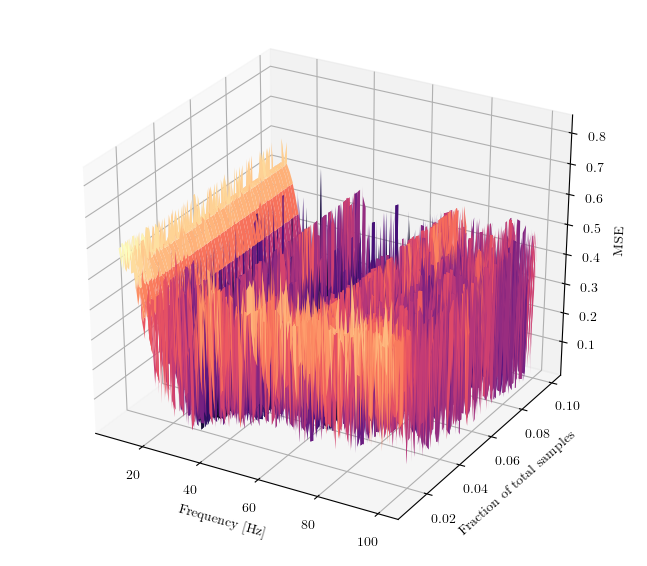

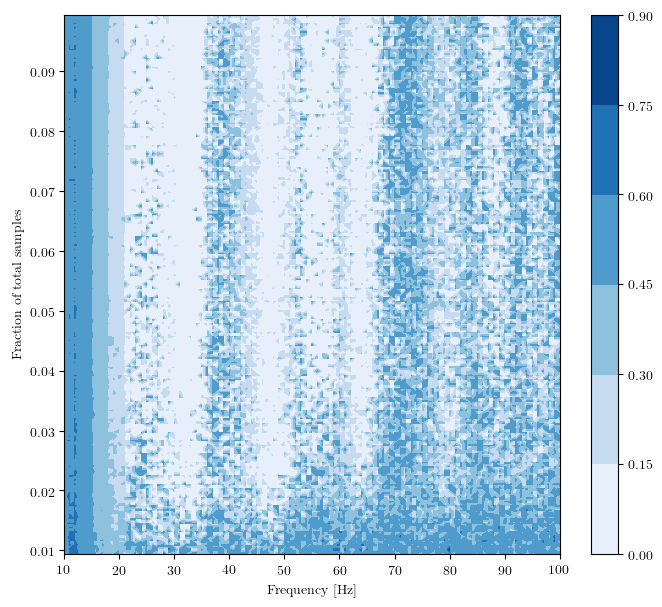

In [67]:
Z = np.loadtxt("Experiment/RSCS-6/mse3d_3cv_10-100Hz_1-10pc_200Sa.txt")

fig = mp.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection="3d")
#ax.view_init(elev=30, azim=60+180)
ax.plot_surface(X,Y/N,Z, cmap="magma")
ax.set_xlabel(r"\textrm{Frequency [Hz]}")
ax.set_ylabel(r"\textrm{Fraction of total samples}")
ax.set_zlabel(r"\textrm{MSE}")
mp.savefig("Experiment/RSCS-6/mse3d_3cv_1-100Hz_1-10pc_200Sa-surface.png", dpi=300, bbox_inches="tight")
mp.show()

mp.subplots(figsize=(8,7))
mp.xlabel(r"\textrm{Frequency [Hz]}")
mp.ylabel(r"\textrm{Fraction of total samples}")
mp.contourf(X,Y/N,Z, cmap="Blues")
mp.colorbar()
mp.savefig("d:/kenneth/documents/4-2/vip/progrep1_prev/freq+pcsamp_error.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

## Multiple-component signals

In [18]:
rate = 44100
divisions = 200
t = np.linspace(0,1,rate)
f1 = np.linspace(100,1000,divisions)
dur = 1/8
cutoff = int(dur*rate)
tc = t[:cutoff]
signals = np.zeros((divisions, rate), "float32")
for idx,f in enumerate(f1):
    signals[idx] = np.sin(2*np.pi*f*t) + np.sin(2*np.pi*f*2*t)
x = signals[:,:cutoff]
N = len(x.T)
fractions = np.linspace(0.01*N, 0.1*N, divisions, dtype=int)
X,Y = np.meshgrid(f1, fractions)
Z = np.zeros_like(X, "float32")
d = fft.dct(np.identity(N, "float32"))
reconx = np.zeros_like(x)

In [4]:
t0 = time.time()
itercount = 1
for i in range(len(f1)):
    if i != 0:
        timean = np.mean(timearr)
        hours, rem = divmod(timean, 3600)
        minutes, seconds = divmod(rem, 60)
    timearr = []
    for j,frac in enumerate(fractions):
        if j != 0:
            t1 = time.time()
            timearr.append(t1-t0)
        if j%10 == 0:
            t1 = time.time()
            hours, rem = divmod(t1-t0, 3600)
            minutes, seconds = divmod(rem, 60)
            print("{0:.2f} Hz, {1:.2f}% of samples, {2:0>2}:{3:0>2}:{4:05.2f} elapsed, {5:.2f}% done".format(f1[i],frac/N*100, int(hours), int(minutes), seconds,100*itercount/(len(f1)*len(fractions))))
        yi = np.sort(rd.randint(0,N,frac))
        y = x[i,yi]
        A = d[yi]
        #lasso = skl.LassoCV(cv=3, random_state=0)
        lasso = skl.Lasso(alpha=1.0)
        lasso.fit(A,y)
        xhat = fft.idct(lasso.coef_)
        if j == len(fractions)//2:
            reconx[i] = xhat
            print("Backing up reconstructed x for total iteration {0}".format(itercount))
            np.savetxt("Experiment/RSCS-7/Reconstructed_multiple_base100-1000Hz_1-10pcfrac_44.1kSat_200Sas.txt", reconx)
        mse = skm.mean_squared_error(xhat,x[i,:])
        Z[j,i] = mse
        itercount += 1
    print("Backing up MSE for total iteration {0}".format(itercount))
    np.savetxt("Experiment/RSCS-7/MSE_multiple_base100-1000Hz_1-10pcfrac_44.1kSat_200Sas.txt", Z)

100.00 Hz, 1.00% of samples, 00:00:00.00 elapsed, 0.00% done
100.00 Hz, 1.45% of samples, 00:00:00.78 elapsed, 0.03% done
100.00 Hz, 1.89% of samples, 00:00:00.83 elapsed, 0.05% done
100.00 Hz, 2.34% of samples, 00:00:00.90 elapsed, 0.08% done
100.00 Hz, 2.79% of samples, 00:00:00.97 elapsed, 0.10% done
100.00 Hz, 3.25% of samples, 00:00:01.07 elapsed, 0.13% done
100.00 Hz, 3.70% of samples, 00:00:01.19 elapsed, 0.15% done
100.00 Hz, 4.15% of samples, 00:00:01.33 elapsed, 0.18% done
100.00 Hz, 4.61% of samples, 00:00:01.49 elapsed, 0.20% done
100.00 Hz, 5.06% of samples, 00:00:01.64 elapsed, 0.23% done
100.00 Hz, 5.52% of samples, 00:00:01.83 elapsed, 0.25% done
Backing up reconstructed x for total iteration 101
100.00 Hz, 5.97% of samples, 00:00:02.64 elapsed, 0.28% done
100.00 Hz, 6.42% of samples, 00:00:02.92 elapsed, 0.30% done
100.00 Hz, 6.88% of samples, 00:00:03.25 elapsed, 0.33% done
100.00 Hz, 7.33% of samples, 00:00:03.57 elapsed, 0.35% done
100.00 Hz, 7.78% of samples, 00:00

127.14 Hz, 4.15% of samples, 00:00:32.28 elapsed, 3.18% done
127.14 Hz, 4.61% of samples, 00:00:32.43 elapsed, 3.20% done
127.14 Hz, 5.06% of samples, 00:00:32.62 elapsed, 3.23% done
127.14 Hz, 5.52% of samples, 00:00:32.81 elapsed, 3.25% done
Backing up reconstructed x for total iteration 1301
127.14 Hz, 5.97% of samples, 00:00:33.57 elapsed, 3.28% done
127.14 Hz, 6.42% of samples, 00:00:33.76 elapsed, 3.30% done
127.14 Hz, 6.88% of samples, 00:00:33.98 elapsed, 3.33% done
127.14 Hz, 7.33% of samples, 00:00:34.22 elapsed, 3.35% done
127.14 Hz, 7.78% of samples, 00:00:34.52 elapsed, 3.38% done
127.14 Hz, 8.22% of samples, 00:00:34.80 elapsed, 3.40% done
127.14 Hz, 8.67% of samples, 00:00:35.08 elapsed, 3.43% done
127.14 Hz, 9.13% of samples, 00:00:35.41 elapsed, 3.45% done
127.14 Hz, 9.58% of samples, 00:00:35.80 elapsed, 3.48% done
Backing up MSE for total iteration 1401
131.66 Hz, 1.00% of samples, 00:00:36.25 elapsed, 3.50% done
131.66 Hz, 1.45% of samples, 00:00:36.29 elapsed, 3.53

154.27 Hz, 6.42% of samples, 00:01:01.81 elapsed, 6.30% done
154.27 Hz, 6.88% of samples, 00:01:02.04 elapsed, 6.33% done
154.27 Hz, 7.33% of samples, 00:01:02.33 elapsed, 6.35% done
154.27 Hz, 7.78% of samples, 00:01:02.64 elapsed, 6.38% done
154.27 Hz, 8.22% of samples, 00:01:02.96 elapsed, 6.40% done
154.27 Hz, 8.67% of samples, 00:01:03.32 elapsed, 6.43% done
154.27 Hz, 9.13% of samples, 00:01:03.69 elapsed, 6.45% done
154.27 Hz, 9.58% of samples, 00:01:04.14 elapsed, 6.48% done
Backing up MSE for total iteration 2601
158.79 Hz, 1.00% of samples, 00:01:04.60 elapsed, 6.50% done
158.79 Hz, 1.45% of samples, 00:01:04.64 elapsed, 6.53% done
158.79 Hz, 1.89% of samples, 00:01:04.70 elapsed, 6.55% done
158.79 Hz, 2.34% of samples, 00:01:04.77 elapsed, 6.58% done
158.79 Hz, 2.79% of samples, 00:01:04.88 elapsed, 6.60% done
158.79 Hz, 3.25% of samples, 00:01:04.99 elapsed, 6.63% done
158.79 Hz, 3.70% of samples, 00:01:05.14 elapsed, 6.65% done
158.79 Hz, 4.15% of samples, 00:01:05.29 elap

181.41 Hz, 9.13% of samples, 00:01:33.25 elapsed, 9.45% done
181.41 Hz, 9.58% of samples, 00:01:33.61 elapsed, 9.48% done
Backing up MSE for total iteration 3801
185.93 Hz, 1.00% of samples, 00:01:33.98 elapsed, 9.50% done
185.93 Hz, 1.45% of samples, 00:01:34.02 elapsed, 9.53% done
185.93 Hz, 1.89% of samples, 00:01:34.07 elapsed, 9.55% done
185.93 Hz, 2.34% of samples, 00:01:34.13 elapsed, 9.58% done
185.93 Hz, 2.79% of samples, 00:01:34.20 elapsed, 9.60% done
185.93 Hz, 3.25% of samples, 00:01:34.29 elapsed, 9.63% done
185.93 Hz, 3.70% of samples, 00:01:34.41 elapsed, 9.65% done
185.93 Hz, 4.15% of samples, 00:01:34.55 elapsed, 9.68% done
185.93 Hz, 4.61% of samples, 00:01:34.72 elapsed, 9.70% done
185.93 Hz, 5.06% of samples, 00:01:34.90 elapsed, 9.73% done
185.93 Hz, 5.52% of samples, 00:01:35.10 elapsed, 9.75% done
Backing up reconstructed x for total iteration 3901
185.93 Hz, 5.97% of samples, 00:01:35.84 elapsed, 9.78% done
185.93 Hz, 6.42% of samples, 00:01:36.03 elapsed, 9.80

213.07 Hz, 2.34% of samples, 00:02:02.14 elapsed, 12.58% done
213.07 Hz, 2.79% of samples, 00:02:02.22 elapsed, 12.60% done
213.07 Hz, 3.25% of samples, 00:02:02.31 elapsed, 12.63% done
213.07 Hz, 3.70% of samples, 00:02:02.44 elapsed, 12.65% done
213.07 Hz, 4.15% of samples, 00:02:02.57 elapsed, 12.68% done
213.07 Hz, 4.61% of samples, 00:02:02.74 elapsed, 12.70% done
213.07 Hz, 5.06% of samples, 00:02:02.92 elapsed, 12.73% done
213.07 Hz, 5.52% of samples, 00:02:03.12 elapsed, 12.75% done
Backing up reconstructed x for total iteration 5101
213.07 Hz, 5.97% of samples, 00:02:03.84 elapsed, 12.78% done
213.07 Hz, 6.42% of samples, 00:02:04.03 elapsed, 12.80% done
213.07 Hz, 6.88% of samples, 00:02:04.24 elapsed, 12.83% done
213.07 Hz, 7.33% of samples, 00:02:04.47 elapsed, 12.85% done
213.07 Hz, 7.78% of samples, 00:02:04.76 elapsed, 12.88% done
213.07 Hz, 8.22% of samples, 00:02:05.07 elapsed, 12.90% done
213.07 Hz, 8.67% of samples, 00:02:05.38 elapsed, 12.93% done
213.07 Hz, 9.13% o

240.20 Hz, 4.15% of samples, 00:02:30.43 elapsed, 15.68% done
240.20 Hz, 4.61% of samples, 00:02:30.59 elapsed, 15.70% done
240.20 Hz, 5.06% of samples, 00:02:30.77 elapsed, 15.73% done
240.20 Hz, 5.52% of samples, 00:02:30.97 elapsed, 15.75% done
Backing up reconstructed x for total iteration 6301
240.20 Hz, 5.97% of samples, 00:02:31.71 elapsed, 15.78% done
240.20 Hz, 6.42% of samples, 00:02:31.90 elapsed, 15.80% done
240.20 Hz, 6.88% of samples, 00:02:32.17 elapsed, 15.83% done
240.20 Hz, 7.33% of samples, 00:02:32.44 elapsed, 15.85% done
240.20 Hz, 7.78% of samples, 00:02:32.74 elapsed, 15.88% done
240.20 Hz, 8.22% of samples, 00:02:33.05 elapsed, 15.90% done
240.20 Hz, 8.67% of samples, 00:02:33.39 elapsed, 15.93% done
240.20 Hz, 9.13% of samples, 00:02:33.75 elapsed, 15.95% done
240.20 Hz, 9.58% of samples, 00:02:34.13 elapsed, 15.98% done
Backing up MSE for total iteration 6401
244.72 Hz, 1.00% of samples, 00:02:34.58 elapsed, 16.00% done
244.72 Hz, 1.45% of samples, 00:02:34.63

267.34 Hz, 5.97% of samples, 00:02:59.84 elapsed, 18.78% done
267.34 Hz, 6.42% of samples, 00:03:00.07 elapsed, 18.80% done
267.34 Hz, 6.88% of samples, 00:03:00.32 elapsed, 18.83% done
267.34 Hz, 7.33% of samples, 00:03:00.59 elapsed, 18.85% done
267.34 Hz, 7.78% of samples, 00:03:00.88 elapsed, 18.88% done
267.34 Hz, 8.22% of samples, 00:03:01.19 elapsed, 18.90% done
267.34 Hz, 8.67% of samples, 00:03:01.53 elapsed, 18.93% done
267.34 Hz, 9.13% of samples, 00:03:01.88 elapsed, 18.95% done
267.34 Hz, 9.58% of samples, 00:03:02.27 elapsed, 18.98% done
Backing up MSE for total iteration 7601
271.86 Hz, 1.00% of samples, 00:03:02.70 elapsed, 19.00% done
271.86 Hz, 1.45% of samples, 00:03:02.75 elapsed, 19.03% done
271.86 Hz, 1.89% of samples, 00:03:02.80 elapsed, 19.05% done
271.86 Hz, 2.34% of samples, 00:03:02.87 elapsed, 19.08% done
271.86 Hz, 2.79% of samples, 00:03:02.95 elapsed, 19.10% done
271.86 Hz, 3.25% of samples, 00:03:03.05 elapsed, 19.13% done
271.86 Hz, 3.70% of samples, 0

294.47 Hz, 7.78% of samples, 00:03:29.50 elapsed, 21.88% done
294.47 Hz, 8.22% of samples, 00:03:29.81 elapsed, 21.90% done
294.47 Hz, 8.67% of samples, 00:03:30.14 elapsed, 21.93% done
294.47 Hz, 9.13% of samples, 00:03:30.51 elapsed, 21.95% done
294.47 Hz, 9.58% of samples, 00:03:30.89 elapsed, 21.98% done
Backing up MSE for total iteration 8801
298.99 Hz, 1.00% of samples, 00:03:31.32 elapsed, 22.00% done
298.99 Hz, 1.45% of samples, 00:03:31.36 elapsed, 22.03% done
298.99 Hz, 1.89% of samples, 00:03:31.42 elapsed, 22.05% done
298.99 Hz, 2.34% of samples, 00:03:31.50 elapsed, 22.08% done
298.99 Hz, 2.79% of samples, 00:03:31.59 elapsed, 22.10% done
298.99 Hz, 3.25% of samples, 00:03:31.69 elapsed, 22.13% done
298.99 Hz, 3.70% of samples, 00:03:31.81 elapsed, 22.15% done
298.99 Hz, 4.15% of samples, 00:03:31.95 elapsed, 22.18% done
298.99 Hz, 4.61% of samples, 00:03:32.11 elapsed, 22.20% done
298.99 Hz, 5.06% of samples, 00:03:32.28 elapsed, 22.23% done
298.99 Hz, 5.52% of samples, 0

321.61 Hz, 9.58% of samples, 00:04:00.07 elapsed, 24.98% done
Backing up MSE for total iteration 10001
326.13 Hz, 1.00% of samples, 00:04:00.52 elapsed, 25.00% done
326.13 Hz, 1.45% of samples, 00:04:00.56 elapsed, 25.03% done
326.13 Hz, 1.89% of samples, 00:04:00.62 elapsed, 25.05% done
326.13 Hz, 2.34% of samples, 00:04:00.69 elapsed, 25.08% done
326.13 Hz, 2.79% of samples, 00:04:00.78 elapsed, 25.10% done
326.13 Hz, 3.25% of samples, 00:04:00.88 elapsed, 25.13% done
326.13 Hz, 3.70% of samples, 00:04:01.02 elapsed, 25.15% done
326.13 Hz, 4.15% of samples, 00:04:01.16 elapsed, 25.18% done
326.13 Hz, 4.61% of samples, 00:04:01.32 elapsed, 25.20% done
326.13 Hz, 5.06% of samples, 00:04:01.49 elapsed, 25.23% done
326.13 Hz, 5.52% of samples, 00:04:01.68 elapsed, 25.25% done
Backing up reconstructed x for total iteration 10101
326.13 Hz, 5.97% of samples, 00:04:02.48 elapsed, 25.28% done
326.13 Hz, 6.42% of samples, 00:04:02.72 elapsed, 25.30% done
326.13 Hz, 6.88% of samples, 00:04:02.

353.27 Hz, 2.34% of samples, 00:04:29.86 elapsed, 28.08% done
353.27 Hz, 2.79% of samples, 00:04:29.95 elapsed, 28.10% done
353.27 Hz, 3.25% of samples, 00:04:30.06 elapsed, 28.13% done
353.27 Hz, 3.70% of samples, 00:04:30.19 elapsed, 28.15% done
353.27 Hz, 4.15% of samples, 00:04:30.33 elapsed, 28.18% done
353.27 Hz, 4.61% of samples, 00:04:30.49 elapsed, 28.20% done
353.27 Hz, 5.06% of samples, 00:04:30.68 elapsed, 28.23% done
353.27 Hz, 5.52% of samples, 00:04:30.87 elapsed, 28.25% done
Backing up reconstructed x for total iteration 11301
353.27 Hz, 5.97% of samples, 00:04:31.69 elapsed, 28.28% done
353.27 Hz, 6.42% of samples, 00:04:31.93 elapsed, 28.30% done
353.27 Hz, 6.88% of samples, 00:04:32.18 elapsed, 28.33% done
353.27 Hz, 7.33% of samples, 00:04:32.46 elapsed, 28.35% done
353.27 Hz, 7.78% of samples, 00:04:32.74 elapsed, 28.38% done
353.27 Hz, 8.22% of samples, 00:04:33.08 elapsed, 28.40% done
353.27 Hz, 8.67% of samples, 00:04:33.41 elapsed, 28.43% done
353.27 Hz, 9.13% 

380.40 Hz, 4.15% of samples, 00:04:59.51 elapsed, 31.18% done
380.40 Hz, 4.61% of samples, 00:04:59.67 elapsed, 31.20% done
380.40 Hz, 5.06% of samples, 00:04:59.86 elapsed, 31.23% done
380.40 Hz, 5.52% of samples, 00:05:00.06 elapsed, 31.25% done
Backing up reconstructed x for total iteration 12501
380.40 Hz, 5.97% of samples, 00:05:00.87 elapsed, 31.28% done
380.40 Hz, 6.42% of samples, 00:05:01.12 elapsed, 31.30% done
380.40 Hz, 6.88% of samples, 00:05:01.38 elapsed, 31.33% done
380.40 Hz, 7.33% of samples, 00:05:01.66 elapsed, 31.35% done
380.40 Hz, 7.78% of samples, 00:05:01.96 elapsed, 31.38% done
380.40 Hz, 8.22% of samples, 00:05:02.29 elapsed, 31.40% done
380.40 Hz, 8.67% of samples, 00:05:02.64 elapsed, 31.43% done
380.40 Hz, 9.13% of samples, 00:05:03.04 elapsed, 31.45% done
380.40 Hz, 9.58% of samples, 00:05:03.49 elapsed, 31.48% done
Backing up MSE for total iteration 12601
384.92 Hz, 1.00% of samples, 00:05:03.97 elapsed, 31.50% done
384.92 Hz, 1.45% of samples, 00:05:04.

407.54 Hz, 5.97% of samples, 00:05:30.99 elapsed, 34.28% done
407.54 Hz, 6.42% of samples, 00:05:31.25 elapsed, 34.30% done
407.54 Hz, 6.88% of samples, 00:05:31.52 elapsed, 34.33% done
407.54 Hz, 7.33% of samples, 00:05:31.82 elapsed, 34.35% done
407.54 Hz, 7.78% of samples, 00:05:32.14 elapsed, 34.38% done
407.54 Hz, 8.22% of samples, 00:05:32.47 elapsed, 34.40% done
407.54 Hz, 8.67% of samples, 00:05:32.82 elapsed, 34.43% done
407.54 Hz, 9.13% of samples, 00:05:33.20 elapsed, 34.45% done
407.54 Hz, 9.58% of samples, 00:05:33.61 elapsed, 34.48% done
Backing up MSE for total iteration 13801
412.06 Hz, 1.00% of samples, 00:05:34.08 elapsed, 34.50% done
412.06 Hz, 1.45% of samples, 00:05:34.13 elapsed, 34.53% done
412.06 Hz, 1.89% of samples, 00:05:34.19 elapsed, 34.55% done
412.06 Hz, 2.34% of samples, 00:05:34.28 elapsed, 34.58% done
412.06 Hz, 2.79% of samples, 00:05:34.37 elapsed, 34.60% done
412.06 Hz, 3.25% of samples, 00:05:34.48 elapsed, 34.63% done
412.06 Hz, 3.70% of samples, 

434.67 Hz, 7.78% of samples, 00:06:02.75 elapsed, 37.38% done
434.67 Hz, 8.22% of samples, 00:06:03.11 elapsed, 37.40% done
434.67 Hz, 8.67% of samples, 00:06:03.50 elapsed, 37.43% done
434.67 Hz, 9.13% of samples, 00:06:03.89 elapsed, 37.45% done
434.67 Hz, 9.58% of samples, 00:06:04.34 elapsed, 37.48% done
Backing up MSE for total iteration 15001
439.20 Hz, 1.00% of samples, 00:06:04.87 elapsed, 37.50% done
439.20 Hz, 1.45% of samples, 00:06:04.92 elapsed, 37.53% done
439.20 Hz, 1.89% of samples, 00:06:04.99 elapsed, 37.55% done
439.20 Hz, 2.34% of samples, 00:06:05.08 elapsed, 37.58% done
439.20 Hz, 2.79% of samples, 00:06:05.18 elapsed, 37.60% done
439.20 Hz, 3.25% of samples, 00:06:05.30 elapsed, 37.63% done
439.20 Hz, 3.70% of samples, 00:06:05.43 elapsed, 37.65% done
439.20 Hz, 4.15% of samples, 00:06:05.59 elapsed, 37.68% done
439.20 Hz, 4.61% of samples, 00:06:05.77 elapsed, 37.70% done
439.20 Hz, 5.06% of samples, 00:06:05.97 elapsed, 37.73% done
439.20 Hz, 5.52% of samples, 

461.81 Hz, 9.58% of samples, 00:06:35.41 elapsed, 40.48% done
Backing up MSE for total iteration 16201
466.33 Hz, 1.00% of samples, 00:06:35.86 elapsed, 40.50% done
466.33 Hz, 1.45% of samples, 00:06:35.91 elapsed, 40.53% done
466.33 Hz, 1.89% of samples, 00:06:35.97 elapsed, 40.55% done
466.33 Hz, 2.34% of samples, 00:06:36.05 elapsed, 40.58% done
466.33 Hz, 2.79% of samples, 00:06:36.14 elapsed, 40.60% done
466.33 Hz, 3.25% of samples, 00:06:36.26 elapsed, 40.63% done
466.33 Hz, 3.70% of samples, 00:06:36.39 elapsed, 40.65% done
466.33 Hz, 4.15% of samples, 00:06:36.55 elapsed, 40.68% done
466.33 Hz, 4.61% of samples, 00:06:36.72 elapsed, 40.70% done
466.33 Hz, 5.06% of samples, 00:06:36.92 elapsed, 40.73% done
466.33 Hz, 5.52% of samples, 00:06:37.14 elapsed, 40.75% done
Backing up reconstructed x for total iteration 16301
466.33 Hz, 5.97% of samples, 00:06:37.97 elapsed, 40.78% done
466.33 Hz, 6.42% of samples, 00:06:38.19 elapsed, 40.80% done
466.33 Hz, 6.88% of samples, 00:06:38.

493.47 Hz, 2.34% of samples, 00:07:08.03 elapsed, 43.58% done
493.47 Hz, 2.79% of samples, 00:07:08.13 elapsed, 43.60% done
493.47 Hz, 3.25% of samples, 00:07:08.25 elapsed, 43.63% done
493.47 Hz, 3.70% of samples, 00:07:08.39 elapsed, 43.65% done
493.47 Hz, 4.15% of samples, 00:07:08.55 elapsed, 43.68% done
493.47 Hz, 4.61% of samples, 00:07:08.73 elapsed, 43.70% done
493.47 Hz, 5.06% of samples, 00:07:08.94 elapsed, 43.73% done
493.47 Hz, 5.52% of samples, 00:07:09.15 elapsed, 43.75% done
Backing up reconstructed x for total iteration 17501
493.47 Hz, 5.97% of samples, 00:07:09.99 elapsed, 43.78% done
493.47 Hz, 6.42% of samples, 00:07:10.26 elapsed, 43.80% done
493.47 Hz, 6.88% of samples, 00:07:10.56 elapsed, 43.83% done
493.47 Hz, 7.33% of samples, 00:07:10.89 elapsed, 43.85% done
493.47 Hz, 7.78% of samples, 00:07:11.22 elapsed, 43.88% done
493.47 Hz, 8.22% of samples, 00:07:11.58 elapsed, 43.90% done
493.47 Hz, 8.67% of samples, 00:07:11.96 elapsed, 43.93% done
493.47 Hz, 9.13% 

520.60 Hz, 4.15% of samples, 00:07:40.78 elapsed, 46.68% done
520.60 Hz, 4.61% of samples, 00:07:40.95 elapsed, 46.70% done
520.60 Hz, 5.06% of samples, 00:07:41.15 elapsed, 46.73% done
520.60 Hz, 5.52% of samples, 00:07:41.35 elapsed, 46.75% done
Backing up reconstructed x for total iteration 18701
520.60 Hz, 5.97% of samples, 00:07:42.20 elapsed, 46.78% done
520.60 Hz, 6.42% of samples, 00:07:42.45 elapsed, 46.80% done
520.60 Hz, 6.88% of samples, 00:07:42.73 elapsed, 46.83% done
520.60 Hz, 7.33% of samples, 00:07:43.02 elapsed, 46.85% done
520.60 Hz, 7.78% of samples, 00:07:43.34 elapsed, 46.88% done
520.60 Hz, 8.22% of samples, 00:07:43.68 elapsed, 46.90% done
520.60 Hz, 8.67% of samples, 00:07:44.04 elapsed, 46.93% done
520.60 Hz, 9.13% of samples, 00:07:44.42 elapsed, 46.95% done
520.60 Hz, 9.58% of samples, 00:07:44.82 elapsed, 46.98% done
Backing up MSE for total iteration 18801
525.13 Hz, 1.00% of samples, 00:07:45.29 elapsed, 47.00% done
525.13 Hz, 1.45% of samples, 00:07:45.

547.74 Hz, 5.97% of samples, 00:08:13.79 elapsed, 49.78% done
547.74 Hz, 6.42% of samples, 00:08:14.05 elapsed, 49.80% done
547.74 Hz, 6.88% of samples, 00:08:14.32 elapsed, 49.83% done
547.74 Hz, 7.33% of samples, 00:08:14.60 elapsed, 49.85% done
547.74 Hz, 7.78% of samples, 00:08:14.93 elapsed, 49.88% done
547.74 Hz, 8.22% of samples, 00:08:15.28 elapsed, 49.90% done
547.74 Hz, 8.67% of samples, 00:08:15.64 elapsed, 49.93% done
547.74 Hz, 9.13% of samples, 00:08:16.03 elapsed, 49.95% done
547.74 Hz, 9.58% of samples, 00:08:16.43 elapsed, 49.98% done
Backing up MSE for total iteration 20001
552.26 Hz, 1.00% of samples, 00:08:16.93 elapsed, 50.00% done
552.26 Hz, 1.45% of samples, 00:08:16.99 elapsed, 50.03% done
552.26 Hz, 1.89% of samples, 00:08:17.06 elapsed, 50.05% done
552.26 Hz, 2.34% of samples, 00:08:17.16 elapsed, 50.08% done
552.26 Hz, 2.79% of samples, 00:08:17.27 elapsed, 50.10% done
552.26 Hz, 3.25% of samples, 00:08:17.39 elapsed, 50.13% done
552.26 Hz, 3.70% of samples, 

574.87 Hz, 7.78% of samples, 00:08:47.84 elapsed, 52.88% done
574.87 Hz, 8.22% of samples, 00:08:48.19 elapsed, 52.90% done
574.87 Hz, 8.67% of samples, 00:08:48.56 elapsed, 52.93% done
574.87 Hz, 9.13% of samples, 00:08:48.96 elapsed, 52.95% done
574.87 Hz, 9.58% of samples, 00:08:49.38 elapsed, 52.98% done
Backing up MSE for total iteration 21201
579.40 Hz, 1.00% of samples, 00:08:49.88 elapsed, 53.00% done
579.40 Hz, 1.45% of samples, 00:08:49.93 elapsed, 53.03% done
579.40 Hz, 1.89% of samples, 00:08:50.00 elapsed, 53.05% done
579.40 Hz, 2.34% of samples, 00:08:50.09 elapsed, 53.08% done
579.40 Hz, 2.79% of samples, 00:08:50.19 elapsed, 53.10% done
579.40 Hz, 3.25% of samples, 00:08:50.32 elapsed, 53.13% done
579.40 Hz, 3.70% of samples, 00:08:50.46 elapsed, 53.15% done
579.40 Hz, 4.15% of samples, 00:08:50.62 elapsed, 53.18% done
579.40 Hz, 4.61% of samples, 00:08:50.81 elapsed, 53.20% done
579.40 Hz, 5.06% of samples, 00:08:51.01 elapsed, 53.23% done
579.40 Hz, 5.52% of samples, 

602.01 Hz, 9.58% of samples, 00:09:20.74 elapsed, 55.98% done
Backing up MSE for total iteration 22401
606.53 Hz, 1.00% of samples, 00:09:21.22 elapsed, 56.00% done
606.53 Hz, 1.45% of samples, 00:09:21.27 elapsed, 56.03% done
606.53 Hz, 1.89% of samples, 00:09:21.33 elapsed, 56.05% done
606.53 Hz, 2.34% of samples, 00:09:21.41 elapsed, 56.08% done
606.53 Hz, 2.79% of samples, 00:09:21.51 elapsed, 56.10% done
606.53 Hz, 3.25% of samples, 00:09:21.63 elapsed, 56.13% done
606.53 Hz, 3.70% of samples, 00:09:21.78 elapsed, 56.15% done
606.53 Hz, 4.15% of samples, 00:09:21.95 elapsed, 56.18% done
606.53 Hz, 4.61% of samples, 00:09:22.12 elapsed, 56.20% done
606.53 Hz, 5.06% of samples, 00:09:22.32 elapsed, 56.23% done
606.53 Hz, 5.52% of samples, 00:09:22.54 elapsed, 56.25% done
Backing up reconstructed x for total iteration 22501
606.53 Hz, 5.97% of samples, 00:09:23.41 elapsed, 56.28% done
606.53 Hz, 6.42% of samples, 00:09:23.64 elapsed, 56.30% done
606.53 Hz, 6.88% of samples, 00:09:23.

633.67 Hz, 2.34% of samples, 00:09:52.01 elapsed, 59.08% done
633.67 Hz, 2.79% of samples, 00:09:52.09 elapsed, 59.10% done
633.67 Hz, 3.25% of samples, 00:09:52.20 elapsed, 59.13% done
633.67 Hz, 3.70% of samples, 00:09:52.33 elapsed, 59.15% done
633.67 Hz, 4.15% of samples, 00:09:52.49 elapsed, 59.18% done
633.67 Hz, 4.61% of samples, 00:09:52.65 elapsed, 59.20% done
633.67 Hz, 5.06% of samples, 00:09:52.83 elapsed, 59.23% done
633.67 Hz, 5.52% of samples, 00:09:53.06 elapsed, 59.25% done
Backing up reconstructed x for total iteration 23701
633.67 Hz, 5.97% of samples, 00:09:53.89 elapsed, 59.28% done
633.67 Hz, 6.42% of samples, 00:09:54.14 elapsed, 59.30% done
633.67 Hz, 6.88% of samples, 00:09:54.40 elapsed, 59.33% done
633.67 Hz, 7.33% of samples, 00:09:54.68 elapsed, 59.35% done
633.67 Hz, 7.78% of samples, 00:09:54.98 elapsed, 59.38% done
633.67 Hz, 8.22% of samples, 00:09:55.31 elapsed, 59.40% done
633.67 Hz, 8.67% of samples, 00:09:55.65 elapsed, 59.43% done
633.67 Hz, 9.13% 

660.80 Hz, 4.15% of samples, 00:10:22.27 elapsed, 62.18% done
660.80 Hz, 4.61% of samples, 00:10:22.43 elapsed, 62.20% done
660.80 Hz, 5.06% of samples, 00:10:22.62 elapsed, 62.23% done
660.80 Hz, 5.52% of samples, 00:10:22.83 elapsed, 62.25% done
Backing up reconstructed x for total iteration 24901
660.80 Hz, 5.97% of samples, 00:10:23.70 elapsed, 62.28% done
660.80 Hz, 6.42% of samples, 00:10:23.95 elapsed, 62.30% done
660.80 Hz, 6.88% of samples, 00:10:24.22 elapsed, 62.33% done
660.80 Hz, 7.33% of samples, 00:10:24.51 elapsed, 62.35% done
660.80 Hz, 7.78% of samples, 00:10:24.82 elapsed, 62.38% done
660.80 Hz, 8.22% of samples, 00:10:25.15 elapsed, 62.40% done
660.80 Hz, 8.67% of samples, 00:10:25.50 elapsed, 62.43% done
660.80 Hz, 9.13% of samples, 00:10:25.87 elapsed, 62.45% done
660.80 Hz, 9.58% of samples, 00:10:26.27 elapsed, 62.48% done
Backing up MSE for total iteration 25001
665.33 Hz, 1.00% of samples, 00:10:26.72 elapsed, 62.50% done
665.33 Hz, 1.45% of samples, 00:10:26.

687.94 Hz, 5.97% of samples, 00:10:54.72 elapsed, 65.28% done
687.94 Hz, 6.42% of samples, 00:10:54.96 elapsed, 65.30% done
687.94 Hz, 6.88% of samples, 00:10:55.23 elapsed, 65.33% done
687.94 Hz, 7.33% of samples, 00:10:55.54 elapsed, 65.35% done
687.94 Hz, 7.78% of samples, 00:10:55.85 elapsed, 65.38% done
687.94 Hz, 8.22% of samples, 00:10:56.18 elapsed, 65.40% done
687.94 Hz, 8.67% of samples, 00:10:56.54 elapsed, 65.43% done
687.94 Hz, 9.13% of samples, 00:10:56.92 elapsed, 65.45% done
687.94 Hz, 9.58% of samples, 00:10:57.32 elapsed, 65.48% done
Backing up MSE for total iteration 26201
692.46 Hz, 1.00% of samples, 00:10:57.77 elapsed, 65.50% done
692.46 Hz, 1.45% of samples, 00:10:57.83 elapsed, 65.53% done
692.46 Hz, 1.89% of samples, 00:10:57.89 elapsed, 65.55% done
692.46 Hz, 2.34% of samples, 00:10:57.97 elapsed, 65.58% done
692.46 Hz, 2.79% of samples, 00:10:58.07 elapsed, 65.60% done
692.46 Hz, 3.25% of samples, 00:10:58.19 elapsed, 65.63% done
692.46 Hz, 3.70% of samples, 

715.08 Hz, 7.78% of samples, 00:11:26.89 elapsed, 68.38% done
715.08 Hz, 8.22% of samples, 00:11:27.22 elapsed, 68.40% done
715.08 Hz, 8.67% of samples, 00:11:27.56 elapsed, 68.43% done
715.08 Hz, 9.13% of samples, 00:11:27.94 elapsed, 68.45% done
715.08 Hz, 9.58% of samples, 00:11:28.34 elapsed, 68.48% done
Backing up MSE for total iteration 27401
719.60 Hz, 1.00% of samples, 00:11:28.81 elapsed, 68.50% done
719.60 Hz, 1.45% of samples, 00:11:28.86 elapsed, 68.53% done
719.60 Hz, 1.89% of samples, 00:11:28.92 elapsed, 68.55% done
719.60 Hz, 2.34% of samples, 00:11:28.99 elapsed, 68.58% done
719.60 Hz, 2.79% of samples, 00:11:29.09 elapsed, 68.60% done
719.60 Hz, 3.25% of samples, 00:11:29.20 elapsed, 68.63% done
719.60 Hz, 3.70% of samples, 00:11:29.33 elapsed, 68.65% done
719.60 Hz, 4.15% of samples, 00:11:29.48 elapsed, 68.68% done
719.60 Hz, 4.61% of samples, 00:11:29.64 elapsed, 68.70% done
719.60 Hz, 5.06% of samples, 00:11:29.83 elapsed, 68.73% done
719.60 Hz, 5.52% of samples, 

742.21 Hz, 9.58% of samples, 00:11:59.60 elapsed, 71.48% done
Backing up MSE for total iteration 28601
746.73 Hz, 1.00% of samples, 00:12:00.07 elapsed, 71.50% done
746.73 Hz, 1.45% of samples, 00:12:00.12 elapsed, 71.53% done
746.73 Hz, 1.89% of samples, 00:12:00.18 elapsed, 71.55% done
746.73 Hz, 2.34% of samples, 00:12:00.26 elapsed, 71.58% done
746.73 Hz, 2.79% of samples, 00:12:00.35 elapsed, 71.60% done
746.73 Hz, 3.25% of samples, 00:12:00.47 elapsed, 71.63% done
746.73 Hz, 3.70% of samples, 00:12:00.60 elapsed, 71.65% done
746.73 Hz, 4.15% of samples, 00:12:00.76 elapsed, 71.68% done
746.73 Hz, 4.61% of samples, 00:12:00.93 elapsed, 71.70% done
746.73 Hz, 5.06% of samples, 00:12:01.12 elapsed, 71.73% done
746.73 Hz, 5.52% of samples, 00:12:01.32 elapsed, 71.75% done
Backing up reconstructed x for total iteration 28701
746.73 Hz, 5.97% of samples, 00:12:02.18 elapsed, 71.78% done
746.73 Hz, 6.42% of samples, 00:12:02.46 elapsed, 71.80% done
746.73 Hz, 6.88% of samples, 00:12:02.

773.87 Hz, 2.34% of samples, 00:12:31.33 elapsed, 74.58% done
773.87 Hz, 2.79% of samples, 00:12:31.43 elapsed, 74.60% done
773.87 Hz, 3.25% of samples, 00:12:31.54 elapsed, 74.63% done
773.87 Hz, 3.70% of samples, 00:12:31.67 elapsed, 74.65% done
773.87 Hz, 4.15% of samples, 00:12:31.82 elapsed, 74.68% done
773.87 Hz, 4.61% of samples, 00:12:31.99 elapsed, 74.70% done
773.87 Hz, 5.06% of samples, 00:12:32.17 elapsed, 74.73% done
773.87 Hz, 5.52% of samples, 00:12:32.37 elapsed, 74.75% done
Backing up reconstructed x for total iteration 29901
773.87 Hz, 5.97% of samples, 00:12:33.20 elapsed, 74.78% done
773.87 Hz, 6.42% of samples, 00:12:33.45 elapsed, 74.80% done
773.87 Hz, 6.88% of samples, 00:12:33.72 elapsed, 74.83% done
773.87 Hz, 7.33% of samples, 00:12:34.00 elapsed, 74.85% done
773.87 Hz, 7.78% of samples, 00:12:34.31 elapsed, 74.88% done
773.87 Hz, 8.22% of samples, 00:12:34.64 elapsed, 74.90% done
773.87 Hz, 8.67% of samples, 00:12:34.98 elapsed, 74.93% done
773.87 Hz, 9.13% 

801.01 Hz, 4.15% of samples, 00:13:01.90 elapsed, 77.68% done
801.01 Hz, 4.61% of samples, 00:13:02.05 elapsed, 77.70% done
801.01 Hz, 5.06% of samples, 00:13:02.24 elapsed, 77.73% done
801.01 Hz, 5.52% of samples, 00:13:02.44 elapsed, 77.75% done
Backing up reconstructed x for total iteration 31101
801.01 Hz, 5.97% of samples, 00:13:03.55 elapsed, 77.78% done
801.01 Hz, 6.42% of samples, 00:13:03.79 elapsed, 77.80% done
801.01 Hz, 6.88% of samples, 00:13:04.05 elapsed, 77.83% done
801.01 Hz, 7.33% of samples, 00:13:04.33 elapsed, 77.85% done
801.01 Hz, 7.78% of samples, 00:13:04.64 elapsed, 77.88% done
801.01 Hz, 8.22% of samples, 00:13:04.96 elapsed, 77.90% done
801.01 Hz, 8.67% of samples, 00:13:05.31 elapsed, 77.93% done
801.01 Hz, 9.13% of samples, 00:13:05.68 elapsed, 77.95% done
801.01 Hz, 9.58% of samples, 00:13:06.08 elapsed, 77.98% done
Backing up MSE for total iteration 31201
805.53 Hz, 1.00% of samples, 00:13:06.58 elapsed, 78.00% done
805.53 Hz, 1.45% of samples, 00:13:06.

855.28 Hz, 6.88% of samples, 00:14:03.73 elapsed, 83.83% done
855.28 Hz, 7.33% of samples, 00:14:03.99 elapsed, 83.85% done
855.28 Hz, 7.78% of samples, 00:14:04.30 elapsed, 83.88% done
855.28 Hz, 8.22% of samples, 00:14:04.62 elapsed, 83.90% done
855.28 Hz, 8.67% of samples, 00:14:04.99 elapsed, 83.93% done
855.28 Hz, 9.13% of samples, 00:14:05.38 elapsed, 83.95% done
855.28 Hz, 9.58% of samples, 00:14:05.75 elapsed, 83.98% done
Backing up MSE for total iteration 33601
859.80 Hz, 1.00% of samples, 00:14:06.22 elapsed, 84.00% done
859.80 Hz, 1.45% of samples, 00:14:06.27 elapsed, 84.03% done
859.80 Hz, 1.89% of samples, 00:14:06.33 elapsed, 84.05% done
859.80 Hz, 2.34% of samples, 00:14:06.41 elapsed, 84.08% done
859.80 Hz, 2.79% of samples, 00:14:06.49 elapsed, 84.10% done
859.80 Hz, 3.25% of samples, 00:14:06.59 elapsed, 84.13% done
859.80 Hz, 3.70% of samples, 00:14:06.72 elapsed, 84.15% done
859.80 Hz, 4.15% of samples, 00:14:06.87 elapsed, 84.18% done
859.80 Hz, 4.61% of samples, 

882.41 Hz, 8.67% of samples, 00:14:35.18 elapsed, 86.93% done
882.41 Hz, 9.13% of samples, 00:14:35.55 elapsed, 86.95% done
882.41 Hz, 9.58% of samples, 00:14:35.97 elapsed, 86.98% done
Backing up MSE for total iteration 34801
886.93 Hz, 1.00% of samples, 00:14:36.47 elapsed, 87.00% done
886.93 Hz, 1.45% of samples, 00:14:36.51 elapsed, 87.03% done
886.93 Hz, 1.89% of samples, 00:14:36.58 elapsed, 87.05% done
886.93 Hz, 2.34% of samples, 00:14:36.65 elapsed, 87.08% done
886.93 Hz, 2.79% of samples, 00:14:36.75 elapsed, 87.10% done
886.93 Hz, 3.25% of samples, 00:14:36.85 elapsed, 87.13% done
886.93 Hz, 3.70% of samples, 00:14:36.98 elapsed, 87.15% done
886.93 Hz, 4.15% of samples, 00:14:37.14 elapsed, 87.18% done
886.93 Hz, 4.61% of samples, 00:14:37.32 elapsed, 87.20% done
886.93 Hz, 5.06% of samples, 00:14:37.52 elapsed, 87.23% done
886.93 Hz, 5.52% of samples, 00:14:37.75 elapsed, 87.25% done
Backing up reconstructed x for total iteration 34901
886.93 Hz, 5.97% of samples, 00:14:38.

914.07 Hz, 2.34% of samples, 00:15:08.00 elapsed, 90.08% done
914.07 Hz, 2.79% of samples, 00:15:08.10 elapsed, 90.10% done
914.07 Hz, 3.25% of samples, 00:15:08.21 elapsed, 90.13% done
914.07 Hz, 3.70% of samples, 00:15:08.33 elapsed, 90.15% done
914.07 Hz, 4.15% of samples, 00:15:08.48 elapsed, 90.18% done
914.07 Hz, 4.61% of samples, 00:15:08.63 elapsed, 90.20% done
914.07 Hz, 5.06% of samples, 00:15:08.82 elapsed, 90.23% done
914.07 Hz, 5.52% of samples, 00:15:09.02 elapsed, 90.25% done
Backing up reconstructed x for total iteration 36101
914.07 Hz, 5.97% of samples, 00:15:09.82 elapsed, 90.28% done
914.07 Hz, 6.42% of samples, 00:15:10.06 elapsed, 90.30% done
914.07 Hz, 6.88% of samples, 00:15:10.31 elapsed, 90.33% done
914.07 Hz, 7.33% of samples, 00:15:10.59 elapsed, 90.35% done
914.07 Hz, 7.78% of samples, 00:15:10.89 elapsed, 90.38% done
914.07 Hz, 8.22% of samples, 00:15:11.21 elapsed, 90.40% done
914.07 Hz, 8.67% of samples, 00:15:11.56 elapsed, 90.43% done
914.07 Hz, 9.13% 

941.21 Hz, 4.15% of samples, 00:15:38.08 elapsed, 93.18% done
941.21 Hz, 4.61% of samples, 00:15:38.23 elapsed, 93.20% done
941.21 Hz, 5.06% of samples, 00:15:38.41 elapsed, 93.23% done
941.21 Hz, 5.52% of samples, 00:15:38.61 elapsed, 93.25% done
Backing up reconstructed x for total iteration 37301
941.21 Hz, 5.97% of samples, 00:15:39.39 elapsed, 93.28% done
941.21 Hz, 6.42% of samples, 00:15:39.63 elapsed, 93.30% done
941.21 Hz, 6.88% of samples, 00:15:39.88 elapsed, 93.33% done
941.21 Hz, 7.33% of samples, 00:15:40.17 elapsed, 93.35% done
941.21 Hz, 7.78% of samples, 00:15:40.46 elapsed, 93.38% done
941.21 Hz, 8.22% of samples, 00:15:40.78 elapsed, 93.40% done
941.21 Hz, 8.67% of samples, 00:15:41.12 elapsed, 93.43% done
941.21 Hz, 9.13% of samples, 00:15:41.48 elapsed, 93.45% done
941.21 Hz, 9.58% of samples, 00:15:41.86 elapsed, 93.48% done
Backing up MSE for total iteration 37401
945.73 Hz, 1.00% of samples, 00:15:42.33 elapsed, 93.50% done
945.73 Hz, 1.45% of samples, 00:15:42.

995.48 Hz, 6.88% of samples, 00:16:40.35 elapsed, 99.33% done
995.48 Hz, 7.33% of samples, 00:16:40.67 elapsed, 99.35% done
995.48 Hz, 7.78% of samples, 00:16:41.00 elapsed, 99.38% done
995.48 Hz, 8.22% of samples, 00:16:41.33 elapsed, 99.40% done
995.48 Hz, 8.67% of samples, 00:16:41.69 elapsed, 99.43% done
995.48 Hz, 9.13% of samples, 00:16:42.07 elapsed, 99.45% done
995.48 Hz, 9.58% of samples, 00:16:42.49 elapsed, 99.48% done
Backing up MSE for total iteration 39801
1000.00 Hz, 1.00% of samples, 00:16:42.97 elapsed, 99.50% done
1000.00 Hz, 1.45% of samples, 00:16:43.02 elapsed, 99.53% done
1000.00 Hz, 1.89% of samples, 00:16:43.09 elapsed, 99.55% done
1000.00 Hz, 2.34% of samples, 00:16:43.18 elapsed, 99.58% done
1000.00 Hz, 2.79% of samples, 00:16:43.27 elapsed, 99.60% done
1000.00 Hz, 3.25% of samples, 00:16:43.39 elapsed, 99.63% done
1000.00 Hz, 3.70% of samples, 00:16:43.53 elapsed, 99.65% done
1000.00 Hz, 4.15% of samples, 00:16:43.68 elapsed, 99.68% done
1000.00 Hz, 4.61% of 

## Varying amplitude

In [69]:
rate = 44100
divisions = 200
t = np.linspace(0,1,rate)
a1 = np.linspace(0.01,1,divisions)
dur = 1/8
cutoff = int(dur*rate)
tc = t[:cutoff]
signals = np.zeros((divisions, rate), "float32")
for idx,a in enumerate(a1):
    signals[idx] = np.sin(2*np.pi*440*t) + a*np.sin(2*np.pi*880*t)
x = signals[:,:cutoff]
N = len(x.T)
fractions = np.linspace(0.01*N, 0.1*N, divisions, dtype=int)
X,Y = np.meshgrid(a1, fractions)
Z = np.zeros_like(X, "float32")
d = fft.dct(np.identity(N, "float32"))
reconx = np.zeros_like(x)

In [5]:
t0 = time.time()
itercount = 1
for i in range(len(a1)):
    if i != 0:
        timean = np.mean(timearr)
        hours, rem = divmod(timean, 3600)
        minutes, seconds = divmod(rem, 60)
    timearr = []
    for j,frac in enumerate(fractions):
        if j != 0:
            t1 = time.time()
            timearr.append(t1-t0)
        if j%10 == 0:
            t1 = time.time()
            hours, rem = divmod(t1-t0, 3600)
            minutes, seconds = divmod(rem, 60)
            print("{0:.2f}*A, {1:.2f}% of samples, {2:0>2}:{3:0>2}:{4:05.2f} elapsed, {5:.2f}% done".format(a1[i],frac/N*100, int(hours), int(minutes), seconds,100*itercount/(len(a1)*len(fractions))))
        yi = np.sort(rd.randint(0,N,frac))
        y = x[i,yi]
        A = d[yi]
        lasso = skl.LassoCV(cv=3, random_state=0)
        #lasso = skl.Lasso(alpha=1.0)
        lasso.fit(A,y)
        xhat = fft.idct(lasso.coef_)
        if j == len(fractions)//2:
            reconx[i] = xhat
            print("Backing up reconstructed x for total iteration {0}".format(itercount))
            np.savetxt("Experiment/RSCS-8/Reconstructed_multiple_base440Hz_1-10pcfrac_amp0.01-1_44.1kSat_200Sas.txt", reconx)
        mse = skm.mean_squared_error(xhat,x[i,:])
        Z[j,i] = mse
        itercount += 1
    print("Backing up MSE for total iteration {0}".format(itercount))
    np.savetxt("Experiment/RSCS-8/MSE_multiple_base440Hz_1-10pcfrac_amp0.1-1_44.1kSat_200Sas.txt", Z)

0.01*A, 1.00% of samples, 00:00:00.00 elapsed, 0.00% done


C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.01*A, 1.45% of samples, 00:00:12.14 elapsed, 0.03% done
0.01*A, 1.89% of samples, 00:00:24.50 elapsed, 0.05% done
0.01*A, 2.34% of samples, 00:00:37.28 elapsed, 0.08% done
0.01*A, 2.79% of samples, 00:00:51.26 elapsed, 0.10% done
0.01*A, 3.25% of samples, 00:01:05.93 elapsed, 0.13% done
0.01*A, 3.70% of samples, 00:01:20.62 elapsed, 0.15% done
0.01*A, 4.15% of samples, 00:01:37.08 elapsed, 0.18% done
0.01*A, 4.61% of samples, 00:01:55.35 elapsed, 0.20% done
0.01*A, 5.06% of samples, 00:02:14.50 elapsed, 0.23% done
0.01*A, 5.52% of samples, 00:02:34.88 elapsed, 0.25% done
Backing up reconstructed x for total iteration 101
0.01*A, 5.97% of samples, 00:02:59.34 elapsed, 0.28% done
0.01*A, 6.42% of samples, 00:03:23.62 elapsed, 0.30% done
0.01*A, 6.88% of samples, 00:03:50.53 elapsed, 0.33% done
0.01*A, 7.33% of samples, 00:04:18.55 elapsed, 0.35% done
0.01*A, 7.78% of samples, 00:04:48.50 elapsed, 0.38% done
0.01*A, 8.22% of samples, 00:05:21.42 elapsed, 0.40% done
0.01*A, 8.67% of samp

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.03*A, 1.45% of samples, 00:31:20.08 elapsed, 2.03% done
0.03*A, 1.89% of samples, 00:31:32.30 elapsed, 2.05% done
0.03*A, 2.34% of samples, 00:31:43.46 elapsed, 2.08% done
0.03*A, 2.79% of samples, 00:31:56.35 elapsed, 2.10% done
0.03*A, 3.25% of samples, 00:32:09.60 elapsed, 2.13% done
0.03*A, 3.70% of samples, 00:32:23.57 elapsed, 2.15% done
0.03*A, 4.15% of samples, 00:32:38.54 elapsed, 2.18% done
0.03*A, 4.61% of samples, 00:32:55.23 elapsed, 2.20% done
0.03*A, 5.06% of samples, 00:33:13.30 elapsed, 2.23% done
0.03*A, 5.52% of samples, 00:33:32.78 elapsed, 2.25% done
Backing up reconstructed x for total iteration 901
0.03*A, 5.97% of samples, 00:33:56.50 elapsed, 2.28% done
0.03*A, 6.42% of samples, 00:34:19.52 elapsed, 2.30% done
0.03*A, 6.88% of samples, 00:34:44.53 elapsed, 2.33% done
0.03*A, 7.33% of samples, 00:35:12.17 elapsed, 2.35% done
0.03*A, 7.78% of samples, 00:35:42.12 elapsed, 2.38% done
0.03*A, 8.22% of samples, 00:36:14.76 elapsed, 2.40% done
0.03*A, 8.67% of samp

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.03*A, 1.45% of samples, 00:38:56.70 elapsed, 2.53% done
0.03*A, 1.89% of samples, 00:39:07.80 elapsed, 2.55% done
0.03*A, 2.34% of samples, 00:39:19.65 elapsed, 2.58% done
0.03*A, 2.79% of samples, 00:39:32.26 elapsed, 2.60% done
0.03*A, 3.25% of samples, 00:39:44.87 elapsed, 2.63% done
0.03*A, 3.70% of samples, 00:39:59.11 elapsed, 2.65% done
0.03*A, 4.15% of samples, 00:40:14.15 elapsed, 2.68% done
0.03*A, 4.61% of samples, 00:40:30.87 elapsed, 2.70% done
0.03*A, 5.06% of samples, 00:40:48.53 elapsed, 2.73% done
0.03*A, 5.52% of samples, 00:41:07.38 elapsed, 2.75% done
Backing up reconstructed x for total iteration 1101
0.03*A, 5.97% of samples, 00:41:30.51 elapsed, 2.78% done
0.03*A, 6.42% of samples, 00:41:53.70 elapsed, 2.80% done
0.03*A, 6.88% of samples, 00:42:18.74 elapsed, 2.83% done
0.03*A, 7.33% of samples, 00:42:45.38 elapsed, 2.85% done
0.03*A, 7.78% of samples, 00:43:14.70 elapsed, 2.88% done
0.03*A, 8.22% of samples, 00:43:45.84 elapsed, 2.90% done
0.03*A, 8.67% of sam

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.04*A, 1.45% of samples, 00:54:01.24 elapsed, 3.53% done
0.04*A, 1.89% of samples, 00:54:12.69 elapsed, 3.55% done
0.04*A, 2.34% of samples, 00:54:24.95 elapsed, 3.58% done
0.04*A, 2.79% of samples, 00:54:37.54 elapsed, 3.60% done
0.04*A, 3.25% of samples, 00:54:50.95 elapsed, 3.63% done
0.04*A, 3.70% of samples, 00:55:04.87 elapsed, 3.65% done
0.04*A, 4.15% of samples, 00:55:19.53 elapsed, 3.68% done
0.04*A, 4.61% of samples, 00:55:35.76 elapsed, 3.70% done
0.04*A, 5.06% of samples, 00:55:53.98 elapsed, 3.73% done
0.04*A, 5.52% of samples, 00:56:13.14 elapsed, 3.75% done
Backing up reconstructed x for total iteration 1501
0.04*A, 5.97% of samples, 00:56:36.87 elapsed, 3.78% done
0.04*A, 6.42% of samples, 00:57:00.31 elapsed, 3.80% done
0.04*A, 6.88% of samples, 00:57:24.67 elapsed, 3.83% done
0.04*A, 7.33% of samples, 00:57:51.88 elapsed, 3.85% done
0.04*A, 7.78% of samples, 00:58:20.97 elapsed, 3.88% done
0.04*A, 8.22% of samples, 00:58:51.66 elapsed, 3.90% done
0.04*A, 8.67% of sam

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.06*A, 1.45% of samples, 01:24:01.35 elapsed, 5.53% done
0.06*A, 1.89% of samples, 01:24:13.02 elapsed, 5.55% done
0.06*A, 2.34% of samples, 01:24:24.61 elapsed, 5.58% done
0.06*A, 2.79% of samples, 01:24:36.56 elapsed, 5.60% done
0.06*A, 3.25% of samples, 01:24:49.52 elapsed, 5.63% done
0.06*A, 3.70% of samples, 01:25:03.54 elapsed, 5.65% done
0.06*A, 4.15% of samples, 01:25:18.59 elapsed, 5.68% done
0.06*A, 4.61% of samples, 01:25:34.55 elapsed, 5.70% done
0.06*A, 5.06% of samples, 01:25:52.28 elapsed, 5.73% done
0.06*A, 5.52% of samples, 01:26:12.36 elapsed, 5.75% done
Backing up reconstructed x for total iteration 2301
0.06*A, 5.97% of samples, 01:26:36.56 elapsed, 5.78% done
0.06*A, 6.42% of samples, 01:26:59.71 elapsed, 5.80% done
0.06*A, 6.88% of samples, 01:27:24.09 elapsed, 5.83% done
0.06*A, 7.33% of samples, 01:27:50.29 elapsed, 5.85% done
0.06*A, 7.78% of samples, 01:28:19.64 elapsed, 5.88% done
0.06*A, 8.22% of samples, 01:28:51.13 elapsed, 5.90% done
0.06*A, 8.67% of sam

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.08*A, 1.45% of samples, 01:54:08.53 elapsed, 7.53% done
0.08*A, 1.89% of samples, 01:54:20.74 elapsed, 7.55% done
0.08*A, 2.34% of samples, 01:54:32.49 elapsed, 7.58% done
0.08*A, 2.79% of samples, 01:54:44.98 elapsed, 7.60% done
0.08*A, 3.25% of samples, 01:54:58.38 elapsed, 7.63% done
0.08*A, 3.70% of samples, 01:55:12.57 elapsed, 7.65% done
0.08*A, 4.15% of samples, 01:55:27.26 elapsed, 7.68% done
0.08*A, 4.61% of samples, 01:55:43.60 elapsed, 7.70% done
0.08*A, 5.06% of samples, 01:56:01.84 elapsed, 7.73% done
0.08*A, 5.52% of samples, 01:56:21.77 elapsed, 7.75% done
Backing up reconstructed x for total iteration 3101
0.08*A, 5.97% of samples, 01:56:45.21 elapsed, 7.78% done
0.08*A, 6.42% of samples, 01:57:08.00 elapsed, 7.80% done
0.08*A, 6.88% of samples, 01:57:33.02 elapsed, 7.83% done
0.08*A, 7.33% of samples, 01:58:00.07 elapsed, 7.85% done
0.08*A, 7.78% of samples, 01:58:29.75 elapsed, 7.88% done
0.08*A, 8.22% of samples, 01:59:01.51 elapsed, 7.90% done
0.08*A, 8.67% of sam

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.10*A, 1.45% of samples, 02:24:17.22 elapsed, 9.53% done
0.10*A, 1.89% of samples, 02:24:28.57 elapsed, 9.55% done
0.10*A, 2.34% of samples, 02:24:40.70 elapsed, 9.58% done
0.10*A, 2.79% of samples, 02:24:53.12 elapsed, 9.60% done
0.10*A, 3.25% of samples, 02:25:05.77 elapsed, 9.63% done
0.10*A, 3.70% of samples, 02:25:19.64 elapsed, 9.65% done
0.10*A, 4.15% of samples, 02:25:34.62 elapsed, 9.68% done
0.10*A, 4.61% of samples, 02:25:50.61 elapsed, 9.70% done
0.10*A, 5.06% of samples, 02:26:08.85 elapsed, 9.73% done
0.10*A, 5.52% of samples, 02:26:28.31 elapsed, 9.75% done
Backing up reconstructed x for total iteration 3901
0.10*A, 5.97% of samples, 02:26:52.25 elapsed, 9.78% done
0.10*A, 6.42% of samples, 02:27:15.28 elapsed, 9.80% done
0.10*A, 6.88% of samples, 02:27:40.12 elapsed, 9.83% done
0.10*A, 7.33% of samples, 02:28:06.85 elapsed, 9.85% done
0.10*A, 7.78% of samples, 02:28:36.32 elapsed, 9.88% done
0.10*A, 8.22% of samples, 02:29:07.71 elapsed, 9.90% done
0.10*A, 8.67% of sam

Backing up reconstructed x for total iteration 5101
0.13*A, 5.97% of samples, 03:12:19.06 elapsed, 12.78% done
0.13*A, 6.42% of samples, 03:12:42.23 elapsed, 12.80% done
0.13*A, 6.88% of samples, 03:13:07.55 elapsed, 12.83% done
0.13*A, 7.33% of samples, 03:13:34.49 elapsed, 12.85% done
0.13*A, 7.78% of samples, 03:14:03.78 elapsed, 12.88% done
0.13*A, 8.22% of samples, 03:14:35.70 elapsed, 12.90% done
0.13*A, 8.67% of samples, 03:15:09.62 elapsed, 12.93% done
0.13*A, 9.13% of samples, 03:15:44.37 elapsed, 12.95% done
0.13*A, 9.58% of samples, 03:16:23.10 elapsed, 12.98% done
Backing up MSE for total iteration 5201
0.14*A, 1.00% of samples, 03:17:04.48 elapsed, 13.00% done


C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.14*A, 1.45% of samples, 03:17:16.98 elapsed, 13.03% done
0.14*A, 1.89% of samples, 03:17:28.63 elapsed, 13.05% done
0.14*A, 2.34% of samples, 03:17:40.72 elapsed, 13.08% done
0.14*A, 2.79% of samples, 03:17:53.16 elapsed, 13.10% done
0.14*A, 3.25% of samples, 03:18:06.77 elapsed, 13.13% done
0.14*A, 3.70% of samples, 03:18:20.88 elapsed, 13.15% done
0.14*A, 4.15% of samples, 03:18:36.85 elapsed, 13.18% done
0.14*A, 4.61% of samples, 03:18:54.11 elapsed, 13.20% done
0.14*A, 5.06% of samples, 03:19:11.91 elapsed, 13.23% done
0.14*A, 5.52% of samples, 03:19:31.28 elapsed, 13.25% done
Backing up reconstructed x for total iteration 5301
0.14*A, 5.97% of samples, 03:19:55.82 elapsed, 13.28% done
0.14*A, 6.42% of samples, 03:20:19.17 elapsed, 13.30% done
0.14*A, 6.88% of samples, 03:20:44.15 elapsed, 13.33% done
0.14*A, 7.33% of samples, 03:21:11.43 elapsed, 13.35% done
0.14*A, 7.78% of samples, 03:21:40.62 elapsed, 13.38% done
0.14*A, 8.22% of samples, 03:22:12.28 elapsed, 13.40% done
0.14

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.15*A, 1.45% of samples, 03:40:25.04 elapsed, 14.53% done
0.15*A, 1.89% of samples, 03:40:36.86 elapsed, 14.55% done
0.15*A, 2.34% of samples, 03:40:48.77 elapsed, 14.58% done
0.15*A, 2.79% of samples, 03:41:01.94 elapsed, 14.60% done
0.15*A, 3.25% of samples, 03:41:15.39 elapsed, 14.63% done
0.15*A, 3.70% of samples, 03:41:29.07 elapsed, 14.65% done
0.15*A, 4.15% of samples, 03:41:44.83 elapsed, 14.68% done
0.15*A, 4.61% of samples, 03:42:01.59 elapsed, 14.70% done
0.15*A, 5.06% of samples, 03:42:19.61 elapsed, 14.73% done
0.15*A, 5.52% of samples, 03:42:39.00 elapsed, 14.75% done
Backing up reconstructed x for total iteration 5901
0.15*A, 5.97% of samples, 03:43:03.02 elapsed, 14.78% done
0.15*A, 6.42% of samples, 03:43:26.05 elapsed, 14.80% done
0.15*A, 6.88% of samples, 03:43:51.38 elapsed, 14.83% done
0.15*A, 7.33% of samples, 03:44:19.13 elapsed, 14.85% done
0.15*A, 7.78% of samples, 03:44:48.79 elapsed, 14.88% done
0.15*A, 8.22% of samples, 03:45:20.58 elapsed, 14.90% done
0.15

Backing up reconstructed x for total iteration 7101
0.18*A, 5.97% of samples, 04:28:53.95 elapsed, 17.78% done
0.18*A, 6.42% of samples, 04:29:17.20 elapsed, 17.80% done
0.18*A, 6.88% of samples, 04:29:42.11 elapsed, 17.83% done
0.18*A, 7.33% of samples, 04:30:09.89 elapsed, 17.85% done
0.18*A, 7.78% of samples, 04:30:39.13 elapsed, 17.88% done
0.18*A, 8.22% of samples, 04:31:10.59 elapsed, 17.90% done
0.18*A, 8.67% of samples, 04:31:44.66 elapsed, 17.93% done
0.18*A, 9.13% of samples, 04:32:21.13 elapsed, 17.95% done
0.18*A, 9.58% of samples, 04:32:59.41 elapsed, 17.98% done
Backing up MSE for total iteration 7201
0.19*A, 1.00% of samples, 04:33:40.47 elapsed, 18.00% done
0.19*A, 1.45% of samples, 04:33:52.45 elapsed, 18.03% done
0.19*A, 1.89% of samples, 04:34:04.65 elapsed, 18.05% done
0.19*A, 2.34% of samples, 04:34:16.10 elapsed, 18.08% done
0.19*A, 2.79% of samples, 04:34:28.65 elapsed, 18.10% done
0.19*A, 3.25% of samples, 04:34:41.37 elapsed, 18.13% done
0.19*A, 3.70% of sample

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.21*A, 1.45% of samples, 05:12:08.00 elapsed, 20.53% done
0.21*A, 1.89% of samples, 05:12:19.88 elapsed, 20.55% done
0.21*A, 2.34% of samples, 05:12:32.36 elapsed, 20.58% done
0.21*A, 2.79% of samples, 05:12:44.55 elapsed, 20.60% done
0.21*A, 3.25% of samples, 05:12:57.39 elapsed, 20.63% done
0.21*A, 3.70% of samples, 05:13:11.04 elapsed, 20.65% done
0.21*A, 4.15% of samples, 05:13:25.56 elapsed, 20.68% done
0.21*A, 4.61% of samples, 05:13:41.85 elapsed, 20.70% done
0.21*A, 5.06% of samples, 05:13:59.81 elapsed, 20.73% done
0.21*A, 5.52% of samples, 05:14:19.19 elapsed, 20.75% done
Backing up reconstructed x for total iteration 8301
0.21*A, 5.97% of samples, 05:14:43.22 elapsed, 20.78% done
0.21*A, 6.42% of samples, 05:15:07.03 elapsed, 20.80% done
0.21*A, 6.88% of samples, 05:15:32.34 elapsed, 20.83% done
0.21*A, 7.33% of samples, 05:15:59.78 elapsed, 20.85% done
0.21*A, 7.78% of samples, 05:16:28.49 elapsed, 20.88% done
0.21*A, 8.22% of samples, 05:16:59.21 elapsed, 20.90% done
0.21

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.24*A, 1.45% of samples, 05:57:53.01 elapsed, 23.53% done
0.24*A, 1.89% of samples, 05:58:05.73 elapsed, 23.55% done
0.24*A, 2.34% of samples, 05:58:17.72 elapsed, 23.58% done
0.24*A, 2.79% of samples, 05:58:30.41 elapsed, 23.60% done
0.24*A, 3.25% of samples, 05:58:43.91 elapsed, 23.63% done
0.24*A, 3.70% of samples, 05:58:57.84 elapsed, 23.65% done
0.24*A, 4.15% of samples, 05:59:13.09 elapsed, 23.68% done
0.24*A, 4.61% of samples, 05:59:30.11 elapsed, 23.70% done
0.24*A, 5.06% of samples, 05:59:48.86 elapsed, 23.73% done
0.24*A, 5.52% of samples, 06:00:09.23 elapsed, 23.75% done
Backing up reconstructed x for total iteration 9501
0.24*A, 5.97% of samples, 06:00:33.27 elapsed, 23.78% done
0.24*A, 6.42% of samples, 06:00:56.86 elapsed, 23.80% done
0.24*A, 6.88% of samples, 06:01:22.31 elapsed, 23.83% done
0.24*A, 7.33% of samples, 06:01:49.88 elapsed, 23.85% done
0.24*A, 7.78% of samples, 06:02:19.11 elapsed, 23.88% done
0.24*A, 8.22% of samples, 06:02:51.86 elapsed, 23.90% done
0.24

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.27*A, 1.45% of samples, 06:36:19.70 elapsed, 26.03% done
0.27*A, 1.89% of samples, 06:36:31.96 elapsed, 26.05% done
0.27*A, 2.34% of samples, 06:36:44.19 elapsed, 26.08% done
0.27*A, 2.79% of samples, 06:36:56.75 elapsed, 26.10% done
0.27*A, 3.25% of samples, 06:37:09.30 elapsed, 26.13% done
0.27*A, 3.70% of samples, 06:37:23.62 elapsed, 26.15% done
0.27*A, 4.15% of samples, 06:37:38.76 elapsed, 26.18% done
0.27*A, 4.61% of samples, 06:37:55.02 elapsed, 26.20% done
0.27*A, 5.06% of samples, 06:38:13.16 elapsed, 26.23% done
0.27*A, 5.52% of samples, 06:38:33.16 elapsed, 26.25% done
Backing up reconstructed x for total iteration 10501
0.27*A, 5.97% of samples, 06:38:57.97 elapsed, 26.28% done
0.27*A, 6.42% of samples, 06:39:20.91 elapsed, 26.30% done
0.27*A, 6.88% of samples, 06:39:47.28 elapsed, 26.33% done
0.27*A, 7.33% of samples, 06:40:14.59 elapsed, 26.35% done
0.27*A, 7.78% of samples, 06:40:43.48 elapsed, 26.38% done
0.27*A, 8.22% of samples, 06:41:14.81 elapsed, 26.40% done
0.2

Backing up reconstructed x for total iteration 11701
0.30*A, 5.97% of samples, 07:25:49.86 elapsed, 29.28% done
0.30*A, 6.42% of samples, 07:26:13.38 elapsed, 29.30% done
0.30*A, 6.88% of samples, 07:26:39.77 elapsed, 29.33% done
0.30*A, 7.33% of samples, 07:27:07.24 elapsed, 29.35% done
0.30*A, 7.78% of samples, 07:27:37.16 elapsed, 29.38% done
0.30*A, 8.22% of samples, 07:28:09.64 elapsed, 29.40% done
0.30*A, 8.67% of samples, 07:28:44.06 elapsed, 29.43% done
0.30*A, 9.13% of samples, 07:29:22.18 elapsed, 29.45% done
0.30*A, 9.58% of samples, 07:30:01.32 elapsed, 29.48% done
Backing up MSE for total iteration 11801
0.30*A, 1.00% of samples, 07:30:43.18 elapsed, 29.50% done
0.30*A, 1.45% of samples, 07:30:56.99 elapsed, 29.53% done
0.30*A, 1.89% of samples, 07:31:09.74 elapsed, 29.55% done
0.30*A, 2.34% of samples, 07:31:22.29 elapsed, 29.58% done
0.30*A, 2.79% of samples, 07:31:35.31 elapsed, 29.60% done
0.30*A, 3.25% of samples, 07:31:48.96 elapsed, 29.63% done
0.30*A, 3.70% of samp

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.32*A, 1.45% of samples, 07:54:22.78 elapsed, 31.03% done
0.32*A, 1.89% of samples, 07:54:34.76 elapsed, 31.05% done
0.32*A, 2.34% of samples, 07:54:47.20 elapsed, 31.08% done
0.32*A, 2.79% of samples, 07:55:00.56 elapsed, 31.10% done
0.32*A, 3.25% of samples, 07:55:14.36 elapsed, 31.13% done
0.32*A, 3.70% of samples, 07:55:28.72 elapsed, 31.15% done
0.32*A, 4.15% of samples, 07:55:44.18 elapsed, 31.18% done
0.32*A, 4.61% of samples, 07:56:01.31 elapsed, 31.20% done
0.32*A, 5.06% of samples, 07:56:19.65 elapsed, 31.23% done
0.32*A, 5.52% of samples, 07:56:39.43 elapsed, 31.25% done
Backing up reconstructed x for total iteration 12501
0.32*A, 5.97% of samples, 07:57:03.90 elapsed, 31.28% done
0.32*A, 6.42% of samples, 07:57:26.93 elapsed, 31.30% done
0.32*A, 6.88% of samples, 07:57:52.36 elapsed, 31.33% done
0.32*A, 7.33% of samples, 07:58:19.92 elapsed, 31.35% done
0.32*A, 7.78% of samples, 07:58:49.67 elapsed, 31.38% done
0.32*A, 8.22% of samples, 07:59:22.80 elapsed, 31.40% done
0.3

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.34*A, 1.45% of samples, 08:25:28.22 elapsed, 33.03% done
0.34*A, 1.89% of samples, 08:25:41.32 elapsed, 33.05% done
0.34*A, 2.34% of samples, 08:25:53.87 elapsed, 33.08% done
0.34*A, 2.79% of samples, 08:26:06.96 elapsed, 33.10% done
0.34*A, 3.25% of samples, 08:26:20.62 elapsed, 33.13% done
0.34*A, 3.70% of samples, 08:26:35.04 elapsed, 33.15% done
0.34*A, 4.15% of samples, 08:26:51.01 elapsed, 33.18% done
0.34*A, 4.61% of samples, 08:27:08.28 elapsed, 33.20% done
0.34*A, 5.06% of samples, 08:27:26.54 elapsed, 33.23% done
0.34*A, 5.52% of samples, 08:27:46.09 elapsed, 33.25% done
Backing up reconstructed x for total iteration 13301
0.34*A, 5.97% of samples, 08:28:11.04 elapsed, 33.28% done
0.34*A, 6.42% of samples, 08:28:34.51 elapsed, 33.30% done
0.34*A, 6.88% of samples, 08:29:00.64 elapsed, 33.33% done
0.34*A, 7.33% of samples, 08:29:28.56 elapsed, 33.35% done
0.34*A, 7.78% of samples, 08:29:59.37 elapsed, 33.38% done
0.34*A, 8.22% of samples, 08:30:31.85 elapsed, 33.40% done
0.3

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.37*A, 1.45% of samples, 09:12:37.22 elapsed, 36.03% done
0.37*A, 1.89% of samples, 09:12:49.82 elapsed, 36.05% done
0.37*A, 2.34% of samples, 09:13:02.48 elapsed, 36.08% done
0.37*A, 2.79% of samples, 09:13:15.62 elapsed, 36.10% done
0.37*A, 3.25% of samples, 09:13:29.33 elapsed, 36.13% done
0.37*A, 3.70% of samples, 09:13:44.00 elapsed, 36.15% done
0.37*A, 4.15% of samples, 09:14:00.31 elapsed, 36.18% done
0.37*A, 4.61% of samples, 09:14:17.77 elapsed, 36.20% done
0.37*A, 5.06% of samples, 09:14:36.50 elapsed, 36.23% done
0.37*A, 5.52% of samples, 09:14:56.49 elapsed, 36.25% done
Backing up reconstructed x for total iteration 14501
0.37*A, 5.97% of samples, 09:15:21.17 elapsed, 36.28% done
0.37*A, 6.42% of samples, 09:15:44.77 elapsed, 36.30% done
0.37*A, 6.88% of samples, 09:16:11.37 elapsed, 36.33% done
0.37*A, 7.33% of samples, 09:16:38.59 elapsed, 36.35% done
0.37*A, 7.78% of samples, 09:17:07.99 elapsed, 36.38% done
0.37*A, 8.22% of samples, 09:17:40.64 elapsed, 36.40% done
0.3

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.38*A, 1.45% of samples, 09:28:20.18 elapsed, 37.03% done
0.38*A, 1.89% of samples, 09:28:33.42 elapsed, 37.05% done
0.38*A, 2.34% of samples, 09:28:47.00 elapsed, 37.08% done
0.38*A, 2.79% of samples, 09:28:59.61 elapsed, 37.10% done
0.38*A, 3.25% of samples, 09:29:13.80 elapsed, 37.13% done
0.38*A, 3.70% of samples, 09:29:28.33 elapsed, 37.15% done
0.38*A, 4.15% of samples, 09:29:43.98 elapsed, 37.18% done
0.38*A, 4.61% of samples, 09:30:01.44 elapsed, 37.20% done
0.38*A, 5.06% of samples, 09:30:19.93 elapsed, 37.23% done
0.38*A, 5.52% of samples, 09:30:41.15 elapsed, 37.25% done
Backing up reconstructed x for total iteration 14901
0.38*A, 5.97% of samples, 09:31:05.51 elapsed, 37.28% done
0.38*A, 6.42% of samples, 09:31:28.72 elapsed, 37.30% done
0.38*A, 6.88% of samples, 09:31:54.89 elapsed, 37.33% done
0.38*A, 7.33% of samples, 09:32:22.60 elapsed, 37.35% done
0.38*A, 7.78% of samples, 09:32:52.10 elapsed, 37.38% done
0.38*A, 8.22% of samples, 09:33:24.19 elapsed, 37.40% done
0.3

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.40*A, 2.34% of samples, 10:08:13.38 elapsed, 39.58% done
0.40*A, 2.79% of samples, 10:08:26.64 elapsed, 39.60% done
0.40*A, 3.25% of samples, 10:08:40.76 elapsed, 39.63% done
0.40*A, 3.70% of samples, 10:08:55.34 elapsed, 39.65% done
0.40*A, 4.15% of samples, 10:09:11.10 elapsed, 39.68% done
0.40*A, 4.61% of samples, 10:09:28.56 elapsed, 39.70% done
0.40*A, 5.06% of samples, 10:09:47.35 elapsed, 39.73% done
0.40*A, 5.52% of samples, 10:10:08.14 elapsed, 39.75% done
Backing up reconstructed x for total iteration 15901
0.40*A, 5.97% of samples, 10:10:33.15 elapsed, 39.78% done
0.40*A, 6.42% of samples, 10:10:57.30 elapsed, 39.80% done
0.40*A, 6.88% of samples, 10:11:22.91 elapsed, 39.83% done
0.40*A, 7.33% of samples, 10:11:51.06 elapsed, 39.85% done
0.40*A, 7.78% of samples, 10:12:21.04 elapsed, 39.88% done
0.40*A, 8.22% of samples, 10:12:53.34 elapsed, 39.90% done
0.40*A, 8.67% of samples, 10:13:28.47 elapsed, 39.93% done
0.40*A, 9.13% of samples, 10:14:05.81 elapsed, 39.95% done
0.4

0.43*A, 6.42% of samples, 10:58:33.77 elapsed, 42.80% done
0.43*A, 6.88% of samples, 10:58:59.22 elapsed, 42.83% done
0.43*A, 7.33% of samples, 10:59:26.91 elapsed, 42.85% done
0.43*A, 7.78% of samples, 10:59:57.29 elapsed, 42.88% done
0.43*A, 8.22% of samples, 11:00:29.97 elapsed, 42.90% done
0.43*A, 8.67% of samples, 11:01:04.92 elapsed, 42.93% done
0.43*A, 9.13% of samples, 11:01:41.83 elapsed, 42.95% done
0.43*A, 9.58% of samples, 11:02:21.40 elapsed, 42.98% done
Backing up MSE for total iteration 17201
0.44*A, 1.00% of samples, 11:03:04.23 elapsed, 43.00% done
0.44*A, 1.45% of samples, 11:03:17.85 elapsed, 43.03% done
0.44*A, 1.89% of samples, 11:03:31.20 elapsed, 43.05% done
0.44*A, 2.34% of samples, 11:03:44.24 elapsed, 43.08% done
0.44*A, 2.79% of samples, 11:03:57.83 elapsed, 43.10% done
0.44*A, 3.25% of samples, 11:04:11.75 elapsed, 43.13% done
0.44*A, 3.70% of samples, 11:04:26.74 elapsed, 43.15% done
0.44*A, 4.15% of samples, 11:04:42.25 elapsed, 43.18% done
0.44*A, 4.61% o

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.44*A, 1.89% of samples, 11:11:28.13 elapsed, 43.55% done
0.44*A, 2.34% of samples, 11:11:40.53 elapsed, 43.58% done
0.44*A, 2.79% of samples, 11:11:53.42 elapsed, 43.60% done
0.44*A, 3.25% of samples, 11:12:07.53 elapsed, 43.63% done
0.44*A, 3.70% of samples, 11:12:22.03 elapsed, 43.65% done
0.44*A, 4.15% of samples, 11:12:38.24 elapsed, 43.68% done
0.44*A, 4.61% of samples, 11:12:55.25 elapsed, 43.70% done
0.44*A, 5.06% of samples, 11:13:14.11 elapsed, 43.73% done
0.44*A, 5.52% of samples, 11:13:33.94 elapsed, 43.75% done
Backing up reconstructed x for total iteration 17501
0.44*A, 5.97% of samples, 11:13:59.65 elapsed, 43.78% done
0.44*A, 6.42% of samples, 11:14:23.73 elapsed, 43.80% done
0.44*A, 6.88% of samples, 11:14:50.81 elapsed, 43.83% done
0.44*A, 7.33% of samples, 11:15:19.59 elapsed, 43.85% done
0.44*A, 7.78% of samples, 11:15:50.51 elapsed, 43.88% done
0.44*A, 8.22% of samples, 11:16:22.92 elapsed, 43.90% done
0.44*A, 8.67% of samples, 11:16:57.16 elapsed, 43.93% done
0.4

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.46*A, 1.45% of samples, 11:43:07.15 elapsed, 45.53% done
0.46*A, 1.89% of samples, 11:43:20.54 elapsed, 45.55% done
0.46*A, 2.34% of samples, 11:43:34.26 elapsed, 45.58% done
0.46*A, 2.79% of samples, 11:43:47.84 elapsed, 45.60% done
0.46*A, 3.25% of samples, 11:44:01.51 elapsed, 45.63% done
0.46*A, 3.70% of samples, 11:44:16.07 elapsed, 45.65% done
0.46*A, 4.15% of samples, 11:44:32.00 elapsed, 45.68% done
0.46*A, 4.61% of samples, 11:44:49.45 elapsed, 45.70% done
0.46*A, 5.06% of samples, 11:45:08.83 elapsed, 45.73% done
0.46*A, 5.52% of samples, 11:45:29.38 elapsed, 45.75% done
Backing up reconstructed x for total iteration 18301
0.46*A, 5.97% of samples, 11:45:54.76 elapsed, 45.78% done
0.46*A, 6.42% of samples, 11:46:18.49 elapsed, 45.80% done
0.46*A, 6.88% of samples, 11:46:44.57 elapsed, 45.83% done
0.46*A, 7.33% of samples, 11:47:12.29 elapsed, 45.85% done
0.46*A, 7.78% of samples, 11:47:42.65 elapsed, 45.88% done
0.46*A, 8.22% of samples, 11:48:15.21 elapsed, 45.90% done
0.4

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.49*A, 1.45% of samples, 12:22:59.58 elapsed, 48.03% done
0.49*A, 1.89% of samples, 12:23:13.18 elapsed, 48.05% done
0.49*A, 2.34% of samples, 12:23:26.24 elapsed, 48.08% done
0.49*A, 2.79% of samples, 12:23:40.63 elapsed, 48.10% done
0.49*A, 3.25% of samples, 12:23:55.28 elapsed, 48.13% done
0.49*A, 3.70% of samples, 12:24:10.43 elapsed, 48.15% done
0.49*A, 4.15% of samples, 12:24:27.15 elapsed, 48.18% done
0.49*A, 4.61% of samples, 12:24:44.68 elapsed, 48.20% done
0.49*A, 5.06% of samples, 12:25:04.14 elapsed, 48.23% done
0.49*A, 5.52% of samples, 12:25:24.38 elapsed, 48.25% done
Backing up reconstructed x for total iteration 19301
0.49*A, 5.97% of samples, 12:25:50.21 elapsed, 48.28% done
0.49*A, 6.42% of samples, 12:26:14.37 elapsed, 48.30% done
0.49*A, 6.88% of samples, 12:26:40.76 elapsed, 48.33% done
0.49*A, 7.33% of samples, 12:27:09.34 elapsed, 48.35% done
0.49*A, 7.78% of samples, 12:27:39.63 elapsed, 48.38% done
0.49*A, 8.22% of samples, 12:28:12.67 elapsed, 48.40% done
0.4

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.50*A, 1.45% of samples, 12:47:09.93 elapsed, 49.53% done
0.50*A, 1.89% of samples, 12:47:23.29 elapsed, 49.55% done
0.50*A, 2.34% of samples, 12:47:36.79 elapsed, 49.58% done
0.50*A, 2.79% of samples, 12:47:50.24 elapsed, 49.60% done
0.50*A, 3.25% of samples, 12:48:04.29 elapsed, 49.63% done
0.50*A, 3.70% of samples, 12:48:18.95 elapsed, 49.65% done
0.50*A, 4.15% of samples, 12:48:36.00 elapsed, 49.68% done
0.50*A, 4.61% of samples, 12:48:56.19 elapsed, 49.70% done
0.50*A, 5.06% of samples, 12:49:17.25 elapsed, 49.73% done
0.50*A, 5.52% of samples, 12:49:37.52 elapsed, 49.75% done
Backing up reconstructed x for total iteration 19901
0.50*A, 5.97% of samples, 12:50:03.23 elapsed, 49.78% done
0.50*A, 6.42% of samples, 12:50:28.42 elapsed, 49.80% done
0.50*A, 6.88% of samples, 12:50:54.29 elapsed, 49.83% done
0.50*A, 7.33% of samples, 12:51:22.59 elapsed, 49.85% done
0.50*A, 7.78% of samples, 12:51:53.65 elapsed, 49.88% done
0.50*A, 8.22% of samples, 12:52:26.38 elapsed, 49.90% done
0.5

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.53*A, 1.45% of samples, 13:27:23.41 elapsed, 52.03% done
0.53*A, 1.89% of samples, 13:27:36.52 elapsed, 52.05% done
0.53*A, 2.34% of samples, 13:27:49.27 elapsed, 52.08% done
0.53*A, 2.79% of samples, 13:28:02.98 elapsed, 52.10% done
0.53*A, 3.25% of samples, 13:28:16.88 elapsed, 52.13% done
0.53*A, 3.70% of samples, 13:28:32.20 elapsed, 52.15% done
0.53*A, 4.15% of samples, 13:28:47.96 elapsed, 52.18% done
0.53*A, 4.61% of samples, 13:29:06.05 elapsed, 52.20% done
0.53*A, 5.06% of samples, 13:29:24.73 elapsed, 52.23% done
0.53*A, 5.52% of samples, 13:29:45.48 elapsed, 52.25% done
Backing up reconstructed x for total iteration 20901
0.53*A, 5.97% of samples, 13:30:11.91 elapsed, 52.28% done
0.53*A, 6.42% of samples, 13:30:36.19 elapsed, 52.30% done
0.53*A, 6.88% of samples, 13:31:02.16 elapsed, 52.33% done
0.53*A, 7.33% of samples, 13:31:30.40 elapsed, 52.35% done
0.53*A, 7.78% of samples, 13:32:01.84 elapsed, 52.38% done
0.53*A, 8.22% of samples, 13:32:34.97 elapsed, 52.40% done
0.5

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.53*A, 1.45% of samples, 13:35:25.79 elapsed, 52.53% done
0.53*A, 1.89% of samples, 13:35:39.99 elapsed, 52.55% done
0.53*A, 2.34% of samples, 13:35:53.35 elapsed, 52.58% done
0.53*A, 2.79% of samples, 13:36:07.47 elapsed, 52.60% done
0.53*A, 3.25% of samples, 13:36:21.17 elapsed, 52.63% done
0.53*A, 3.70% of samples, 13:36:35.79 elapsed, 52.65% done
0.53*A, 4.15% of samples, 13:36:51.48 elapsed, 52.68% done
0.53*A, 4.61% of samples, 13:37:08.99 elapsed, 52.70% done
0.53*A, 5.06% of samples, 13:37:27.43 elapsed, 52.73% done
0.53*A, 5.52% of samples, 13:37:47.55 elapsed, 52.75% done
Backing up reconstructed x for total iteration 21101
0.53*A, 5.97% of samples, 13:38:13.43 elapsed, 52.78% done
0.53*A, 6.42% of samples, 13:38:37.08 elapsed, 52.80% done
0.53*A, 6.88% of samples, 13:39:03.09 elapsed, 52.83% done
0.53*A, 7.33% of samples, 13:39:31.00 elapsed, 52.85% done
0.53*A, 7.78% of samples, 13:40:01.54 elapsed, 52.88% done
0.53*A, 8.22% of samples, 13:40:35.42 elapsed, 52.90% done
0.5

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.56*A, 1.89% of samples, 14:15:47.37 elapsed, 55.05% done
0.56*A, 2.34% of samples, 14:16:01.26 elapsed, 55.08% done
0.56*A, 2.79% of samples, 14:16:14.67 elapsed, 55.10% done
0.56*A, 3.25% of samples, 14:16:28.57 elapsed, 55.13% done
0.56*A, 3.70% of samples, 14:16:43.18 elapsed, 55.15% done
0.56*A, 4.15% of samples, 14:16:59.16 elapsed, 55.18% done
0.56*A, 4.61% of samples, 14:17:16.13 elapsed, 55.20% done
0.56*A, 5.06% of samples, 14:17:35.33 elapsed, 55.23% done
0.56*A, 5.52% of samples, 14:17:56.28 elapsed, 55.25% done
Backing up reconstructed x for total iteration 22101
0.56*A, 5.97% of samples, 14:18:23.19 elapsed, 55.28% done
0.56*A, 6.42% of samples, 14:18:48.90 elapsed, 55.30% done
0.56*A, 6.88% of samples, 14:19:15.38 elapsed, 55.33% done
0.56*A, 7.33% of samples, 14:19:44.41 elapsed, 55.35% done
0.56*A, 7.78% of samples, 14:20:15.41 elapsed, 55.38% done
0.56*A, 8.22% of samples, 14:20:48.29 elapsed, 55.40% done
0.56*A, 8.67% of samples, 14:21:23.06 elapsed, 55.43% done
0.5

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.59*A, 1.45% of samples, 15:04:08.50 elapsed, 58.03% done
0.59*A, 1.89% of samples, 15:04:21.26 elapsed, 58.05% done
0.59*A, 2.34% of samples, 15:04:34.76 elapsed, 58.08% done
0.59*A, 2.79% of samples, 15:04:48.43 elapsed, 58.10% done
0.59*A, 3.25% of samples, 15:05:02.97 elapsed, 58.13% done
0.59*A, 3.70% of samples, 15:05:18.61 elapsed, 58.15% done
0.59*A, 4.15% of samples, 15:05:34.66 elapsed, 58.18% done
0.59*A, 4.61% of samples, 15:05:52.06 elapsed, 58.20% done
0.59*A, 5.06% of samples, 15:06:11.19 elapsed, 58.23% done
0.59*A, 5.52% of samples, 15:06:31.31 elapsed, 58.25% done
Backing up reconstructed x for total iteration 23301
0.59*A, 5.97% of samples, 15:06:57.63 elapsed, 58.28% done
0.59*A, 6.42% of samples, 15:07:21.53 elapsed, 58.30% done
0.59*A, 6.88% of samples, 15:07:47.84 elapsed, 58.33% done
0.59*A, 7.33% of samples, 15:08:16.67 elapsed, 58.35% done
0.59*A, 7.78% of samples, 15:08:47.61 elapsed, 58.38% done
0.59*A, 8.22% of samples, 15:09:20.49 elapsed, 58.40% done
0.5

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.59*A, 1.45% of samples, 15:12:12.21 elapsed, 58.53% done


C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.59*A, 1.89% of samples, 15:12:26.47 elapsed, 58.55% done
0.59*A, 2.34% of samples, 15:12:39.37 elapsed, 58.58% done
0.59*A, 2.79% of samples, 15:12:53.30 elapsed, 58.60% done
0.59*A, 3.25% of samples, 15:13:06.96 elapsed, 58.63% done
0.59*A, 3.70% of samples, 15:13:22.56 elapsed, 58.65% done
0.59*A, 4.15% of samples, 15:13:38.47 elapsed, 58.68% done
0.59*A, 4.61% of samples, 15:13:56.37 elapsed, 58.70% done
0.59*A, 5.06% of samples, 15:14:15.36 elapsed, 58.73% done
0.59*A, 5.52% of samples, 15:14:36.55 elapsed, 58.75% done
Backing up reconstructed x for total iteration 23501
0.59*A, 5.97% of samples, 15:15:01.80 elapsed, 58.78% done
0.59*A, 6.42% of samples, 15:15:26.23 elapsed, 58.80% done
0.59*A, 6.88% of samples, 15:15:53.11 elapsed, 58.83% done
0.59*A, 7.33% of samples, 15:16:20.71 elapsed, 58.85% done
0.59*A, 7.78% of samples, 15:16:51.16 elapsed, 58.88% done
0.59*A, 8.22% of samples, 15:17:24.02 elapsed, 58.90% done
0.59*A, 8.67% of samples, 15:17:59.37 elapsed, 58.93% done
0.5

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.60*A, 1.45% of samples, 15:20:15.70 elapsed, 59.03% done


C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.60*A, 1.89% of samples, 15:20:30.19 elapsed, 59.05% done
0.60*A, 2.34% of samples, 15:20:44.10 elapsed, 59.08% done
0.60*A, 2.79% of samples, 15:20:57.56 elapsed, 59.10% done
0.60*A, 3.25% of samples, 15:21:11.98 elapsed, 59.13% done
0.60*A, 3.70% of samples, 15:21:26.81 elapsed, 59.15% done
0.60*A, 4.15% of samples, 15:21:43.40 elapsed, 59.18% done
0.60*A, 4.61% of samples, 15:22:01.37 elapsed, 59.20% done
0.60*A, 5.06% of samples, 15:22:20.97 elapsed, 59.23% done
0.60*A, 5.52% of samples, 15:22:41.86 elapsed, 59.25% done
Backing up reconstructed x for total iteration 23701
0.60*A, 5.97% of samples, 15:23:07.87 elapsed, 59.28% done
0.60*A, 6.42% of samples, 15:23:32.95 elapsed, 59.30% done
0.60*A, 6.88% of samples, 15:24:00.15 elapsed, 59.33% done
0.60*A, 7.33% of samples, 15:24:28.42 elapsed, 59.35% done
0.60*A, 7.78% of samples, 15:24:58.89 elapsed, 59.38% done
0.60*A, 8.22% of samples, 15:25:31.57 elapsed, 59.40% done
0.60*A, 8.67% of samples, 15:26:07.08 elapsed, 59.43% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.60*A, 1.45% of samples, 15:28:23.58 elapsed, 59.53% done
0.60*A, 1.89% of samples, 15:28:37.24 elapsed, 59.55% done
0.60*A, 2.34% of samples, 15:28:51.10 elapsed, 59.58% done
0.60*A, 2.79% of samples, 15:29:04.57 elapsed, 59.60% done
0.60*A, 3.25% of samples, 15:29:17.88 elapsed, 59.63% done
0.60*A, 3.70% of samples, 15:29:32.67 elapsed, 59.65% done
0.60*A, 4.15% of samples, 15:29:48.55 elapsed, 59.68% done
0.60*A, 4.61% of samples, 15:30:06.47 elapsed, 59.70% done
0.60*A, 5.06% of samples, 15:30:25.56 elapsed, 59.73% done
0.60*A, 5.52% of samples, 15:30:46.51 elapsed, 59.75% done
Backing up reconstructed x for total iteration 23901
0.60*A, 5.97% of samples, 15:31:11.90 elapsed, 59.78% done
0.60*A, 6.42% of samples, 15:31:36.41 elapsed, 59.80% done
0.60*A, 6.88% of samples, 15:32:02.59 elapsed, 59.83% done
0.60*A, 7.33% of samples, 15:32:31.24 elapsed, 59.85% done
0.60*A, 7.78% of samples, 15:33:02.44 elapsed, 59.88% done
0.60*A, 8.22% of samples, 15:33:35.46 elapsed, 59.90% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.61*A, 1.45% of samples, 15:36:30.66 elapsed, 60.03% done
0.61*A, 1.89% of samples, 15:36:45.08 elapsed, 60.05% done
0.61*A, 2.34% of samples, 15:36:57.95 elapsed, 60.08% done
0.61*A, 2.79% of samples, 15:37:11.79 elapsed, 60.10% done
0.61*A, 3.25% of samples, 15:37:26.02 elapsed, 60.13% done
0.61*A, 3.70% of samples, 15:37:40.97 elapsed, 60.15% done
0.61*A, 4.15% of samples, 15:37:56.83 elapsed, 60.18% done
0.61*A, 4.61% of samples, 15:38:14.21 elapsed, 60.20% done
0.61*A, 5.06% of samples, 15:38:33.50 elapsed, 60.23% done
0.61*A, 5.52% of samples, 15:38:54.13 elapsed, 60.25% done
Backing up reconstructed x for total iteration 24101
0.61*A, 5.97% of samples, 15:39:20.31 elapsed, 60.28% done
0.61*A, 6.42% of samples, 15:39:44.29 elapsed, 60.30% done
0.61*A, 6.88% of samples, 15:40:11.54 elapsed, 60.33% done
0.61*A, 7.33% of samples, 15:40:40.20 elapsed, 60.35% done
0.61*A, 7.78% of samples, 15:41:10.99 elapsed, 60.38% done
0.61*A, 8.22% of samples, 15:41:43.74 elapsed, 60.40% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.61*A, 1.45% of samples, 15:44:37.04 elapsed, 60.53% done
0.61*A, 1.89% of samples, 15:44:50.53 elapsed, 60.55% done
0.61*A, 2.34% of samples, 15:45:04.45 elapsed, 60.58% done
0.61*A, 2.79% of samples, 15:45:18.58 elapsed, 60.60% done
0.61*A, 3.25% of samples, 15:45:33.42 elapsed, 60.63% done
0.61*A, 3.70% of samples, 15:45:48.11 elapsed, 60.65% done
0.61*A, 4.15% of samples, 15:46:04.14 elapsed, 60.68% done
0.61*A, 4.61% of samples, 15:46:21.62 elapsed, 60.70% done
0.61*A, 5.06% of samples, 15:46:40.01 elapsed, 60.73% done
0.61*A, 5.52% of samples, 15:47:01.33 elapsed, 60.75% done
Backing up reconstructed x for total iteration 24301
0.61*A, 5.97% of samples, 15:47:26.98 elapsed, 60.78% done
0.61*A, 6.42% of samples, 15:47:50.80 elapsed, 60.80% done
0.61*A, 6.88% of samples, 15:48:17.26 elapsed, 60.83% done
0.61*A, 7.33% of samples, 15:48:46.58 elapsed, 60.85% done
0.61*A, 7.78% of samples, 15:49:17.34 elapsed, 60.88% done
0.61*A, 8.22% of samples, 15:49:49.83 elapsed, 60.90% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.62*A, 1.89% of samples, 16:01:04.17 elapsed, 61.55% done
0.62*A, 2.34% of samples, 16:01:17.43 elapsed, 61.58% done
0.62*A, 2.79% of samples, 16:01:31.31 elapsed, 61.60% done
0.62*A, 3.25% of samples, 16:01:45.04 elapsed, 61.63% done
0.62*A, 3.70% of samples, 16:01:59.74 elapsed, 61.65% done
0.62*A, 4.15% of samples, 16:02:15.45 elapsed, 61.68% done
0.62*A, 4.61% of samples, 16:02:33.86 elapsed, 61.70% done
0.62*A, 5.06% of samples, 16:02:53.15 elapsed, 61.73% done
0.62*A, 5.52% of samples, 16:03:13.20 elapsed, 61.75% done
Backing up reconstructed x for total iteration 24701
0.62*A, 5.97% of samples, 16:03:39.14 elapsed, 61.78% done
0.62*A, 6.42% of samples, 16:04:03.22 elapsed, 61.80% done
0.62*A, 6.88% of samples, 16:04:30.41 elapsed, 61.83% done
0.62*A, 7.33% of samples, 16:04:58.95 elapsed, 61.85% done
0.62*A, 7.78% of samples, 16:05:29.94 elapsed, 61.88% done
0.62*A, 8.22% of samples, 16:06:02.53 elapsed, 61.90% done
0.62*A, 8.67% of samples, 16:06:37.90 elapsed, 61.93% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.64*A, 1.45% of samples, 16:33:29.50 elapsed, 63.53% done
0.64*A, 1.89% of samples, 16:33:43.21 elapsed, 63.55% done
0.64*A, 2.34% of samples, 16:33:57.07 elapsed, 63.58% done
0.64*A, 2.79% of samples, 16:34:10.81 elapsed, 63.60% done
0.64*A, 3.25% of samples, 16:34:25.67 elapsed, 63.63% done
0.64*A, 3.70% of samples, 16:34:40.83 elapsed, 63.65% done
0.64*A, 4.15% of samples, 16:34:57.13 elapsed, 63.68% done
0.64*A, 4.61% of samples, 16:35:14.84 elapsed, 63.70% done
0.64*A, 5.06% of samples, 16:35:33.97 elapsed, 63.73% done
0.64*A, 5.52% of samples, 16:35:56.10 elapsed, 63.75% done
Backing up reconstructed x for total iteration 25501
0.64*A, 5.97% of samples, 16:36:22.43 elapsed, 63.78% done
0.64*A, 6.42% of samples, 16:36:47.48 elapsed, 63.80% done
0.64*A, 6.88% of samples, 16:37:13.93 elapsed, 63.83% done
0.64*A, 7.33% of samples, 16:37:42.53 elapsed, 63.85% done
0.64*A, 7.78% of samples, 16:38:13.46 elapsed, 63.88% done
0.64*A, 8.22% of samples, 16:38:46.06 elapsed, 63.90% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.65*A, 1.45% of samples, 16:49:59.68 elapsed, 64.53% done
0.65*A, 1.89% of samples, 16:50:14.43 elapsed, 64.55% done
0.65*A, 2.34% of samples, 16:50:28.96 elapsed, 64.58% done
0.65*A, 2.79% of samples, 16:50:42.83 elapsed, 64.60% done
0.65*A, 3.25% of samples, 16:50:57.75 elapsed, 64.63% done
0.65*A, 3.70% of samples, 16:51:12.89 elapsed, 64.65% done
0.65*A, 4.15% of samples, 16:51:29.57 elapsed, 64.68% done
0.65*A, 4.61% of samples, 16:51:47.18 elapsed, 64.70% done
0.65*A, 5.06% of samples, 16:52:06.45 elapsed, 64.73% done
0.65*A, 5.52% of samples, 16:52:27.29 elapsed, 64.75% done
Backing up reconstructed x for total iteration 25901
0.65*A, 5.97% of samples, 16:52:54.63 elapsed, 64.78% done
0.65*A, 6.42% of samples, 16:53:19.52 elapsed, 64.80% done
0.65*A, 6.88% of samples, 16:53:46.00 elapsed, 64.83% done
0.65*A, 7.33% of samples, 16:54:15.57 elapsed, 64.85% done
0.65*A, 7.78% of samples, 16:54:47.16 elapsed, 64.88% done
0.65*A, 8.22% of samples, 16:55:20.55 elapsed, 64.90% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.66*A, 1.45% of samples, 17:06:38.20 elapsed, 65.53% done
0.66*A, 1.89% of samples, 17:06:53.01 elapsed, 65.55% done
0.66*A, 2.34% of samples, 17:07:07.39 elapsed, 65.58% done
0.66*A, 2.79% of samples, 17:07:21.67 elapsed, 65.60% done
0.66*A, 3.25% of samples, 17:07:36.19 elapsed, 65.63% done
0.66*A, 3.70% of samples, 17:07:50.75 elapsed, 65.65% done
0.66*A, 4.15% of samples, 17:08:07.50 elapsed, 65.68% done
0.66*A, 4.61% of samples, 17:08:25.69 elapsed, 65.70% done
0.66*A, 5.06% of samples, 17:08:44.63 elapsed, 65.73% done
0.66*A, 5.52% of samples, 17:09:05.29 elapsed, 65.75% done
Backing up reconstructed x for total iteration 26301
0.66*A, 5.97% of samples, 17:09:31.50 elapsed, 65.78% done
0.66*A, 6.42% of samples, 17:09:56.50 elapsed, 65.80% done
0.66*A, 6.88% of samples, 17:10:23.30 elapsed, 65.83% done
0.66*A, 7.33% of samples, 17:10:51.74 elapsed, 65.85% done
0.66*A, 7.78% of samples, 17:11:22.04 elapsed, 65.88% done
0.66*A, 8.22% of samples, 17:11:55.36 elapsed, 65.90% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.69*A, 1.89% of samples, 17:56:23.69 elapsed, 68.55% done


C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.69*A, 2.34% of samples, 17:56:37.75 elapsed, 68.58% done
0.69*A, 2.79% of samples, 17:56:51.70 elapsed, 68.60% done
0.69*A, 3.25% of samples, 17:57:06.79 elapsed, 68.63% done
0.69*A, 3.70% of samples, 17:57:21.42 elapsed, 68.65% done
0.69*A, 4.15% of samples, 17:57:37.87 elapsed, 68.68% done
0.69*A, 4.61% of samples, 17:57:55.94 elapsed, 68.70% done
0.69*A, 5.06% of samples, 17:58:15.23 elapsed, 68.73% done
0.69*A, 5.52% of samples, 17:58:36.66 elapsed, 68.75% done
Backing up reconstructed x for total iteration 27501
0.69*A, 5.97% of samples, 17:59:03.09 elapsed, 68.78% done
0.69*A, 6.42% of samples, 17:59:27.46 elapsed, 68.80% done
0.69*A, 6.88% of samples, 17:59:53.81 elapsed, 68.83% done
0.69*A, 7.33% of samples, 18:00:22.96 elapsed, 68.85% done
0.69*A, 7.78% of samples, 18:00:53.22 elapsed, 68.88% done
0.69*A, 8.22% of samples, 18:01:25.50 elapsed, 68.90% done
0.69*A, 8.67% of samples, 18:02:01.66 elapsed, 68.93% done
0.69*A, 9.13% of samples, 18:02:38.87 elapsed, 68.95% done
0.6

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.70*A, 1.45% of samples, 18:04:20.05 elapsed, 69.03% done
0.70*A, 1.89% of samples, 18:04:36.10 elapsed, 69.05% done
0.70*A, 2.34% of samples, 18:04:51.12 elapsed, 69.08% done
0.70*A, 2.79% of samples, 18:05:05.48 elapsed, 69.10% done
0.70*A, 3.25% of samples, 18:05:19.74 elapsed, 69.13% done
0.70*A, 3.70% of samples, 18:05:34.74 elapsed, 69.15% done
0.70*A, 4.15% of samples, 18:05:51.01 elapsed, 69.18% done
0.70*A, 4.61% of samples, 18:06:09.45 elapsed, 69.20% done
0.70*A, 5.06% of samples, 18:06:28.60 elapsed, 69.23% done
0.70*A, 5.52% of samples, 18:06:49.46 elapsed, 69.25% done
Backing up reconstructed x for total iteration 27701
0.70*A, 5.97% of samples, 18:07:16.56 elapsed, 69.28% done
0.70*A, 6.42% of samples, 18:07:40.95 elapsed, 69.30% done
0.70*A, 6.88% of samples, 18:08:07.38 elapsed, 69.33% done
0.70*A, 7.33% of samples, 18:08:36.17 elapsed, 69.35% done
0.70*A, 7.78% of samples, 18:09:07.05 elapsed, 69.38% done
0.70*A, 8.22% of samples, 18:09:39.61 elapsed, 69.40% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.71*A, 1.45% of samples, 18:29:06.58 elapsed, 70.53% done
0.71*A, 1.89% of samples, 18:29:22.12 elapsed, 70.55% done
0.71*A, 2.34% of samples, 18:29:36.37 elapsed, 70.58% done
0.71*A, 2.79% of samples, 18:29:50.62 elapsed, 70.60% done
0.71*A, 3.25% of samples, 18:30:05.39 elapsed, 70.63% done
0.71*A, 3.70% of samples, 18:30:20.56 elapsed, 70.65% done
0.71*A, 4.15% of samples, 18:30:37.08 elapsed, 70.68% done
0.71*A, 4.61% of samples, 18:30:55.44 elapsed, 70.70% done
0.71*A, 5.06% of samples, 18:31:14.36 elapsed, 70.73% done
0.71*A, 5.52% of samples, 18:31:35.53 elapsed, 70.75% done
Backing up reconstructed x for total iteration 28301
0.71*A, 5.97% of samples, 18:32:01.84 elapsed, 70.78% done
0.71*A, 6.42% of samples, 18:32:26.20 elapsed, 70.80% done
0.71*A, 6.88% of samples, 18:32:52.75 elapsed, 70.83% done
0.71*A, 7.33% of samples, 18:33:22.72 elapsed, 70.85% done
0.71*A, 7.78% of samples, 18:33:53.91 elapsed, 70.88% done
0.71*A, 8.22% of samples, 18:34:27.30 elapsed, 70.90% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.72*A, 1.89% of samples, 18:37:38.57 elapsed, 71.05% done
0.72*A, 2.34% of samples, 18:37:53.21 elapsed, 71.08% done
0.72*A, 2.79% of samples, 18:38:08.00 elapsed, 71.10% done
0.72*A, 3.25% of samples, 18:38:22.58 elapsed, 71.13% done
0.72*A, 3.70% of samples, 18:38:38.15 elapsed, 71.15% done
0.72*A, 4.15% of samples, 18:38:54.68 elapsed, 71.18% done
0.72*A, 4.61% of samples, 18:39:13.02 elapsed, 71.20% done
0.72*A, 5.06% of samples, 18:39:32.67 elapsed, 71.23% done
0.72*A, 5.52% of samples, 18:39:54.36 elapsed, 71.25% done
Backing up reconstructed x for total iteration 28501
0.72*A, 5.97% of samples, 18:40:20.72 elapsed, 71.28% done
0.72*A, 6.42% of samples, 18:40:45.41 elapsed, 71.30% done
0.72*A, 6.88% of samples, 18:41:12.34 elapsed, 71.33% done
0.72*A, 7.33% of samples, 18:41:41.55 elapsed, 71.35% done
0.72*A, 7.78% of samples, 18:42:12.82 elapsed, 71.38% done
0.72*A, 8.22% of samples, 18:42:45.80 elapsed, 71.40% done
0.72*A, 8.67% of samples, 18:43:22.30 elapsed, 71.43% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.72*A, 2.34% of samples, 18:46:08.69 elapsed, 71.58% done
0.72*A, 2.79% of samples, 18:46:22.69 elapsed, 71.60% done
0.72*A, 3.25% of samples, 18:46:37.38 elapsed, 71.63% done
0.72*A, 3.70% of samples, 18:46:51.97 elapsed, 71.65% done
0.72*A, 4.15% of samples, 18:47:08.29 elapsed, 71.68% done
0.72*A, 4.61% of samples, 18:47:25.87 elapsed, 71.70% done
0.72*A, 5.06% of samples, 18:47:44.94 elapsed, 71.73% done
0.72*A, 5.52% of samples, 18:48:05.76 elapsed, 71.75% done
Backing up reconstructed x for total iteration 28701
0.72*A, 5.97% of samples, 18:48:32.53 elapsed, 71.78% done
0.72*A, 6.42% of samples, 18:48:57.21 elapsed, 71.80% done
0.72*A, 6.88% of samples, 18:49:23.63 elapsed, 71.83% done
0.72*A, 7.33% of samples, 18:49:52.48 elapsed, 71.85% done
0.72*A, 7.78% of samples, 18:50:23.53 elapsed, 71.88% done
0.72*A, 8.22% of samples, 18:50:56.42 elapsed, 71.90% done
0.72*A, 8.67% of samples, 18:51:31.72 elapsed, 71.93% done
0.72*A, 9.13% of samples, 18:52:09.71 elapsed, 71.95% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.74*A, 1.89% of samples, 19:10:29.81 elapsed, 73.05% done
0.74*A, 2.34% of samples, 19:10:43.61 elapsed, 73.08% done
0.74*A, 2.79% of samples, 19:10:57.86 elapsed, 73.10% done
0.74*A, 3.25% of samples, 19:11:12.68 elapsed, 73.13% done
0.74*A, 3.70% of samples, 19:11:28.78 elapsed, 73.15% done
0.74*A, 4.15% of samples, 19:11:45.87 elapsed, 73.18% done
0.74*A, 4.61% of samples, 19:12:04.16 elapsed, 73.20% done
0.74*A, 5.06% of samples, 19:12:24.00 elapsed, 73.23% done
0.74*A, 5.52% of samples, 19:12:45.75 elapsed, 73.25% done
Backing up reconstructed x for total iteration 29301
0.74*A, 5.97% of samples, 19:13:12.34 elapsed, 73.28% done
0.74*A, 6.42% of samples, 19:13:38.10 elapsed, 73.30% done
0.74*A, 6.88% of samples, 19:14:05.28 elapsed, 73.33% done
0.74*A, 7.33% of samples, 19:14:33.65 elapsed, 73.35% done
0.74*A, 7.78% of samples, 19:15:04.92 elapsed, 73.38% done
0.74*A, 8.22% of samples, 19:15:38.52 elapsed, 73.40% done
0.74*A, 8.67% of samples, 19:16:13.85 elapsed, 73.43% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.76*A, 1.45% of samples, 19:43:19.40 elapsed, 75.03% done
0.76*A, 1.89% of samples, 19:43:33.87 elapsed, 75.05% done
0.76*A, 2.34% of samples, 19:43:49.48 elapsed, 75.08% done
0.76*A, 2.79% of samples, 19:44:04.15 elapsed, 75.10% done
0.76*A, 3.25% of samples, 19:44:19.13 elapsed, 75.13% done
0.76*A, 3.70% of samples, 19:44:34.92 elapsed, 75.15% done
0.76*A, 4.15% of samples, 19:44:51.39 elapsed, 75.18% done
0.76*A, 4.61% of samples, 19:45:09.59 elapsed, 75.20% done
0.76*A, 5.06% of samples, 19:45:28.67 elapsed, 75.23% done
0.76*A, 5.52% of samples, 19:45:49.43 elapsed, 75.25% done
Backing up reconstructed x for total iteration 30101
0.76*A, 5.97% of samples, 19:46:16.40 elapsed, 75.28% done
0.76*A, 6.42% of samples, 19:46:42.11 elapsed, 75.30% done
0.76*A, 6.88% of samples, 19:47:09.52 elapsed, 75.33% done
0.76*A, 7.33% of samples, 19:47:38.37 elapsed, 75.35% done
0.76*A, 7.78% of samples, 19:48:09.12 elapsed, 75.38% done
0.76*A, 8.22% of samples, 19:48:42.48 elapsed, 75.40% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.76*A, 2.34% of samples, 19:52:08.36 elapsed, 75.58% done
0.76*A, 2.79% of samples, 19:52:22.58 elapsed, 75.60% done
0.76*A, 3.25% of samples, 19:52:37.06 elapsed, 75.63% done
0.76*A, 3.70% of samples, 19:52:52.50 elapsed, 75.65% done
0.76*A, 4.15% of samples, 19:53:09.13 elapsed, 75.68% done
0.76*A, 4.61% of samples, 19:53:27.55 elapsed, 75.70% done
0.76*A, 5.06% of samples, 19:53:47.66 elapsed, 75.73% done
0.76*A, 5.52% of samples, 19:54:09.15 elapsed, 75.75% done
Backing up reconstructed x for total iteration 30301
0.76*A, 5.97% of samples, 19:54:35.35 elapsed, 75.78% done
0.76*A, 6.42% of samples, 19:55:00.07 elapsed, 75.80% done
0.76*A, 6.88% of samples, 19:55:26.42 elapsed, 75.83% done
0.76*A, 7.33% of samples, 19:55:55.80 elapsed, 75.85% done
0.76*A, 7.78% of samples, 19:56:26.41 elapsed, 75.88% done
0.76*A, 8.22% of samples, 19:57:00.09 elapsed, 75.90% done
0.76*A, 8.67% of samples, 19:57:36.45 elapsed, 75.93% done
0.76*A, 9.13% of samples, 19:58:14.72 elapsed, 75.95% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.77*A, 1.45% of samples, 20:08:15.29 elapsed, 76.53% done
0.77*A, 1.89% of samples, 20:08:31.08 elapsed, 76.55% done
0.77*A, 2.34% of samples, 20:08:44.79 elapsed, 76.58% done
0.77*A, 2.79% of samples, 20:08:58.75 elapsed, 76.60% done
0.77*A, 3.25% of samples, 20:09:14.27 elapsed, 76.63% done
0.77*A, 3.70% of samples, 20:09:29.37 elapsed, 76.65% done
0.77*A, 4.15% of samples, 20:09:45.63 elapsed, 76.68% done
0.77*A, 4.61% of samples, 20:10:04.41 elapsed, 76.70% done
0.77*A, 5.06% of samples, 20:10:23.60 elapsed, 76.73% done
0.77*A, 5.52% of samples, 20:10:44.16 elapsed, 76.75% done
Backing up reconstructed x for total iteration 30701
0.77*A, 5.97% of samples, 20:11:10.93 elapsed, 76.78% done
0.77*A, 6.42% of samples, 20:11:34.86 elapsed, 76.80% done
0.77*A, 6.88% of samples, 20:12:02.01 elapsed, 76.83% done
0.77*A, 7.33% of samples, 20:12:30.94 elapsed, 76.85% done
0.77*A, 7.78% of samples, 20:13:02.45 elapsed, 76.88% done
0.77*A, 8.22% of samples, 20:13:35.76 elapsed, 76.90% done
0.7

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.79*A, 1.89% of samples, 20:33:22.05 elapsed, 78.05% done
0.79*A, 2.34% of samples, 20:33:36.13 elapsed, 78.08% done
0.79*A, 2.79% of samples, 20:33:50.08 elapsed, 78.10% done
0.79*A, 3.25% of samples, 20:34:05.96 elapsed, 78.13% done
0.79*A, 3.70% of samples, 20:34:21.24 elapsed, 78.15% done
0.79*A, 4.15% of samples, 20:34:37.45 elapsed, 78.18% done
0.79*A, 4.61% of samples, 20:34:55.48 elapsed, 78.20% done
0.79*A, 5.06% of samples, 20:35:14.86 elapsed, 78.23% done
0.79*A, 5.52% of samples, 20:35:35.33 elapsed, 78.25% done
Backing up reconstructed x for total iteration 31301
0.79*A, 5.97% of samples, 20:36:02.96 elapsed, 78.28% done
0.79*A, 6.42% of samples, 20:36:27.76 elapsed, 78.30% done
0.79*A, 6.88% of samples, 20:36:54.53 elapsed, 78.33% done
0.79*A, 7.33% of samples, 20:37:23.03 elapsed, 78.35% done
0.79*A, 7.78% of samples, 20:37:54.57 elapsed, 78.38% done
0.79*A, 8.22% of samples, 20:38:27.91 elapsed, 78.40% done
0.79*A, 8.67% of samples, 20:39:05.69 elapsed, 78.43% done
0.7

0.82*A, 5.97% of samples, 21:25:42.68 elapsed, 81.28% done
0.82*A, 6.42% of samples, 21:26:07.47 elapsed, 81.30% done
0.82*A, 6.88% of samples, 21:26:34.44 elapsed, 81.33% done
0.82*A, 7.33% of samples, 21:27:03.64 elapsed, 81.35% done
0.82*A, 7.78% of samples, 21:27:35.19 elapsed, 81.38% done
0.82*A, 8.22% of samples, 21:28:08.21 elapsed, 81.40% done
0.82*A, 8.67% of samples, 21:28:45.78 elapsed, 81.43% done
0.82*A, 9.13% of samples, 21:29:24.70 elapsed, 81.45% done
0.82*A, 9.58% of samples, 21:30:05.91 elapsed, 81.48% done
Backing up MSE for total iteration 32601
0.82*A, 1.00% of samples, 21:30:50.84 elapsed, 81.50% done
0.82*A, 1.45% of samples, 21:31:08.28 elapsed, 81.53% done
0.82*A, 1.89% of samples, 21:31:23.39 elapsed, 81.55% done
0.82*A, 2.34% of samples, 21:31:37.58 elapsed, 81.58% done
0.82*A, 2.79% of samples, 21:31:51.86 elapsed, 81.60% done
0.82*A, 3.25% of samples, 21:32:06.44 elapsed, 81.63% done
0.82*A, 3.70% of samples, 21:32:21.58 elapsed, 81.65% done
0.82*A, 4.15% o

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.84*A, 1.45% of samples, 21:56:07.64 elapsed, 83.03% done
0.84*A, 1.89% of samples, 21:56:22.31 elapsed, 83.05% done
0.84*A, 2.34% of samples, 21:56:37.05 elapsed, 83.08% done
0.84*A, 2.79% of samples, 21:56:50.98 elapsed, 83.10% done
0.84*A, 3.25% of samples, 21:57:05.63 elapsed, 83.13% done
0.84*A, 3.70% of samples, 21:57:21.16 elapsed, 83.15% done
0.84*A, 4.15% of samples, 21:57:37.73 elapsed, 83.18% done
0.84*A, 4.61% of samples, 21:57:56.60 elapsed, 83.20% done
0.84*A, 5.06% of samples, 21:58:16.70 elapsed, 83.23% done
0.84*A, 5.52% of samples, 21:58:37.69 elapsed, 83.25% done
Backing up reconstructed x for total iteration 33301
0.84*A, 5.97% of samples, 21:59:04.28 elapsed, 83.28% done
0.84*A, 6.42% of samples, 21:59:29.05 elapsed, 83.30% done
0.84*A, 6.88% of samples, 21:59:56.79 elapsed, 83.33% done
0.84*A, 7.33% of samples, 22:00:25.20 elapsed, 83.35% done
0.84*A, 7.78% of samples, 22:00:57.99 elapsed, 83.38% done
0.84*A, 8.22% of samples, 22:01:30.70 elapsed, 83.40% done
0.8

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.86*A, 1.45% of samples, 22:29:27.12 elapsed, 85.03% done
0.86*A, 1.89% of samples, 22:29:41.16 elapsed, 85.05% done
0.86*A, 2.34% of samples, 22:29:55.99 elapsed, 85.08% done
0.86*A, 2.79% of samples, 22:30:10.12 elapsed, 85.10% done
0.86*A, 3.25% of samples, 22:30:24.88 elapsed, 85.13% done
0.86*A, 3.70% of samples, 22:30:40.95 elapsed, 85.15% done
0.86*A, 4.15% of samples, 22:30:57.08 elapsed, 85.18% done
0.86*A, 4.61% of samples, 22:31:15.06 elapsed, 85.20% done
0.86*A, 5.06% of samples, 22:31:34.29 elapsed, 85.23% done
0.86*A, 5.52% of samples, 22:31:55.77 elapsed, 85.25% done
Backing up reconstructed x for total iteration 34101
0.86*A, 5.97% of samples, 22:32:23.35 elapsed, 85.28% done
0.86*A, 6.42% of samples, 22:32:47.89 elapsed, 85.30% done
0.86*A, 6.88% of samples, 22:33:18.26 elapsed, 85.33% done
0.86*A, 7.33% of samples, 22:33:46.96 elapsed, 85.35% done
0.86*A, 7.78% of samples, 22:34:18.65 elapsed, 85.38% done
0.86*A, 8.22% of samples, 22:34:53.81 elapsed, 85.40% done
0.8

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.86*A, 1.45% of samples, 22:37:54.08 elapsed, 85.53% done
0.86*A, 1.89% of samples, 22:38:10.86 elapsed, 85.55% done
0.86*A, 2.34% of samples, 22:38:25.78 elapsed, 85.58% done
0.86*A, 2.79% of samples, 22:38:40.59 elapsed, 85.60% done
0.86*A, 3.25% of samples, 22:38:55.79 elapsed, 85.63% done
0.86*A, 3.70% of samples, 22:39:10.95 elapsed, 85.65% done
0.86*A, 4.15% of samples, 22:39:27.82 elapsed, 85.68% done
0.86*A, 4.61% of samples, 22:39:47.08 elapsed, 85.70% done
0.86*A, 5.06% of samples, 22:40:07.27 elapsed, 85.73% done
0.86*A, 5.52% of samples, 22:40:28.68 elapsed, 85.75% done
Backing up reconstructed x for total iteration 34301
0.86*A, 5.97% of samples, 22:40:54.63 elapsed, 85.78% done
0.86*A, 6.42% of samples, 22:41:19.81 elapsed, 85.80% done
0.86*A, 6.88% of samples, 22:41:47.86 elapsed, 85.83% done
0.86*A, 7.33% of samples, 22:42:17.19 elapsed, 85.85% done
0.86*A, 7.78% of samples, 22:42:48.97 elapsed, 85.88% done
0.86*A, 8.22% of samples, 22:43:23.23 elapsed, 85.90% done
0.8

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.89*A, 1.89% of samples, 23:18:55.65 elapsed, 88.05% done
0.89*A, 2.34% of samples, 23:19:07.86 elapsed, 88.08% done
0.89*A, 2.79% of samples, 23:19:20.08 elapsed, 88.10% done
0.89*A, 3.25% of samples, 23:19:32.69 elapsed, 88.13% done
0.89*A, 3.70% of samples, 23:19:46.44 elapsed, 88.15% done
0.89*A, 4.15% of samples, 23:20:00.99 elapsed, 88.18% done
0.89*A, 4.61% of samples, 23:20:16.07 elapsed, 88.20% done
0.89*A, 5.06% of samples, 23:20:32.46 elapsed, 88.23% done
0.89*A, 5.52% of samples, 23:20:50.23 elapsed, 88.25% done
Backing up reconstructed x for total iteration 35301
0.89*A, 5.97% of samples, 23:21:13.12 elapsed, 88.28% done
0.89*A, 6.42% of samples, 23:21:33.79 elapsed, 88.30% done
0.89*A, 6.88% of samples, 23:21:55.88 elapsed, 88.33% done
0.89*A, 7.33% of samples, 23:22:19.40 elapsed, 88.35% done
0.89*A, 7.78% of samples, 23:22:44.30 elapsed, 88.38% done
0.89*A, 8.22% of samples, 23:23:11.38 elapsed, 88.40% done
0.89*A, 8.67% of samples, 23:23:40.38 elapsed, 88.43% done
0.8

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.91*A, 1.45% of samples, 23:46:32.22 elapsed, 90.03% done
0.91*A, 1.89% of samples, 23:46:46.23 elapsed, 90.05% done
0.91*A, 2.34% of samples, 23:46:58.51 elapsed, 90.08% done
0.91*A, 2.79% of samples, 23:47:11.24 elapsed, 90.10% done
0.91*A, 3.25% of samples, 23:47:23.99 elapsed, 90.13% done
0.91*A, 3.70% of samples, 23:47:37.20 elapsed, 90.15% done
0.91*A, 4.15% of samples, 23:47:51.21 elapsed, 90.18% done
0.91*A, 4.61% of samples, 23:48:06.70 elapsed, 90.20% done
0.91*A, 5.06% of samples, 23:48:23.46 elapsed, 90.23% done
0.91*A, 5.52% of samples, 23:48:41.52 elapsed, 90.25% done
Backing up reconstructed x for total iteration 36101
0.91*A, 5.97% of samples, 23:49:04.28 elapsed, 90.28% done
0.91*A, 6.42% of samples, 23:49:25.22 elapsed, 90.30% done
0.91*A, 6.88% of samples, 23:49:47.58 elapsed, 90.33% done
0.91*A, 7.33% of samples, 23:50:11.34 elapsed, 90.35% done
0.91*A, 7.78% of samples, 23:50:36.81 elapsed, 90.38% done
0.91*A, 8.22% of samples, 23:51:04.37 elapsed, 90.40% done
0.9

Backing up reconstructed x for total iteration 37301
0.94*A, 5.97% of samples, 24:30:46.71 elapsed, 93.28% done
0.94*A, 6.42% of samples, 24:31:07.22 elapsed, 93.30% done
0.94*A, 6.88% of samples, 24:31:29.67 elapsed, 93.33% done
0.94*A, 7.33% of samples, 24:31:53.27 elapsed, 93.35% done
0.94*A, 7.78% of samples, 24:32:18.81 elapsed, 93.38% done
0.94*A, 8.22% of samples, 24:32:45.76 elapsed, 93.40% done
0.94*A, 8.67% of samples, 24:33:15.16 elapsed, 93.43% done
0.94*A, 9.13% of samples, 24:33:46.25 elapsed, 93.45% done
0.94*A, 9.58% of samples, 24:34:20.63 elapsed, 93.48% done
Backing up MSE for total iteration 37401
0.94*A, 1.00% of samples, 24:34:57.80 elapsed, 93.50% done
0.94*A, 1.45% of samples, 24:35:12.03 elapsed, 93.53% done
0.94*A, 1.89% of samples, 24:35:25.87 elapsed, 93.55% done
0.94*A, 2.34% of samples, 24:35:38.57 elapsed, 93.58% done
0.94*A, 2.79% of samples, 24:35:51.39 elapsed, 93.60% done
0.94*A, 3.25% of samples, 24:36:04.97 elapsed, 93.63% done
0.94*A, 3.70% of samp

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.95*A, 2.34% of samples, 24:42:37.33 elapsed, 94.08% done
0.95*A, 2.79% of samples, 24:42:49.91 elapsed, 94.10% done
0.95*A, 3.25% of samples, 24:43:03.44 elapsed, 94.13% done
0.95*A, 3.70% of samples, 24:43:16.62 elapsed, 94.15% done
0.95*A, 4.15% of samples, 24:43:31.20 elapsed, 94.18% done
0.95*A, 4.61% of samples, 24:43:46.24 elapsed, 94.20% done
0.95*A, 5.06% of samples, 24:44:03.29 elapsed, 94.23% done
0.95*A, 5.52% of samples, 24:44:21.76 elapsed, 94.25% done
Backing up reconstructed x for total iteration 37701
0.95*A, 5.97% of samples, 24:44:44.55 elapsed, 94.28% done
0.95*A, 6.42% of samples, 24:45:05.46 elapsed, 94.30% done
0.95*A, 6.88% of samples, 24:45:29.15 elapsed, 94.33% done
0.95*A, 7.33% of samples, 24:45:52.79 elapsed, 94.35% done
0.95*A, 7.78% of samples, 24:46:18.64 elapsed, 94.38% done
0.95*A, 8.22% of samples, 24:46:45.64 elapsed, 94.40% done
0.95*A, 8.67% of samples, 24:47:15.35 elapsed, 94.43% done
0.95*A, 9.13% of samples, 24:47:46.74 elapsed, 94.45% done
0.9

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.97*A, 1.45% of samples, 25:10:15.66 elapsed, 96.03% done
0.97*A, 1.89% of samples, 25:10:30.33 elapsed, 96.05% done
0.97*A, 2.34% of samples, 25:10:43.65 elapsed, 96.08% done
0.97*A, 2.79% of samples, 25:10:56.57 elapsed, 96.10% done
0.97*A, 3.25% of samples, 25:11:09.81 elapsed, 96.13% done
0.97*A, 3.70% of samples, 25:11:23.46 elapsed, 96.15% done
0.97*A, 4.15% of samples, 25:11:37.37 elapsed, 96.18% done
0.97*A, 4.61% of samples, 25:11:52.77 elapsed, 96.20% done
0.97*A, 5.06% of samples, 25:12:10.34 elapsed, 96.23% done
0.97*A, 5.52% of samples, 25:12:28.45 elapsed, 96.25% done
Backing up reconstructed x for total iteration 38501
0.97*A, 5.97% of samples, 25:12:51.62 elapsed, 96.28% done
0.97*A, 6.42% of samples, 25:13:12.31 elapsed, 96.30% done
0.97*A, 6.88% of samples, 25:13:35.32 elapsed, 96.33% done
0.97*A, 7.33% of samples, 25:13:59.90 elapsed, 96.35% done
0.97*A, 7.78% of samples, 25:14:25.50 elapsed, 96.38% done
0.97*A, 8.22% of samples, 25:14:52.87 elapsed, 96.40% done
0.9

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.97*A, 1.89% of samples, 25:17:33.11 elapsed, 96.55% done
0.97*A, 2.34% of samples, 25:17:45.67 elapsed, 96.58% done
0.97*A, 2.79% of samples, 25:17:58.86 elapsed, 96.60% done
0.97*A, 3.25% of samples, 25:18:12.40 elapsed, 96.63% done
0.97*A, 3.70% of samples, 25:18:26.09 elapsed, 96.65% done
0.97*A, 4.15% of samples, 25:18:40.71 elapsed, 96.68% done
0.97*A, 4.61% of samples, 25:18:56.37 elapsed, 96.70% done
0.97*A, 5.06% of samples, 25:19:12.53 elapsed, 96.73% done
0.97*A, 5.52% of samples, 25:19:30.57 elapsed, 96.75% done
Backing up reconstructed x for total iteration 38701
0.97*A, 5.97% of samples, 25:19:53.58 elapsed, 96.78% done
0.97*A, 6.42% of samples, 25:20:15.21 elapsed, 96.80% done
0.97*A, 6.88% of samples, 25:20:37.83 elapsed, 96.83% done
0.97*A, 7.33% of samples, 25:21:01.62 elapsed, 96.85% done
0.97*A, 7.78% of samples, 25:21:27.20 elapsed, 96.88% done
0.97*A, 8.22% of samples, 25:21:54.79 elapsed, 96.90% done
0.97*A, 8.67% of samples, 25:22:24.55 elapsed, 96.93% done
0.9

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


1.00*A, 2.34% of samples, 25:52:58.63 elapsed, 99.08% done
1.00*A, 2.79% of samples, 25:53:11.33 elapsed, 99.10% done
1.00*A, 3.25% of samples, 25:53:24.40 elapsed, 99.13% done
1.00*A, 3.70% of samples, 25:53:38.04 elapsed, 99.15% done
1.00*A, 4.15% of samples, 25:53:52.20 elapsed, 99.18% done
1.00*A, 4.61% of samples, 25:54:08.33 elapsed, 99.20% done
1.00*A, 5.06% of samples, 25:54:24.51 elapsed, 99.23% done
1.00*A, 5.52% of samples, 25:54:42.54 elapsed, 99.25% done
Backing up reconstructed x for total iteration 39701
1.00*A, 5.97% of samples, 25:55:05.46 elapsed, 99.28% done
1.00*A, 6.42% of samples, 25:55:26.27 elapsed, 99.30% done
1.00*A, 6.88% of samples, 25:55:49.47 elapsed, 99.33% done
1.00*A, 7.33% of samples, 25:56:13.57 elapsed, 99.35% done
1.00*A, 7.78% of samples, 25:56:39.57 elapsed, 99.38% done
1.00*A, 8.22% of samples, 25:57:07.18 elapsed, 99.40% done
1.00*A, 8.67% of samples, 25:57:36.63 elapsed, 99.43% done
1.00*A, 9.13% of samples, 25:58:08.07 elapsed, 99.45% done
1.0

C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


1.00*A, 1.45% of samples, 25:59:34.03 elapsed, 99.53% done
1.00*A, 1.89% of samples, 25:59:49.22 elapsed, 99.55% done
1.00*A, 2.34% of samples, 26:00:01.99 elapsed, 99.58% done
1.00*A, 2.79% of samples, 26:00:15.03 elapsed, 99.60% done
1.00*A, 3.25% of samples, 26:00:28.35 elapsed, 99.63% done
1.00*A, 3.70% of samples, 26:00:42.15 elapsed, 99.65% done
1.00*A, 4.15% of samples, 26:00:56.90 elapsed, 99.68% done
1.00*A, 4.61% of samples, 26:01:13.08 elapsed, 99.70% done
1.00*A, 5.06% of samples, 26:01:29.72 elapsed, 99.73% done
1.00*A, 5.52% of samples, 26:01:47.65 elapsed, 99.75% done
Backing up reconstructed x for total iteration 39901
1.00*A, 5.97% of samples, 26:02:10.01 elapsed, 99.78% done
1.00*A, 6.42% of samples, 26:02:30.77 elapsed, 99.80% done
1.00*A, 6.88% of samples, 26:02:52.85 elapsed, 99.83% done
1.00*A, 7.33% of samples, 26:03:17.25 elapsed, 99.85% done
1.00*A, 7.78% of samples, 26:03:43.07 elapsed, 99.88% done
1.00*A, 8.22% of samples, 26:04:10.87 elapsed, 99.90% done
1.0

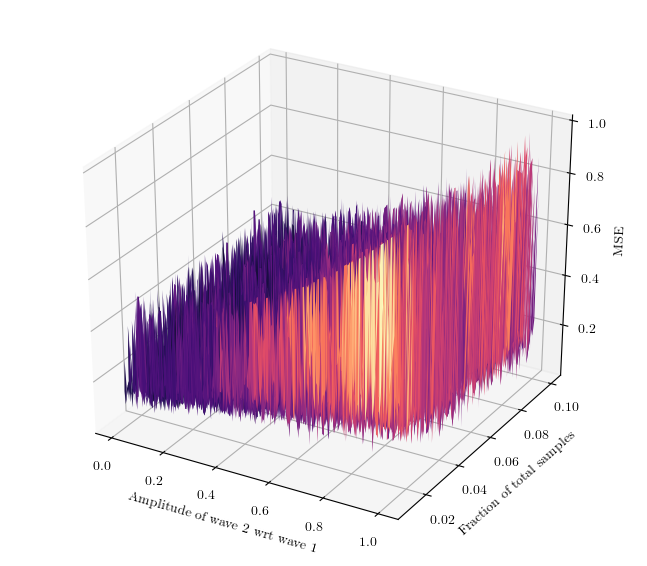

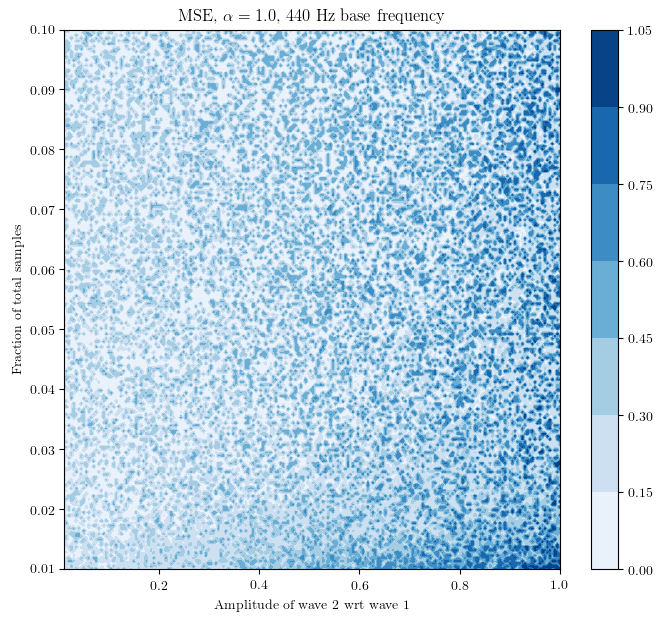

In [71]:
Z = np.loadtxt("Experiment/RSCS-8/MSE_multiple_base440Hz_1-10pcfrac_amp0.1-1_44.1kSat_200Sas.txt")

fig = mp.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection="3d")
#ax.view_init(elev=30, azim=60+180)
ax.plot_surface(X,Y/N,Z, cmap="magma")
ax.set_xlabel(r"\textrm{Amplitude of wave 2 wrt wave 1}")
ax.set_ylabel(r"\textrm{Fraction of total samples}")
ax.set_zlabel(r"\textrm{MSE}")
mp.savefig("Experiment/RSCS-8/MSE_multiple_base440Hz_1-10pcfrac_amp0.01-1_44kSat_200Sas-surface.png", dpi=300, bbox_inches="tight")
mp.show()

mp.subplots(figsize=(8,7))
mp.xlabel(r"\textrm{Amplitude of wave 2 wrt wave 1}")
mp.ylabel(r"\textrm{Fraction of total samples}")
mp.title(r"\textrm{MSE, $\alpha = 1.0$, 440 Hz base frequency}")
mp.contourf(X,Y/N,Z, cmap="Blues")
mp.colorbar()
mp.savefig("d:/kenneth/documents/4-2/vip/progrep1_prev/varyamp_error.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()